In [103]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import urllib.request
import os
import shutil
from tqdm import tqdm
import numpy as np
import pandas as pd
from collections import defaultdict
from torchattacks import PGD
import torch
import os
import pickle
from collections import defaultdict
from tqdm import tqdm

c:\Users\nasta\miniconda3\envs\adaexam\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nasta\miniconda3\envs\adaexam\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


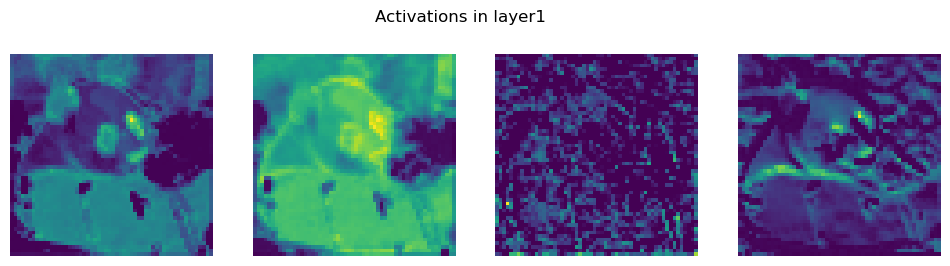

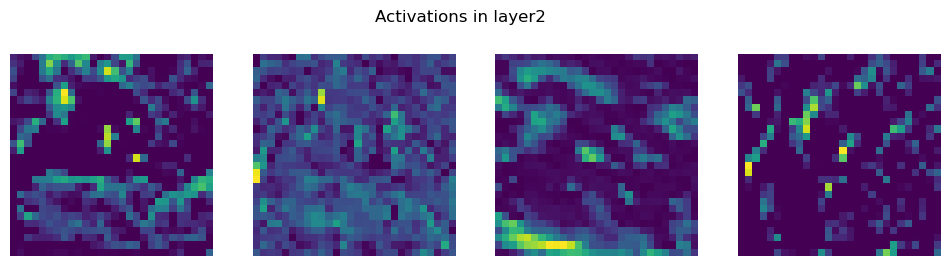

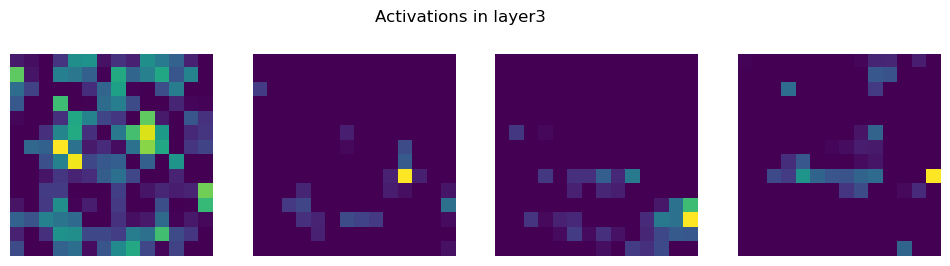

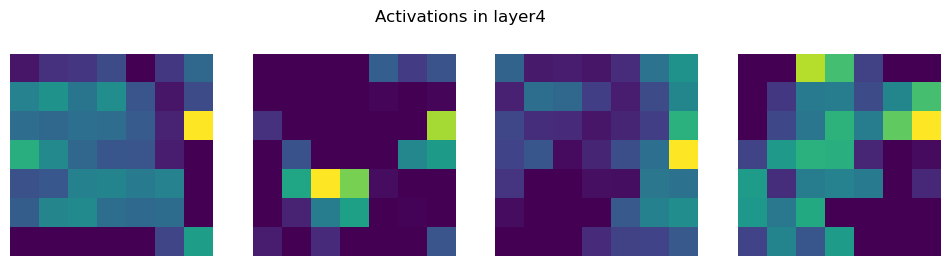

In [104]:
# Load Pretrained ResNet
model = models.resnet50(pretrained=True)
model.eval()  # Set to evaluation mode

# Define image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load Image
image_path = "Ressources/panda.jpg"  # Change this to your image path
image = Image.open(image_path)
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Hook function to capture activations
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks for intermediate layers
layer_names = ["layer1", "layer2", "layer3", "layer4"]
for name in layer_names:
    layer = dict(model.named_children())[name]
    layer.register_forward_hook(get_activation(name))

# Forward pass
with torch.no_grad():
    model(input_tensor)

# Plot activations
for name in layer_names:
    act = activations[name][0]
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    fig.suptitle(f"Activations in {name}")

    for i, ax in enumerate(axes):
        ax.imshow(act[i].cpu().numpy(), cmap="viridis")
        ax.axis("off")

    plt.show()


In [105]:
# Function to preprocess images for ResNet-50
def preprocess_images(image_paths):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    images = [transform(Image.open(path).convert("RGB")) for path in image_paths]
    return torch.stack(images)

# Function to extract activations from specified layers in ResNet
def get_layer_activations(model, images, target_layers):
    activations = {}

    def hook_fn(module, input, output, layer_name):
        # activation.shape -> [batch_size, num_channels, height, width]
        # activations[layer_name] = output.detach().mean(dim=[2, 3])
        # activations[layer_name] = output.detach().amax(dim=[2, 3])
        activations[layer_name] = output.detach().median(dim=[2, 3])

    hooks = []
    for name, layer in model.named_modules():
        if name in target_layers:
            hooks.append(layer.register_forward_hook(lambda m, i, o, n=name: hook_fn(m, i, o, n)))

    # Forward pass to store activations
    with torch.no_grad():
        model(images)

    # Remove hooks after use
    for hook in hooks:
        hook.remove()

    return activations

# Modified function to get the top 10% most activated neurons
def get_top_neurons(activations):
    num_neurons = activations.shape[1]
    top_k = min(max(5, int(0.1 * num_neurons)), 10)  # 10% of neurons, minimum 5, maximum 20
    #print("top_k:", top_k)
    max_vals, indices = torch.topk(activations, top_k, dim=1)
    max_vals_numpy = max_vals.cpu().numpy()[0]
    indices_numpy = indices.cpu().numpy()[0]
    return max_vals_numpy, indices_numpy

# Function to get activation values for specific neuron indices
def get_neuron(activations, neuron_indices):
    act_numpy = activations.cpu().numpy()[0]
    neuron_value = {}
    for i in range(len(neuron_indices)):
        neuron_value[i] = act_numpy[neuron_indices[i]]
    return neuron_value

# Function to plot top neurons
def plot_top_neurons(layer, normal_vals, normal_idx, perturbed_vals, perturbed_idx):
    # Convert numpy arrays to lists if they're not already
    if hasattr(normal_idx, 'tolist'):
        normal_idx = normal_idx.tolist()
    if hasattr(perturbed_idx, 'tolist'):
        perturbed_idx = perturbed_idx.tolist()
    
    # Combine indices for color mapping
    all_indices = list(set(normal_idx) | set(perturbed_idx))
    colors = plt.cm.tab20(np.linspace(0, 1, len(all_indices)))
    index_color_map = {idx: colors[i] for i, idx in enumerate(all_indices)}

    # Create bar plot
    x = np.arange(len(normal_vals))  # Top neuron ranks
    width = 0.4  # Bar width

    fig, ax = plt.subplots(figsize=(12, 7))

    # Plot bars for normal and perturbed values
    normal_labels = set()
    perturbed_labels = set()
    
    for i, (val, idx) in enumerate(zip(normal_vals, normal_idx)):
        label = f"Neuron {idx}" if f"Neuron {idx}" not in normal_labels else ""
        normal_labels.add(f"Neuron {idx}")
        ax.bar(x[i] + width/2, val, width, color=index_color_map[idx], label=label)

    for i, (val, idx) in enumerate(zip(perturbed_vals, perturbed_idx)):
        label = f"Neuron {idx}" if f"Neuron {idx}" not in perturbed_labels and f"Neuron {idx}" not in normal_labels else ""
        perturbed_labels.add(f"Neuron {idx}")
        ax.bar(x[i] - width/2, val, width, color=index_color_map[idx], label=label)

    # Add labels and title
    ax.set_xlabel("Top Neurons")
    ax.set_ylabel("Activation Values")
    ax.set_title(f"Top Activated Neurons in {layer}")
    ax.set_xticks(x)
    ax.set_xticklabels([f"{i+1}" for i in range(len(normal_vals))])

    # Add legend for neuron indices
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), title="Neuron Indices", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add explanation text
    plt.figtext(0.5, 0.01, "Left bars: Perturbed image | Right bars: Normal image", 
               ha="center", fontsize=10, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [106]:
# Paths to images
normal_image_path = "Ressources/panda.jpg"
perturbed_image_path = "output/panda_perturbed.jpg"

# Load images
images = preprocess_images([normal_image_path, perturbed_image_path])

# Load ResNet-50 model
model = models.resnet50(pretrained=True)
model.eval()

# Define target layers
target_layers = ['conv1',
                'layer1.0.conv1', 'layer1.0.conv2', 'layer1.0.conv3',
                'layer1.1.conv1', 'layer1.1.conv2', 'layer1.1.conv3',
                'layer1.2.conv1', 'layer1.2.conv2', 'layer1.2.conv3',
                'layer2.0.conv1', 'layer2.0.conv2', 'layer2.0.conv3',
                'layer2.1.conv1', 'layer2.1.conv2', 'layer2.1.conv3',
                'layer2.2.conv1', 'layer2.2.conv2', 'layer2.2.conv3',
                'layer3.0.conv1', 'layer3.0.conv2', 'layer3.0.conv3',
                'layer3.1.conv1', 'layer3.1.conv2', 'layer3.1.conv3',
                'layer3.2.conv1', 'layer3.2.conv2', 'layer3.2.conv3',
                'layer4.0.conv1', 'layer4.0.conv2', 'layer4.0.conv3',
                'layer4.1.conv1', 'layer4.1.conv2', 'layer4.1.conv3',
                'layer4.2.conv1', 'layer4.2.conv2', 'layer4.2.conv3']


Comparing Top Activated Neurons for Normal vs Perturbed Image

Layer: conv1 (Neurons: 64)
 - Top 0 n neuron 5: Normal=4.5772, Perturbed=4.6424
 - Top 0 p neuron 5: Normal=4.5772, Perturbed=4.6424
 - Top 1 n neuron 36: Normal=4.0406, Perturbed=4.0093
 - Top 1 p neuron 3: Normal=4.0079, Perturbed=4.0885
 - Top 2 n neuron 51: Normal=4.0089, Perturbed=4.0451
 - Top 2 p neuron 51: Normal=4.0089, Perturbed=4.0451
 - Top 3 n neuron 3: Normal=4.0079, Perturbed=4.0885
 - Top 3 p neuron 36: Normal=4.0406, Perturbed=4.0093
 - Top 4 n neuron 37: Normal=3.3933, Perturbed=3.3751
 - Top 4 p neuron 37: Normal=3.3933, Perturbed=3.3751
 - Top 5 n neuron 32: Normal=3.2157, Perturbed=3.2309
 - Top 5 p neuron 32: Normal=3.2157, Perturbed=3.2309


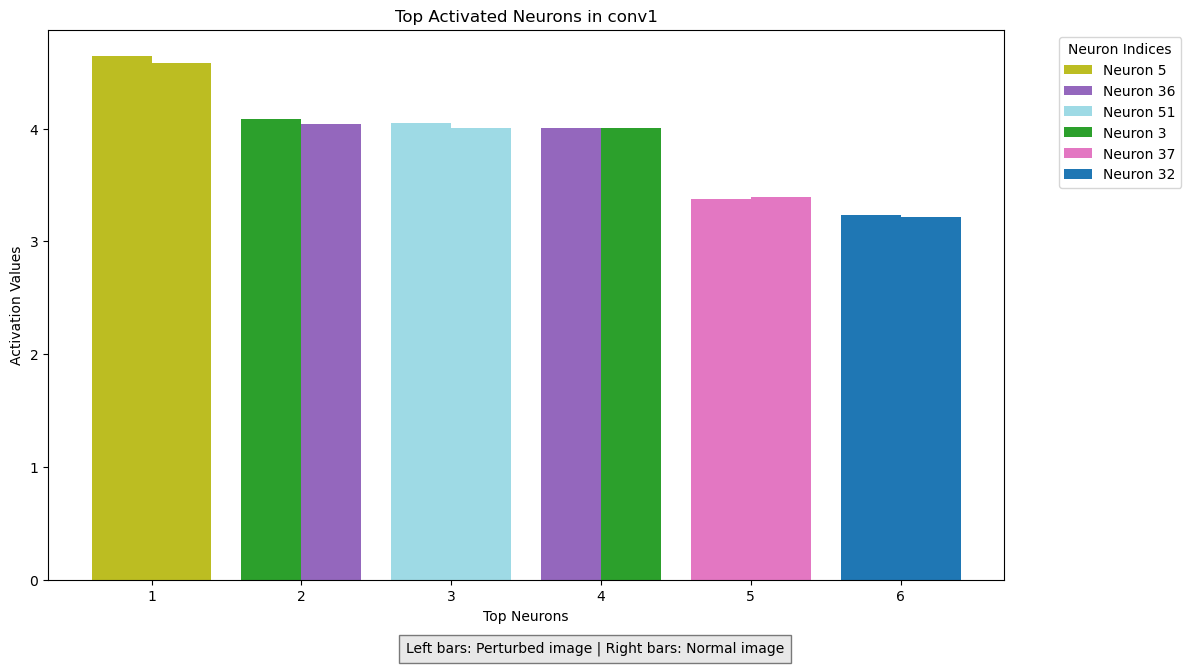

--------------------------------------------------
Layer: layer1.0.conv1 (Neurons: 64)
 - Top 0 n neuron 11: Normal=1.2079, Perturbed=1.2490
 - Top 0 p neuron 11: Normal=1.2079, Perturbed=1.2490
 - Top 1 n neuron 59: Normal=1.1209, Perturbed=1.1441
 - Top 1 p neuron 59: Normal=1.1209, Perturbed=1.1441
 - Top 2 n neuron 17: Normal=0.7707, Perturbed=0.7908
 - Top 2 p neuron 17: Normal=0.7707, Perturbed=0.7908
 - Top 3 n neuron 39: Normal=0.4480, Perturbed=0.4936
 - Top 3 p neuron 39: Normal=0.4480, Perturbed=0.4936
 - Top 4 n neuron 2: Normal=0.4023, Perturbed=0.4004
 - Top 4 p neuron 2: Normal=0.4023, Perturbed=0.4004
 - Top 5 n neuron 31: Normal=0.3930, Perturbed=0.3894
 - Top 5 p neuron 31: Normal=0.3930, Perturbed=0.3894


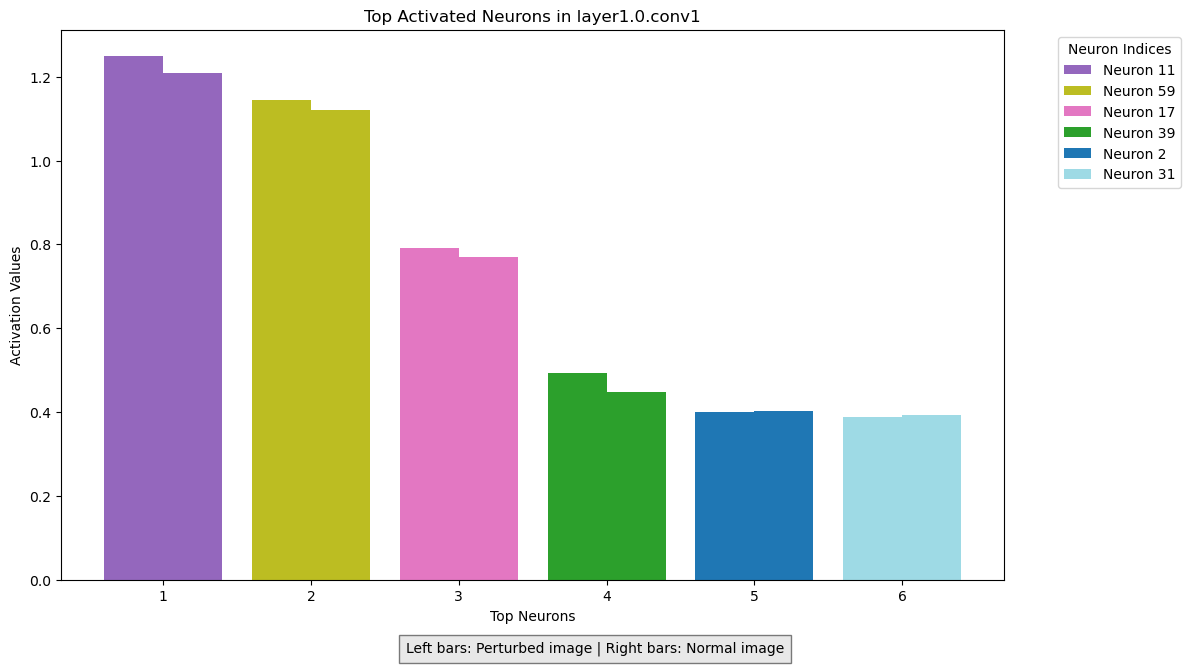

--------------------------------------------------
Layer: layer1.0.conv2 (Neurons: 64)
 - Top 0 n neuron 23: Normal=0.6569, Perturbed=0.6567
 - Top 0 p neuron 23: Normal=0.6569, Perturbed=0.6567
 - Top 1 n neuron 26: Normal=0.6219, Perturbed=0.5995
 - Top 1 p neuron 39: Normal=0.6024, Perturbed=0.6075
 - Top 2 n neuron 20: Normal=0.6049, Perturbed=0.6047
 - Top 2 p neuron 20: Normal=0.6049, Perturbed=0.6047
 - Top 3 n neuron 39: Normal=0.6024, Perturbed=0.6075
 - Top 3 p neuron 26: Normal=0.6219, Perturbed=0.5995
 - Top 4 n neuron 38: Normal=0.5487, Perturbed=0.5178
 - Top 4 p neuron 42: Normal=0.5469, Perturbed=0.5484
 - Top 5 n neuron 42: Normal=0.5469, Perturbed=0.5484
 - Top 5 p neuron 63: Normal=0.5405, Perturbed=0.5444


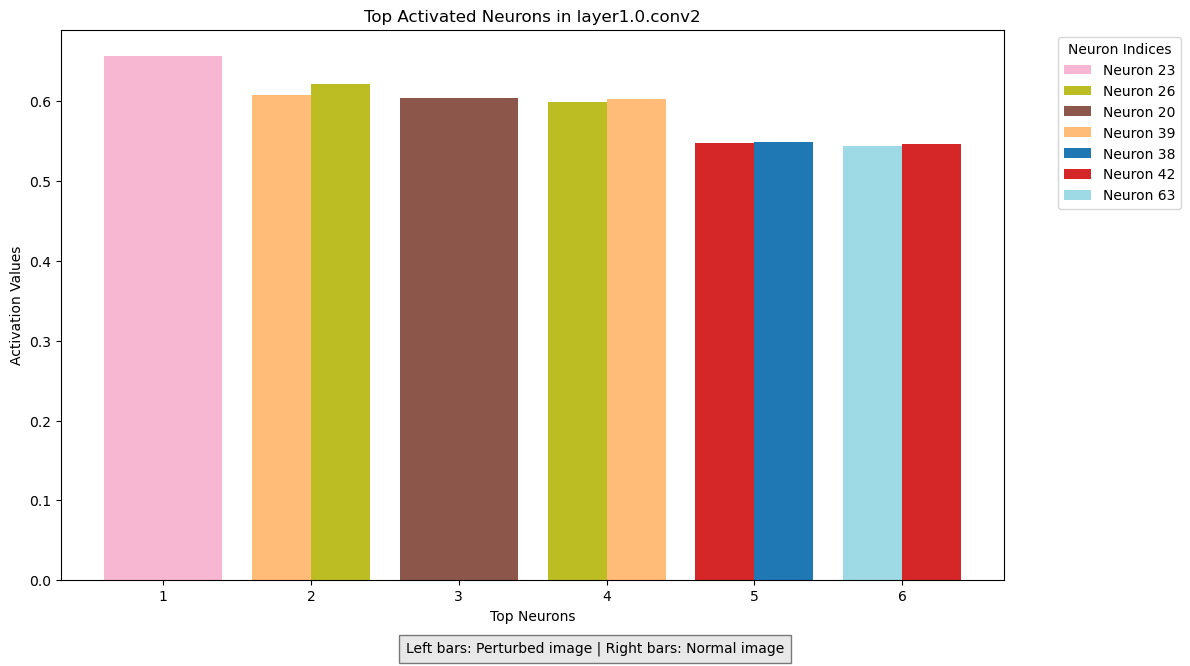

--------------------------------------------------
Layer: layer1.0.conv3 (Neurons: 256)
 - Top 0 n neuron 160: Normal=0.3491, Perturbed=0.3453
 - Top 0 p neuron 234: Normal=0.3481, Perturbed=0.3494
 - Top 1 n neuron 234: Normal=0.3481, Perturbed=0.3494
 - Top 1 p neuron 160: Normal=0.3491, Perturbed=0.3453
 - Top 2 n neuron 81: Normal=0.3273, Perturbed=0.3141
 - Top 2 p neuron 81: Normal=0.3273, Perturbed=0.3141
 - Top 3 n neuron 203: Normal=0.2834, Perturbed=0.2796
 - Top 3 p neuron 231: Normal=0.2808, Perturbed=0.2863
 - Top 4 n neuron 231: Normal=0.2808, Perturbed=0.2863
 - Top 4 p neuron 203: Normal=0.2834, Perturbed=0.2796
 - Top 5 n neuron 121: Normal=0.2642, Perturbed=0.2617
 - Top 5 p neuron 121: Normal=0.2642, Perturbed=0.2617
 - Top 6 n neuron 97: Normal=0.2445, Perturbed=0.2431
 - Top 6 p neuron 97: Normal=0.2445, Perturbed=0.2431
 - Top 7 n neuron 106: Normal=0.2425, Perturbed=0.2429
 - Top 7 p neuron 106: Normal=0.2425, Perturbed=0.2429
 - Top 8 n neuron 237: Normal=0.2389

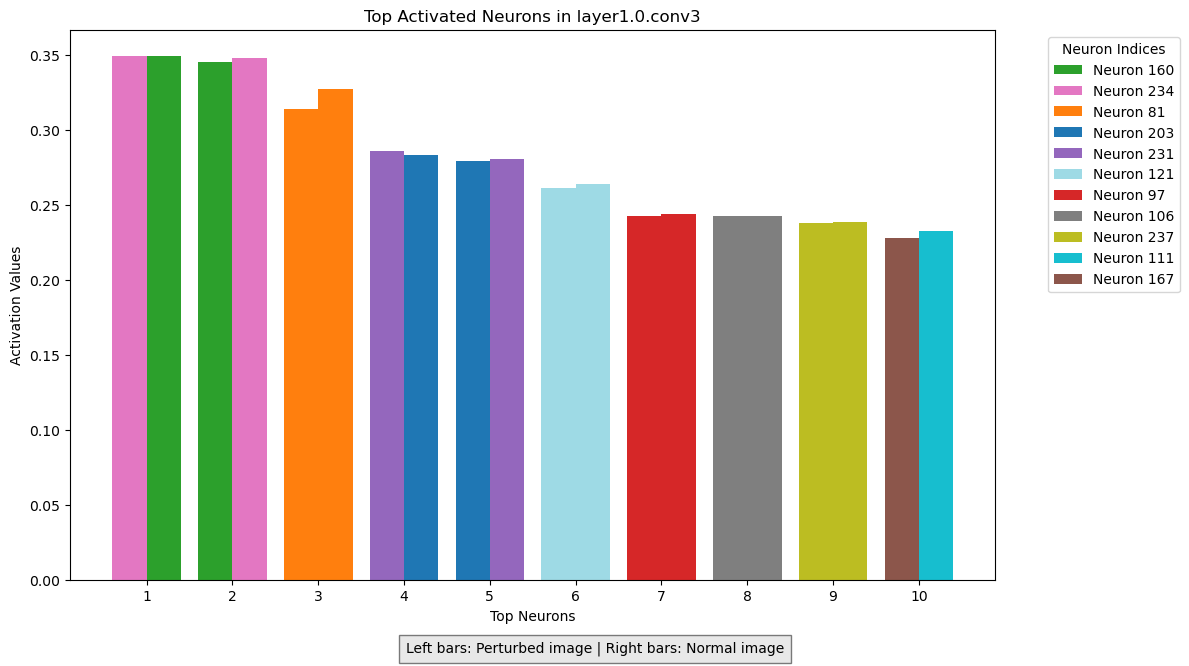

--------------------------------------------------
Layer: layer1.1.conv1 (Neurons: 64)
 - Top 0 n neuron 32: Normal=0.7121, Perturbed=0.6395
 - Top 0 p neuron 57: Normal=0.6869, Perturbed=0.7032
 - Top 1 n neuron 57: Normal=0.6869, Perturbed=0.7032
 - Top 1 p neuron 12: Normal=0.6446, Perturbed=0.6446
 - Top 2 n neuron 12: Normal=0.6446, Perturbed=0.6446
 - Top 2 p neuron 32: Normal=0.7121, Perturbed=0.6395
 - Top 3 n neuron 38: Normal=0.5629, Perturbed=0.5057
 - Top 3 p neuron 4: Normal=0.5583, Perturbed=0.5375
 - Top 4 n neuron 4: Normal=0.5583, Perturbed=0.5375
 - Top 4 p neuron 40: Normal=0.5232, Perturbed=0.5302
 - Top 5 n neuron 51: Normal=0.5391, Perturbed=0.5136
 - Top 5 p neuron 50: Normal=0.5149, Perturbed=0.5166


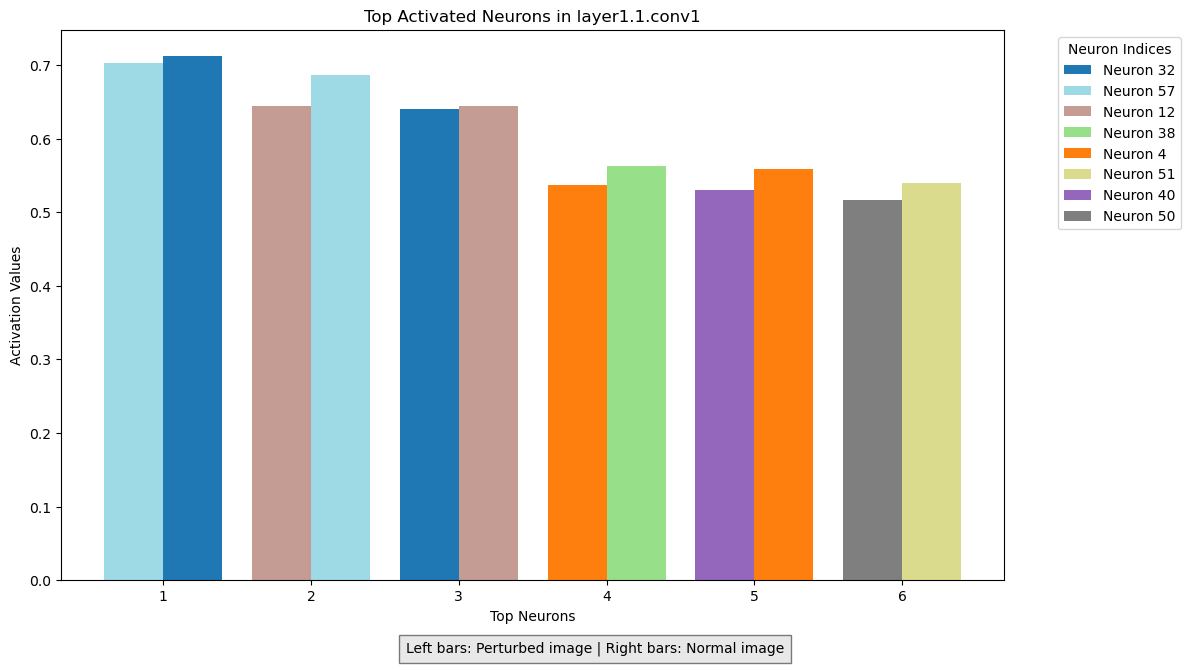

--------------------------------------------------
Layer: layer1.1.conv2 (Neurons: 64)
 - Top 0 n neuron 23: Normal=0.5025, Perturbed=0.4638
 - Top 0 p neuron 23: Normal=0.5025, Perturbed=0.4638
 - Top 1 n neuron 37: Normal=0.4682, Perturbed=0.4183
 - Top 1 p neuron 31: Normal=0.4547, Perturbed=0.4389
 - Top 2 n neuron 31: Normal=0.4547, Perturbed=0.4389
 - Top 2 p neuron 37: Normal=0.4682, Perturbed=0.4183
 - Top 3 n neuron 60: Normal=0.4521, Perturbed=0.4072
 - Top 3 p neuron 60: Normal=0.4521, Perturbed=0.4072
 - Top 4 n neuron 58: Normal=0.4338, Perturbed=0.3529
 - Top 4 p neuron 17: Normal=0.4230, Perturbed=0.4034
 - Top 5 n neuron 17: Normal=0.4230, Perturbed=0.4034
 - Top 5 p neuron 4: Normal=0.4061, Perturbed=0.3904


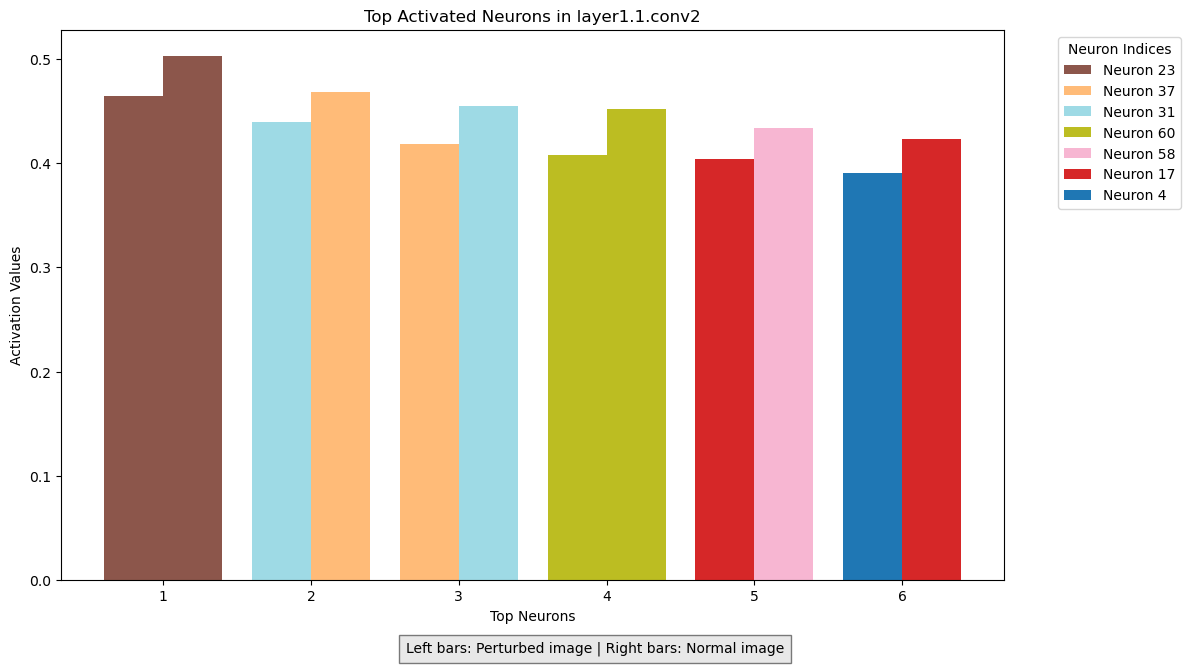

--------------------------------------------------
Layer: layer1.1.conv3 (Neurons: 256)
 - Top 0 n neuron 11: Normal=0.2880, Perturbed=0.2841
 - Top 0 p neuron 11: Normal=0.2880, Perturbed=0.2841
 - Top 1 n neuron 114: Normal=0.2852, Perturbed=0.2822
 - Top 1 p neuron 114: Normal=0.2852, Perturbed=0.2822
 - Top 2 n neuron 237: Normal=0.2816, Perturbed=0.2737
 - Top 2 p neuron 237: Normal=0.2816, Perturbed=0.2737
 - Top 3 n neuron 245: Normal=0.2791, Perturbed=0.2135
 - Top 3 p neuron 121: Normal=0.2618, Perturbed=0.2675
 - Top 4 n neuron 121: Normal=0.2618, Perturbed=0.2675
 - Top 4 p neuron 220: Normal=0.2500, Perturbed=0.2443
 - Top 5 n neuron 51: Normal=0.2575, Perturbed=0.2418
 - Top 5 p neuron 51: Normal=0.2575, Perturbed=0.2418
 - Top 6 n neuron 220: Normal=0.2500, Perturbed=0.2443
 - Top 6 p neuron 172: Normal=0.2437, Perturbed=0.2214
 - Top 7 n neuron 172: Normal=0.2437, Perturbed=0.2214
 - Top 7 p neuron 34: Normal=0.2120, Perturbed=0.2203
 - Top 8 n neuron 94: Normal=0.2226, 

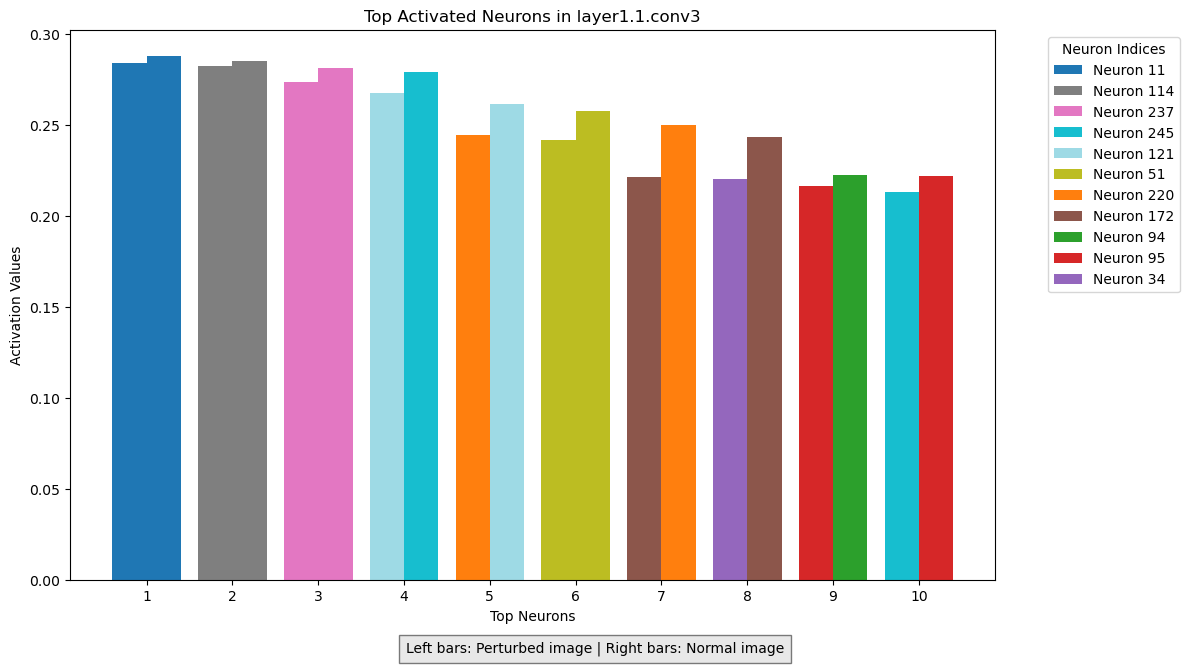

--------------------------------------------------
Layer: layer1.2.conv1 (Neurons: 64)
 - Top 0 n neuron 25: Normal=0.7085, Perturbed=0.6930
 - Top 0 p neuron 25: Normal=0.7085, Perturbed=0.6930
 - Top 1 n neuron 35: Normal=0.6488, Perturbed=0.5739
 - Top 1 p neuron 41: Normal=0.5670, Perturbed=0.6142
 - Top 2 n neuron 34: Normal=0.6341, Perturbed=0.6060
 - Top 2 p neuron 34: Normal=0.6341, Perturbed=0.6060
 - Top 3 n neuron 31: Normal=0.5858, Perturbed=0.4941
 - Top 3 p neuron 35: Normal=0.6488, Perturbed=0.5739
 - Top 4 n neuron 39: Normal=0.5830, Perturbed=0.5714
 - Top 4 p neuron 39: Normal=0.5830, Perturbed=0.5714
 - Top 5 n neuron 41: Normal=0.5670, Perturbed=0.6142
 - Top 5 p neuron 51: Normal=0.4937, Perturbed=0.5394


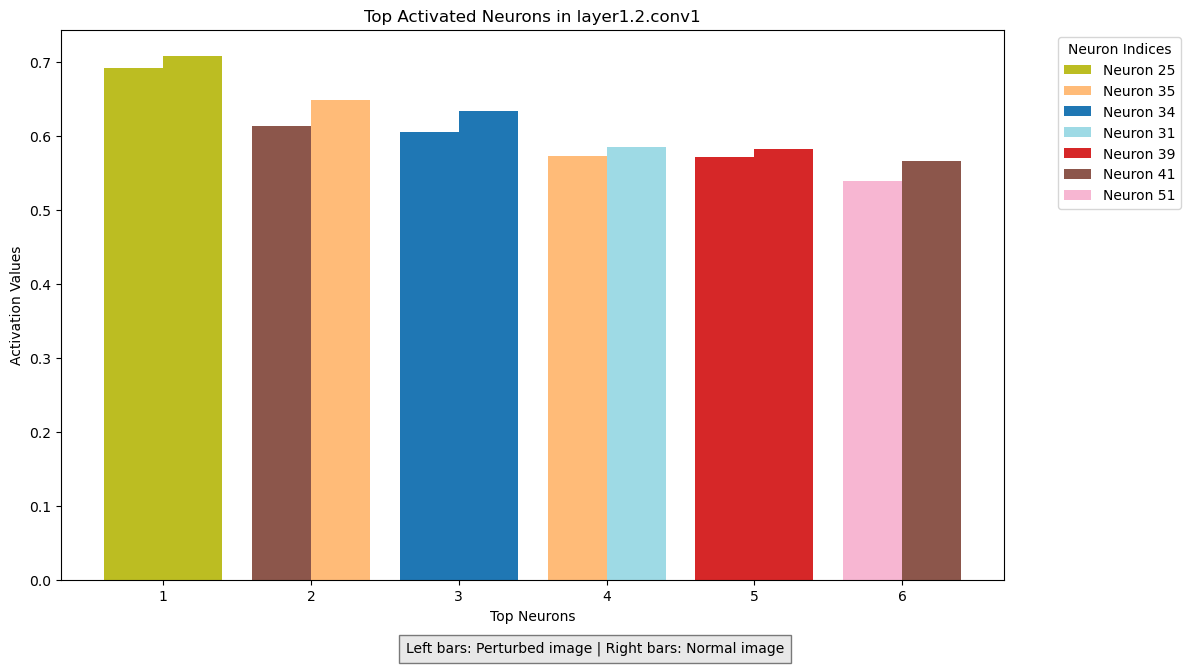

--------------------------------------------------
Layer: layer1.2.conv2 (Neurons: 64)
 - Top 0 n neuron 22: Normal=0.7609, Perturbed=0.6792
 - Top 0 p neuron 22: Normal=0.7609, Perturbed=0.6792
 - Top 1 n neuron 56: Normal=0.6534, Perturbed=0.6227
 - Top 1 p neuron 56: Normal=0.6534, Perturbed=0.6227
 - Top 2 n neuron 19: Normal=0.6491, Perturbed=0.5983
 - Top 2 p neuron 19: Normal=0.6491, Perturbed=0.5983
 - Top 3 n neuron 10: Normal=0.6268, Perturbed=0.4760
 - Top 3 p neuron 60: Normal=0.6186, Perturbed=0.5915
 - Top 4 n neuron 13: Normal=0.6204, Perturbed=0.5759
 - Top 4 p neuron 13: Normal=0.6204, Perturbed=0.5759
 - Top 5 n neuron 60: Normal=0.6186, Perturbed=0.5915
 - Top 5 p neuron 29: Normal=0.6043, Perturbed=0.5410


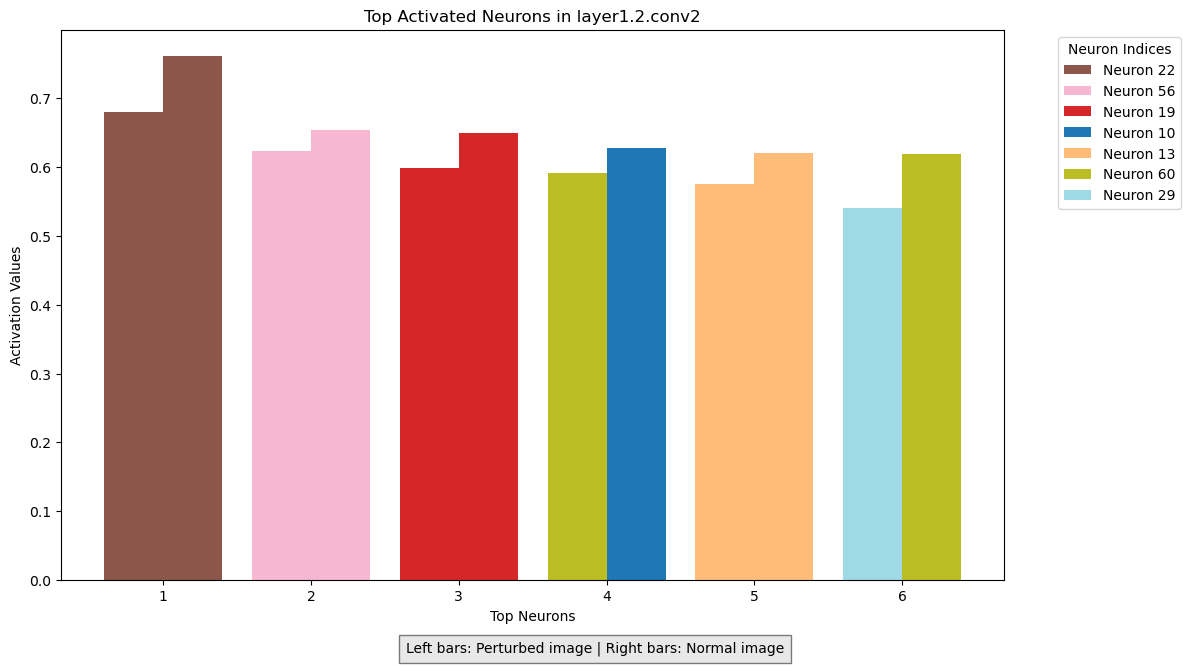

--------------------------------------------------
Layer: layer1.2.conv3 (Neurons: 256)
 - Top 0 n neuron 49: Normal=0.3670, Perturbed=0.3200
 - Top 0 p neuron 49: Normal=0.3670, Perturbed=0.3200
 - Top 1 n neuron 66: Normal=0.3017, Perturbed=0.2255
 - Top 1 p neuron 90: Normal=0.2554, Perturbed=0.2459
 - Top 2 n neuron 151: Normal=0.2645, Perturbed=0.2304
 - Top 2 p neuron 71: Normal=0.2622, Perturbed=0.2352
 - Top 3 n neuron 71: Normal=0.2622, Perturbed=0.2352
 - Top 3 p neuron 151: Normal=0.2645, Perturbed=0.2304
 - Top 4 n neuron 90: Normal=0.2554, Perturbed=0.2459
 - Top 4 p neuron 4: Normal=0.2118, Perturbed=0.2288
 - Top 5 n neuron 85: Normal=0.2363, Perturbed=0.2031
 - Top 5 p neuron 66: Normal=0.3017, Perturbed=0.2255
 - Top 6 n neuron 230: Normal=0.2281, Perturbed=0.1966
 - Top 6 p neuron 140: Normal=0.1978, Perturbed=0.2098
 - Top 7 n neuron 137: Normal=0.2202, Perturbed=0.2013
 - Top 7 p neuron 85: Normal=0.2363, Perturbed=0.2031
 - Top 8 n neuron 40: Normal=0.2164, Perturb

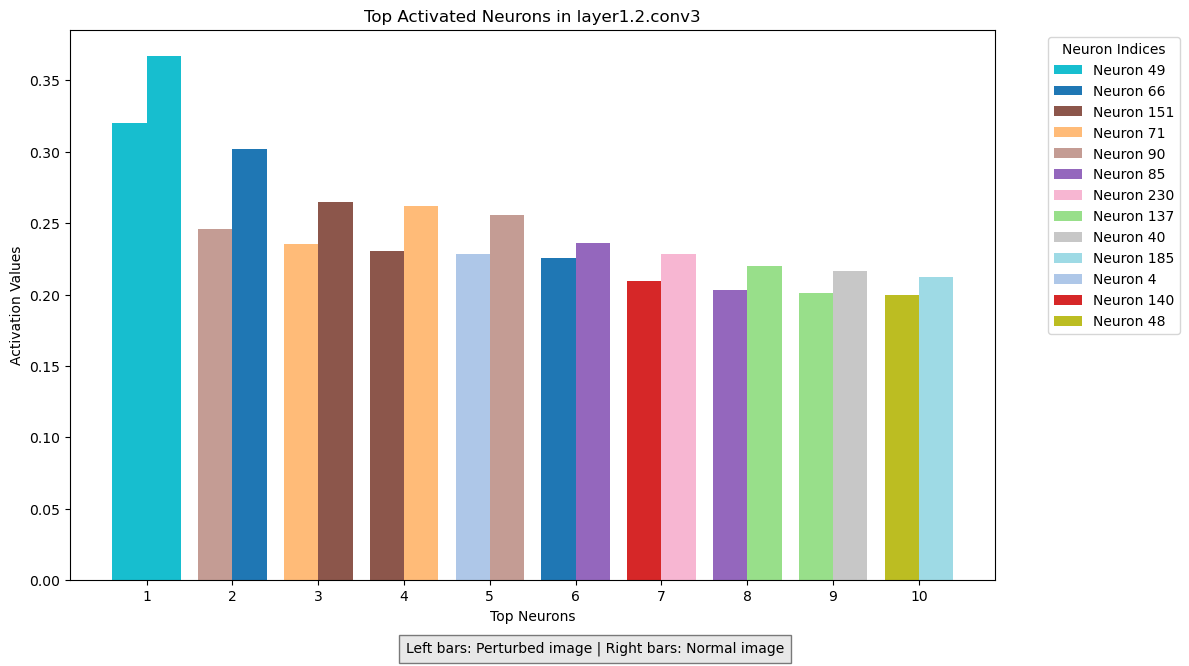

--------------------------------------------------
Layer: layer2.0.conv1 (Neurons: 128)
 - Top 0 n neuron 28: Normal=1.3592, Perturbed=1.2121
 - Top 0 p neuron 28: Normal=1.3592, Perturbed=1.2121
 - Top 1 n neuron 38: Normal=1.3095, Perturbed=1.0753
 - Top 1 p neuron 38: Normal=1.3095, Perturbed=1.0753
 - Top 2 n neuron 24: Normal=0.9313, Perturbed=0.9368
 - Top 2 p neuron 24: Normal=0.9313, Perturbed=0.9368
 - Top 3 n neuron 58: Normal=0.8579, Perturbed=0.7355
 - Top 3 p neuron 127: Normal=0.8373, Perturbed=0.7782
 - Top 4 n neuron 127: Normal=0.8373, Perturbed=0.7782
 - Top 4 p neuron 49: Normal=0.7523, Perturbed=0.7591
 - Top 5 n neuron 57: Normal=0.7549, Perturbed=0.6800
 - Top 5 p neuron 53: Normal=0.7455, Perturbed=0.7539
 - Top 6 n neuron 49: Normal=0.7523, Perturbed=0.7591
 - Top 6 p neuron 58: Normal=0.8579, Perturbed=0.7355
 - Top 7 n neuron 53: Normal=0.7455, Perturbed=0.7539
 - Top 7 p neuron 85: Normal=0.5984, Perturbed=0.6827
 - Top 8 n neuron 26: Normal=0.6921, Perturbed

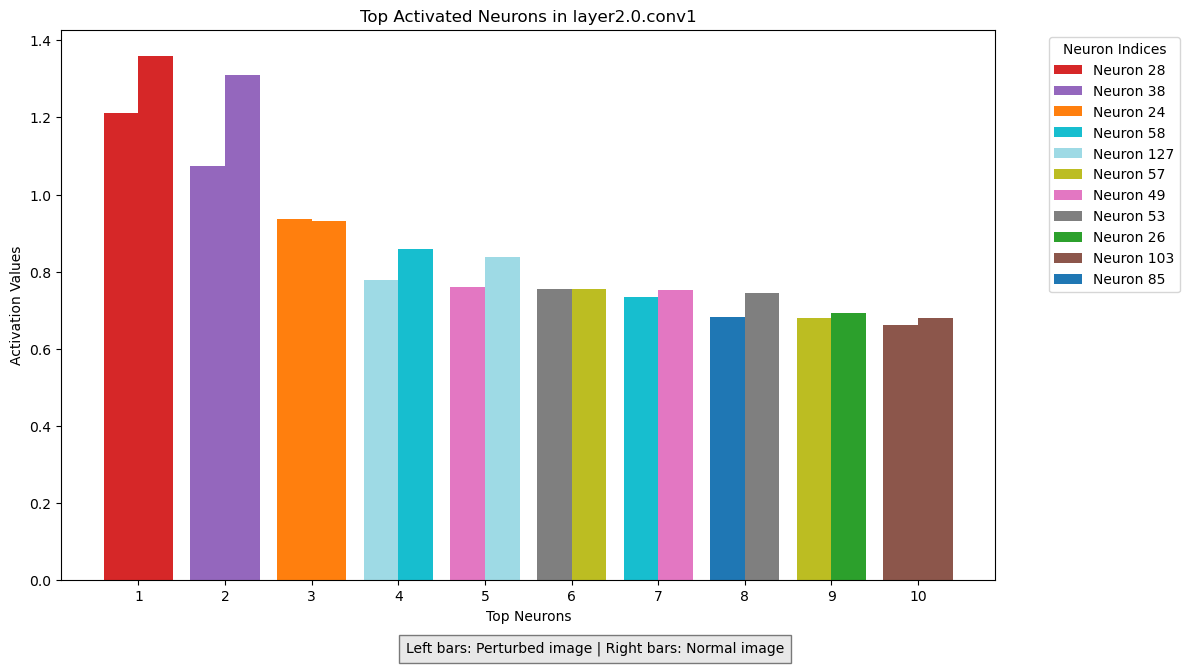

--------------------------------------------------
Layer: layer2.0.conv2 (Neurons: 128)
 - Top 0 n neuron 43: Normal=0.9571, Perturbed=0.9760
 - Top 0 p neuron 43: Normal=0.9571, Perturbed=0.9760
 - Top 1 n neuron 5: Normal=0.7530, Perturbed=0.5550
 - Top 1 p neuron 81: Normal=0.7111, Perturbed=0.7042
 - Top 2 n neuron 99: Normal=0.7376, Perturbed=0.6853
 - Top 2 p neuron 99: Normal=0.7376, Perturbed=0.6853
 - Top 3 n neuron 40: Normal=0.7264, Perturbed=0.6552
 - Top 3 p neuron 96: Normal=0.6981, Perturbed=0.6813
 - Top 4 n neuron 81: Normal=0.7111, Perturbed=0.7042
 - Top 4 p neuron 40: Normal=0.7264, Perturbed=0.6552
 - Top 5 n neuron 96: Normal=0.6981, Perturbed=0.6813
 - Top 5 p neuron 72: Normal=0.6024, Perturbed=0.6479
 - Top 6 n neuron 126: Normal=0.6774, Perturbed=0.6349
 - Top 6 p neuron 126: Normal=0.6774, Perturbed=0.6349
 - Top 7 n neuron 25: Normal=0.6224, Perturbed=0.6268
 - Top 7 p neuron 25: Normal=0.6224, Perturbed=0.6268
 - Top 8 n neuron 51: Normal=0.6134, Perturbed=

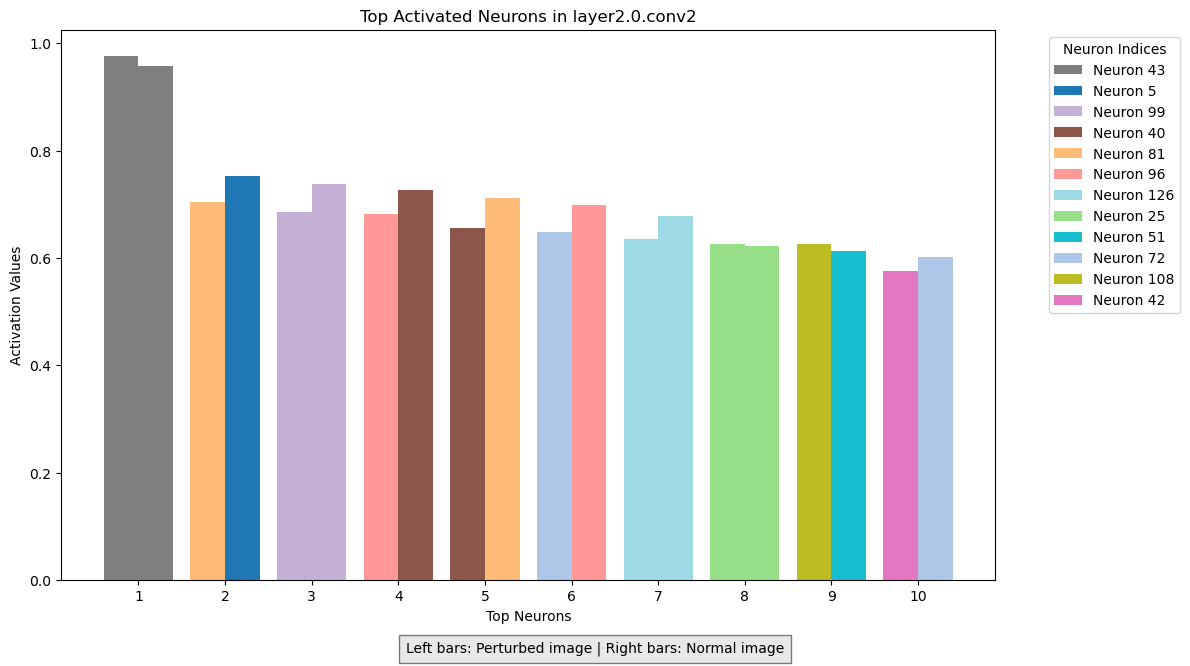

--------------------------------------------------
Layer: layer2.0.conv3 (Neurons: 512)
 - Top 0 n neuron 450: Normal=0.5293, Perturbed=0.5249
 - Top 0 p neuron 450: Normal=0.5293, Perturbed=0.5249
 - Top 1 n neuron 74: Normal=0.4322, Perturbed=0.3801
 - Top 1 p neuron 172: Normal=0.4134, Perturbed=0.4206
 - Top 2 n neuron 172: Normal=0.4134, Perturbed=0.4206
 - Top 2 p neuron 288: Normal=0.4053, Perturbed=0.4108
 - Top 3 n neuron 331: Normal=0.4060, Perturbed=0.3762
 - Top 3 p neuron 402: Normal=0.3608, Perturbed=0.4035
 - Top 4 n neuron 288: Normal=0.4053, Perturbed=0.4108
 - Top 4 p neuron 74: Normal=0.4322, Perturbed=0.3801
 - Top 5 n neuron 70: Normal=0.4044, Perturbed=0.3723
 - Top 5 p neuron 331: Normal=0.4060, Perturbed=0.3762
 - Top 6 n neuron 405: Normal=0.4004, Perturbed=0.3743
 - Top 6 p neuron 405: Normal=0.4004, Perturbed=0.3743
 - Top 7 n neuron 238: Normal=0.3818, Perturbed=0.3604
 - Top 7 p neuron 70: Normal=0.4044, Perturbed=0.3723
 - Top 8 n neuron 29: Normal=0.3683,

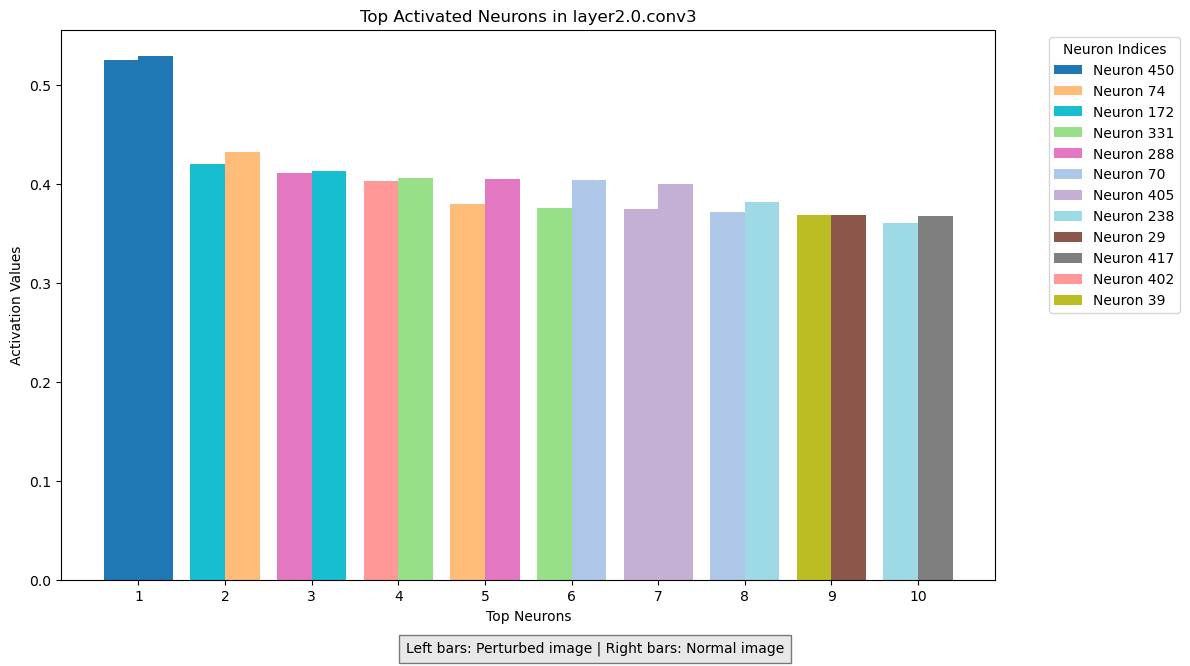

--------------------------------------------------
Layer: layer2.1.conv1 (Neurons: 128)
 - Top 0 n neuron 92: Normal=0.6452, Perturbed=0.6155
 - Top 0 p neuron 92: Normal=0.6452, Perturbed=0.6155
 - Top 1 n neuron 119: Normal=0.5970, Perturbed=0.5807
 - Top 1 p neuron 119: Normal=0.5970, Perturbed=0.5807
 - Top 2 n neuron 97: Normal=0.5221, Perturbed=0.5165
 - Top 2 p neuron 31: Normal=0.4956, Perturbed=0.5241
 - Top 3 n neuron 126: Normal=0.5072, Perturbed=0.5072
 - Top 3 p neuron 97: Normal=0.5221, Perturbed=0.5165
 - Top 4 n neuron 31: Normal=0.4956, Perturbed=0.5241
 - Top 4 p neuron 126: Normal=0.5072, Perturbed=0.5072
 - Top 5 n neuron 76: Normal=0.4615, Perturbed=0.4783
 - Top 5 p neuron 72: Normal=0.4453, Perturbed=0.4797
 - Top 6 n neuron 72: Normal=0.4453, Perturbed=0.4797
 - Top 6 p neuron 76: Normal=0.4615, Perturbed=0.4783
 - Top 7 n neuron 41: Normal=0.4159, Perturbed=0.4606
 - Top 7 p neuron 41: Normal=0.4159, Perturbed=0.4606
 - Top 8 n neuron 117: Normal=0.3956, Pertur

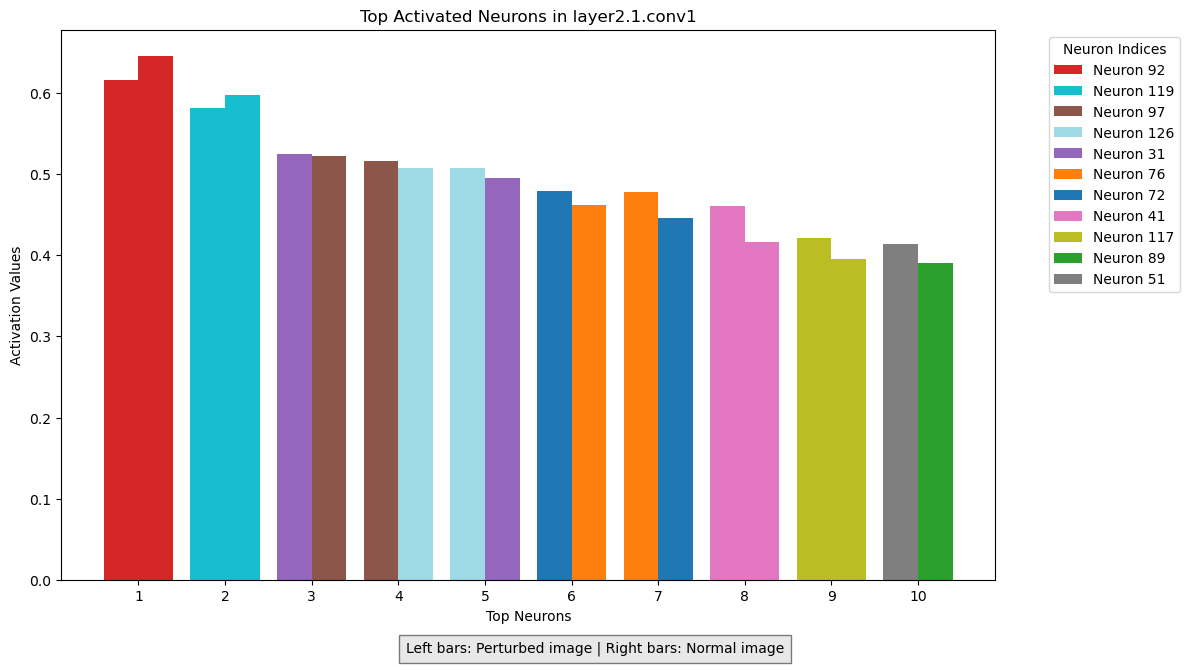

--------------------------------------------------
Layer: layer2.1.conv2 (Neurons: 128)
 - Top 0 n neuron 116: Normal=0.8148, Perturbed=0.7759
 - Top 0 p neuron 116: Normal=0.8148, Perturbed=0.7759
 - Top 1 n neuron 41: Normal=0.6449, Perturbed=0.6567
 - Top 1 p neuron 41: Normal=0.6449, Perturbed=0.6567
 - Top 2 n neuron 103: Normal=0.6383, Perturbed=0.6479
 - Top 2 p neuron 103: Normal=0.6383, Perturbed=0.6479
 - Top 3 n neuron 19: Normal=0.5329, Perturbed=0.5256
 - Top 3 p neuron 19: Normal=0.5329, Perturbed=0.5256
 - Top 4 n neuron 118: Normal=0.5279, Perturbed=0.5098
 - Top 4 p neuron 118: Normal=0.5279, Perturbed=0.5098
 - Top 5 n neuron 2: Normal=0.4878, Perturbed=0.4736
 - Top 5 p neuron 49: Normal=0.4679, Perturbed=0.4951
 - Top 6 n neuron 3: Normal=0.4842, Perturbed=0.4893
 - Top 6 p neuron 3: Normal=0.4842, Perturbed=0.4893
 - Top 7 n neuron 80: Normal=0.4734, Perturbed=0.4617
 - Top 7 p neuron 2: Normal=0.4878, Perturbed=0.4736
 - Top 8 n neuron 49: Normal=0.4679, Perturbed

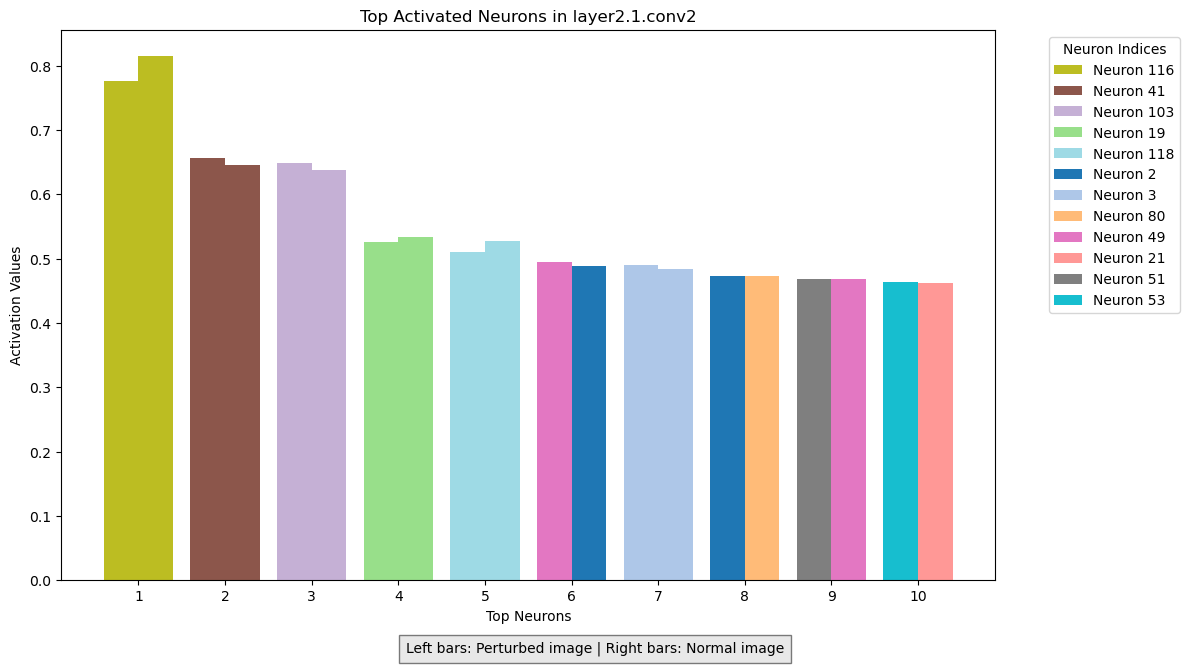

--------------------------------------------------
Layer: layer2.1.conv3 (Neurons: 512)
 - Top 0 n neuron 450: Normal=0.5548, Perturbed=0.5604
 - Top 0 p neuron 450: Normal=0.5548, Perturbed=0.5604
 - Top 1 n neuron 421: Normal=0.2231, Perturbed=0.2145
 - Top 1 p neuron 421: Normal=0.2231, Perturbed=0.2145
 - Top 2 n neuron 42: Normal=0.2199, Perturbed=0.1963
 - Top 2 p neuron 236: Normal=0.2042, Perturbed=0.2070
 - Top 3 n neuron 198: Normal=0.2082, Perturbed=0.1971
 - Top 3 p neuron 198: Normal=0.2082, Perturbed=0.1971
 - Top 4 n neuron 236: Normal=0.2042, Perturbed=0.2070
 - Top 4 p neuron 42: Normal=0.2199, Perturbed=0.1963
 - Top 5 n neuron 307: Normal=0.1962, Perturbed=0.1942
 - Top 5 p neuron 307: Normal=0.1962, Perturbed=0.1942
 - Top 6 n neuron 214: Normal=0.1894, Perturbed=0.1890
 - Top 6 p neuron 214: Normal=0.1894, Perturbed=0.1890
 - Top 7 n neuron 319: Normal=0.1769, Perturbed=0.1672
 - Top 7 p neuron 143: Normal=0.1722, Perturbed=0.1877
 - Top 8 n neuron 153: Normal=0.17

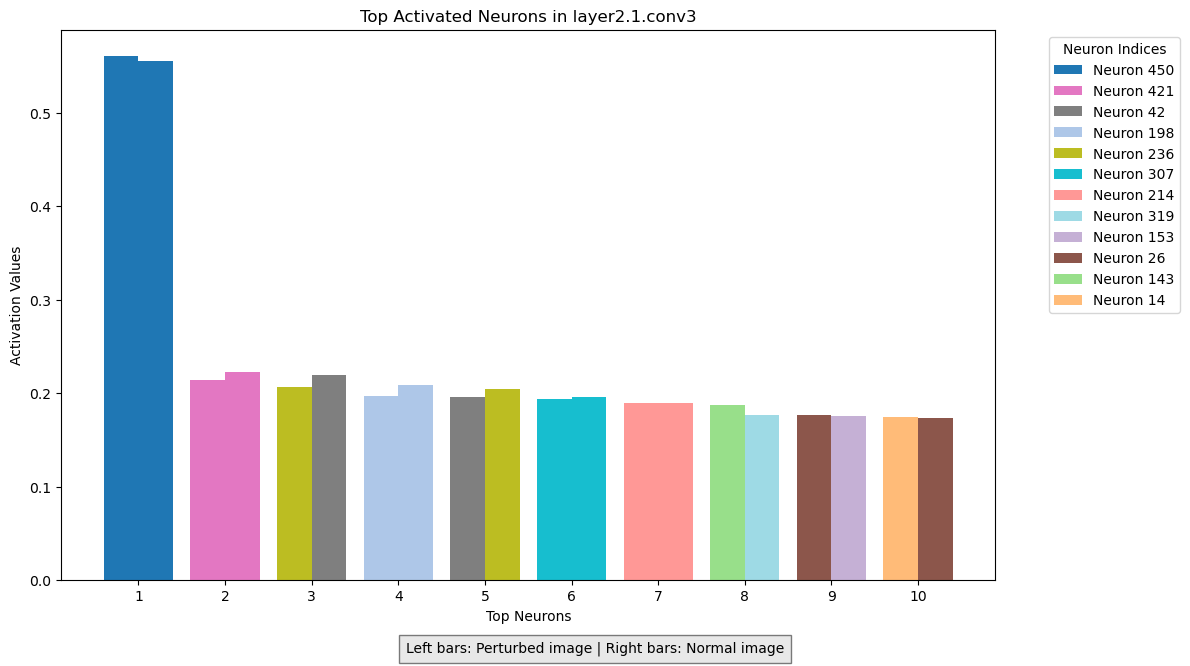

--------------------------------------------------
Layer: layer2.2.conv1 (Neurons: 128)
 - Top 0 n neuron 72: Normal=0.8358, Perturbed=0.7307
 - Top 0 p neuron 72: Normal=0.8358, Perturbed=0.7307
 - Top 1 n neuron 57: Normal=0.7168, Perturbed=0.6864
 - Top 1 p neuron 57: Normal=0.7168, Perturbed=0.6864
 - Top 2 n neuron 104: Normal=0.6475, Perturbed=0.6194
 - Top 2 p neuron 25: Normal=0.6436, Perturbed=0.6370
 - Top 3 n neuron 25: Normal=0.6436, Perturbed=0.6370
 - Top 3 p neuron 104: Normal=0.6475, Perturbed=0.6194
 - Top 4 n neuron 13: Normal=0.6254, Perturbed=0.4840
 - Top 4 p neuron 23: Normal=0.5753, Perturbed=0.6009
 - Top 5 n neuron 69: Normal=0.6188, Perturbed=0.5784
 - Top 5 p neuron 69: Normal=0.6188, Perturbed=0.5784
 - Top 6 n neuron 87: Normal=0.6169, Perturbed=0.4884
 - Top 6 p neuron 58: Normal=0.5514, Perturbed=0.5754
 - Top 7 n neuron 116: Normal=0.5960, Perturbed=0.5628
 - Top 7 p neuron 116: Normal=0.5960, Perturbed=0.5628
 - Top 8 n neuron 8: Normal=0.5807, Perturbe

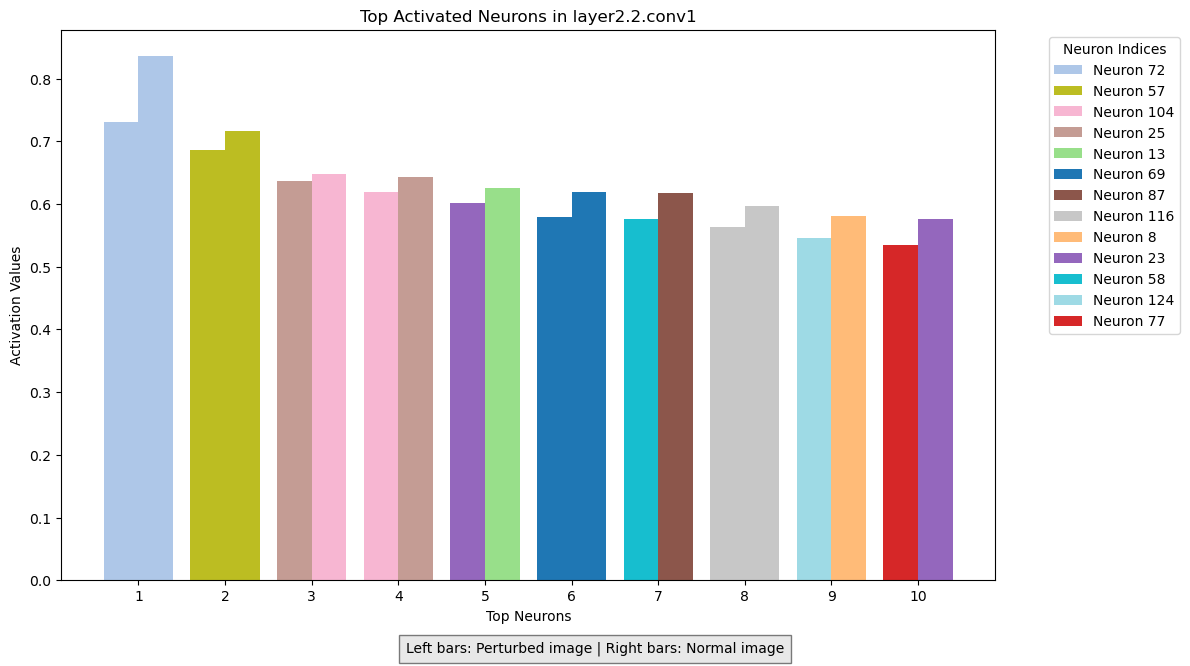

--------------------------------------------------
Layer: layer2.2.conv2 (Neurons: 128)
 - Top 0 n neuron 25: Normal=0.6809, Perturbed=0.5328
 - Top 0 p neuron 126: Normal=0.6649, Perturbed=0.6349
 - Top 1 n neuron 126: Normal=0.6649, Perturbed=0.6349
 - Top 1 p neuron 65: Normal=0.6131, Perturbed=0.6005
 - Top 2 n neuron 109: Normal=0.6363, Perturbed=0.5075
 - Top 2 p neuron 27: Normal=0.6250, Perturbed=0.5906
 - Top 3 n neuron 27: Normal=0.6250, Perturbed=0.5906
 - Top 3 p neuron 44: Normal=0.5715, Perturbed=0.5761
 - Top 4 n neuron 65: Normal=0.6131, Perturbed=0.6005
 - Top 4 p neuron 80: Normal=0.5985, Perturbed=0.5623
 - Top 5 n neuron 80: Normal=0.5985, Perturbed=0.5623
 - Top 5 p neuron 116: Normal=0.5649, Perturbed=0.5517
 - Top 6 n neuron 121: Normal=0.5946, Perturbed=0.4875
 - Top 6 p neuron 88: Normal=0.5224, Perturbed=0.5462
 - Top 7 n neuron 44: Normal=0.5715, Perturbed=0.5761
 - Top 7 p neuron 25: Normal=0.6809, Perturbed=0.5328
 - Top 8 n neuron 116: Normal=0.5649, Pertu

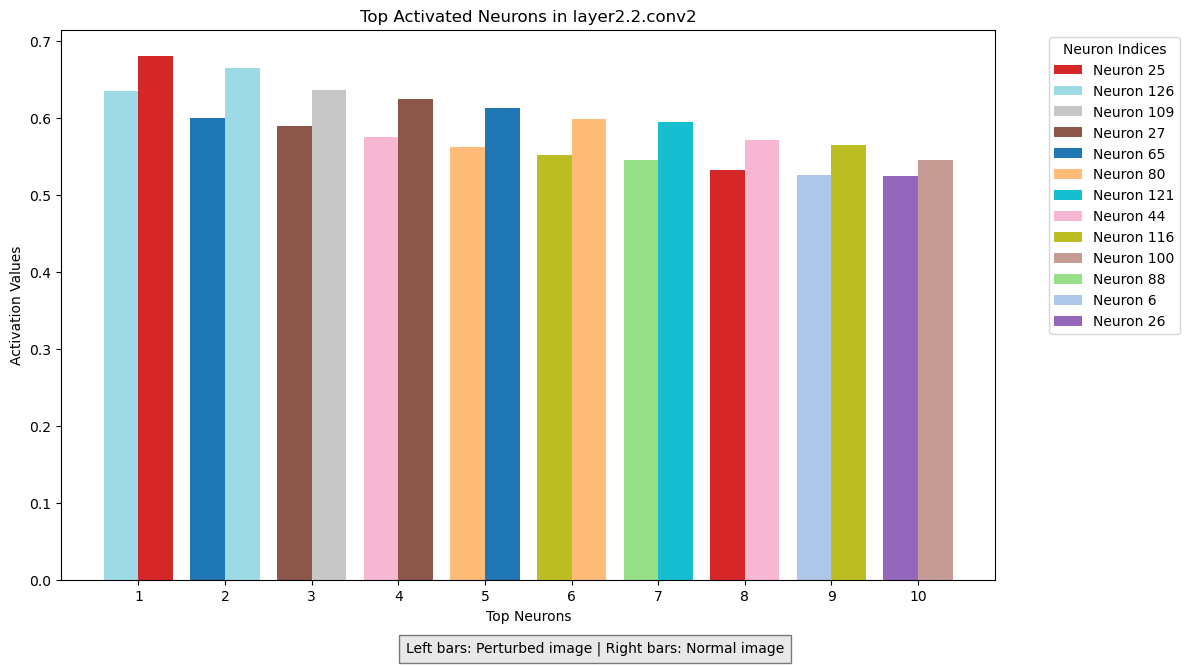

--------------------------------------------------
Layer: layer2.2.conv3 (Neurons: 512)
 - Top 0 n neuron 266: Normal=0.3424, Perturbed=0.3511
 - Top 0 p neuron 266: Normal=0.3424, Perturbed=0.3511
 - Top 1 n neuron 125: Normal=0.3228, Perturbed=0.2790
 - Top 1 p neuron 52: Normal=0.3138, Perturbed=0.3006
 - Top 2 n neuron 52: Normal=0.3138, Perturbed=0.3006
 - Top 2 p neuron 125: Normal=0.3228, Perturbed=0.2790
 - Top 3 n neuron 317: Normal=0.2701, Perturbed=0.2665
 - Top 3 p neuron 317: Normal=0.2701, Perturbed=0.2665
 - Top 4 n neuron 38: Normal=0.2570, Perturbed=0.2277
 - Top 4 p neuron 351: Normal=0.2096, Perturbed=0.2511
 - Top 5 n neuron 408: Normal=0.2485, Perturbed=0.2116
 - Top 5 p neuron 209: Normal=0.2094, Perturbed=0.2416
 - Top 6 n neuron 354: Normal=0.2445, Perturbed=0.2165
 - Top 6 p neuron 38: Normal=0.2570, Perturbed=0.2277
 - Top 7 n neuron 291: Normal=0.2434, Perturbed=0.2227
 - Top 7 p neuron 431: Normal=0.2123, Perturbed=0.2272
 - Top 8 n neuron 124: Normal=0.2424

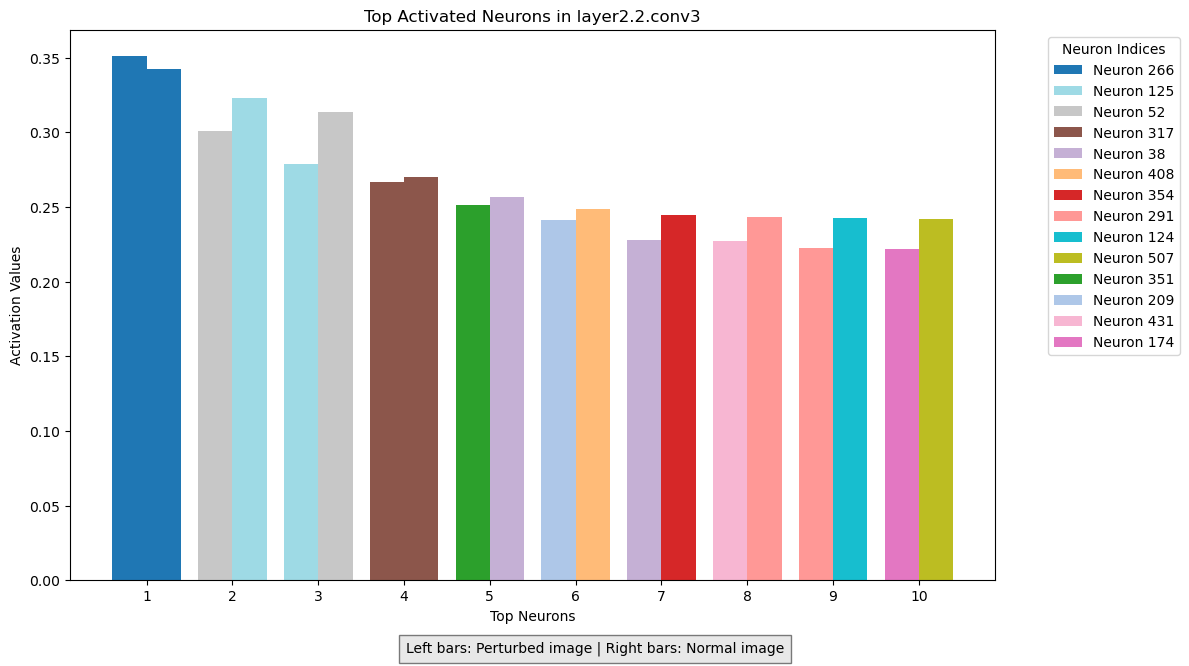

--------------------------------------------------
Layer: layer3.0.conv1 (Neurons: 256)
 - Top 0 n neuron 52: Normal=1.1091, Perturbed=1.0425
 - Top 0 p neuron 219: Normal=0.9807, Perturbed=1.1407
 - Top 1 n neuron 85: Normal=1.0680, Perturbed=0.9267
 - Top 1 p neuron 52: Normal=1.1091, Perturbed=1.0425
 - Top 2 n neuron 74: Normal=1.0478, Perturbed=0.9035
 - Top 2 p neuron 116: Normal=0.8806, Perturbed=0.9847
 - Top 3 n neuron 91: Normal=1.0191, Perturbed=0.7491
 - Top 3 p neuron 130: Normal=0.8916, Perturbed=0.9355
 - Top 4 n neuron 123: Normal=0.9854, Perturbed=0.7066
 - Top 4 p neuron 85: Normal=1.0680, Perturbed=0.9267
 - Top 5 n neuron 219: Normal=0.9807, Perturbed=1.1407
 - Top 5 p neuron 74: Normal=1.0478, Perturbed=0.9035
 - Top 6 n neuron 250: Normal=0.9590, Perturbed=0.7045
 - Top 6 p neuron 43: Normal=0.8674, Perturbed=0.8793
 - Top 7 n neuron 140: Normal=0.9154, Perturbed=0.8435
 - Top 7 p neuron 17: Normal=0.8304, Perturbed=0.8739
 - Top 8 n neuron 71: Normal=0.8923, Pert

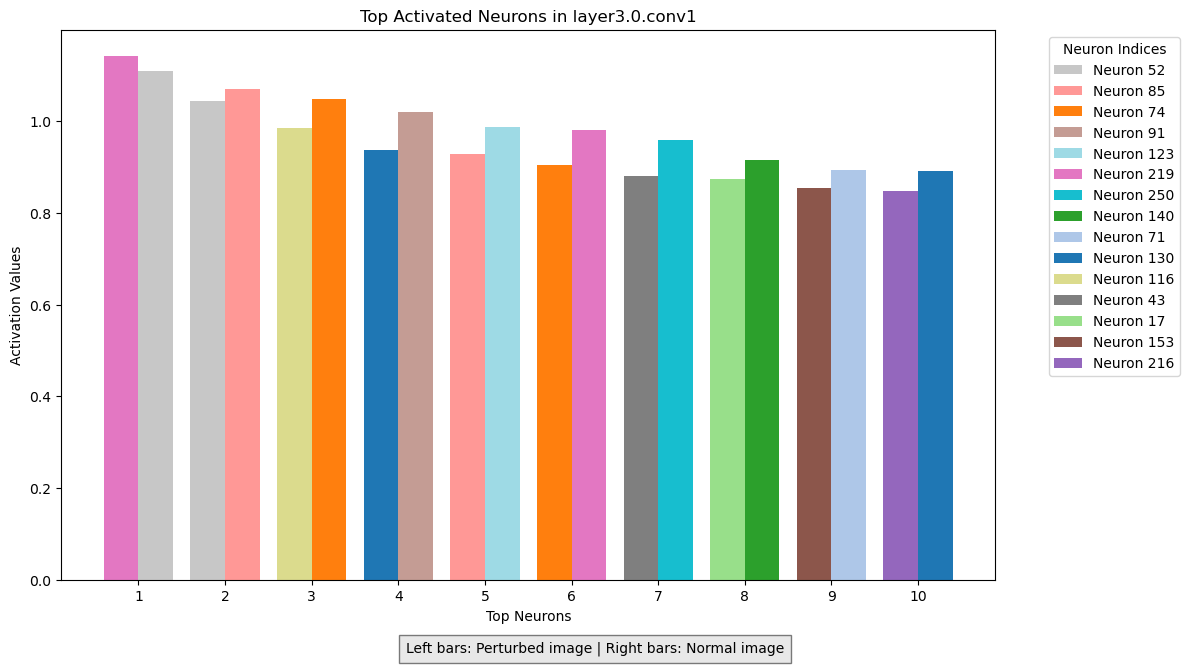

--------------------------------------------------
Layer: layer3.0.conv2 (Neurons: 256)
 - Top 0 n neuron 240: Normal=1.0123, Perturbed=0.8850
 - Top 0 p neuron 240: Normal=1.0123, Perturbed=0.8850
 - Top 1 n neuron 132: Normal=0.8783, Perturbed=0.7331
 - Top 1 p neuron 132: Normal=0.8783, Perturbed=0.7331
 - Top 2 n neuron 81: Normal=0.7657, Perturbed=0.7131
 - Top 2 p neuron 211: Normal=0.5639, Perturbed=0.7202
 - Top 3 n neuron 248: Normal=0.7507, Perturbed=0.4689
 - Top 3 p neuron 81: Normal=0.7657, Perturbed=0.7131
 - Top 4 n neuron 188: Normal=0.7474, Perturbed=0.6471
 - Top 4 p neuron 102: Normal=0.6223, Perturbed=0.6728
 - Top 5 n neuron 73: Normal=0.7347, Perturbed=0.6237
 - Top 5 p neuron 241: Normal=0.5103, Perturbed=0.6692
 - Top 6 n neuron 144: Normal=0.7134, Perturbed=0.6301
 - Top 6 p neuron 198: Normal=0.6562, Perturbed=0.6651
 - Top 7 n neuron 237: Normal=0.7010, Perturbed=0.5325
 - Top 7 p neuron 255: Normal=0.4667, Perturbed=0.6617
 - Top 8 n neuron 15: Normal=0.6992

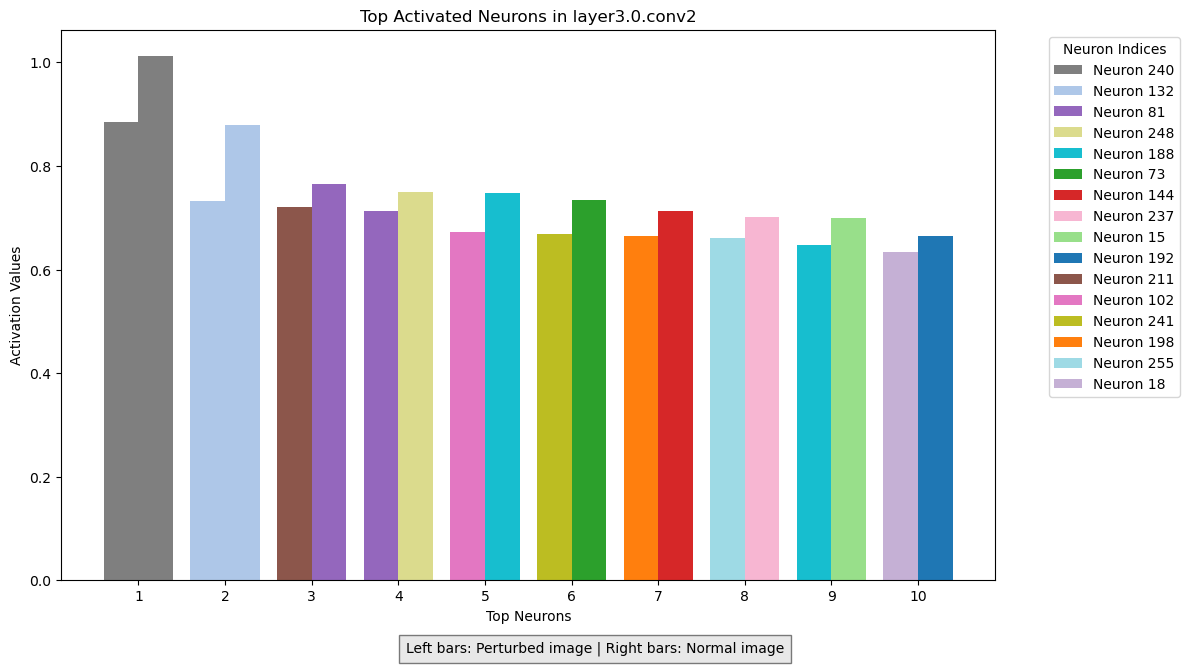

--------------------------------------------------
Layer: layer3.0.conv3 (Neurons: 1024)
 - Top 0 n neuron 74: Normal=0.4510, Perturbed=0.4164
 - Top 0 p neuron 74: Normal=0.4510, Perturbed=0.4164
 - Top 1 n neuron 614: Normal=0.4373, Perturbed=0.3777
 - Top 1 p neuron 430: Normal=0.4131, Perturbed=0.4157
 - Top 2 n neuron 92: Normal=0.4157, Perturbed=0.3361
 - Top 2 p neuron 818: Normal=0.3685, Perturbed=0.4092
 - Top 3 n neuron 430: Normal=0.4131, Perturbed=0.4157
 - Top 3 p neuron 477: Normal=0.3777, Perturbed=0.4064
 - Top 4 n neuron 477: Normal=0.3777, Perturbed=0.4064
 - Top 4 p neuron 614: Normal=0.4373, Perturbed=0.3777
 - Top 5 n neuron 818: Normal=0.3685, Perturbed=0.4092
 - Top 5 p neuron 815: Normal=0.3664, Perturbed=0.3646
 - Top 6 n neuron 815: Normal=0.3664, Perturbed=0.3646
 - Top 6 p neuron 9: Normal=0.3355, Perturbed=0.3581
 - Top 7 n neuron 103: Normal=0.3440, Perturbed=0.3525
 - Top 7 p neuron 14: Normal=0.3377, Perturbed=0.3580
 - Top 8 n neuron 729: Normal=0.3387,

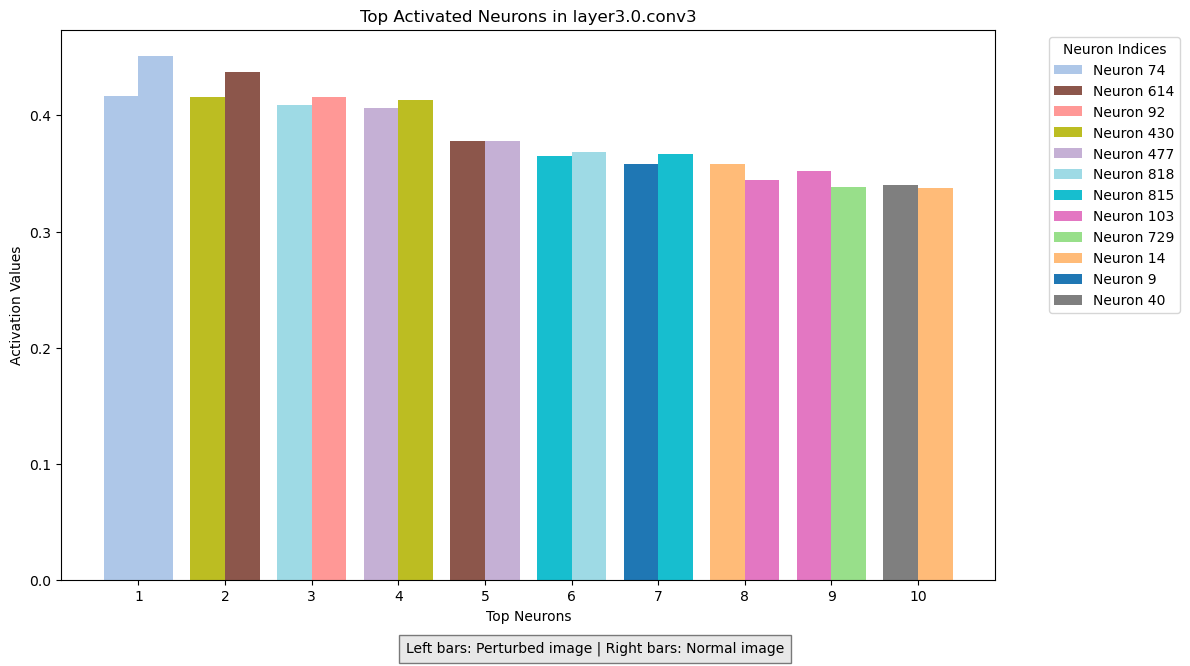

--------------------------------------------------
Layer: layer3.1.conv1 (Neurons: 256)
 - Top 0 n neuron 204: Normal=1.2132, Perturbed=1.1009
 - Top 0 p neuron 204: Normal=1.2132, Perturbed=1.1009
 - Top 1 n neuron 24: Normal=0.9374, Perturbed=0.9677
 - Top 1 p neuron 24: Normal=0.9374, Perturbed=0.9677
 - Top 2 n neuron 7: Normal=0.9214, Perturbed=0.7352
 - Top 2 p neuron 135: Normal=0.6872, Perturbed=0.8103
 - Top 3 n neuron 177: Normal=0.8222, Perturbed=0.5439
 - Top 3 p neuron 7: Normal=0.9214, Perturbed=0.7352
 - Top 4 n neuron 169: Normal=0.7144, Perturbed=0.7082
 - Top 4 p neuron 169: Normal=0.7144, Perturbed=0.7082
 - Top 5 n neuron 143: Normal=0.7129, Perturbed=0.6610
 - Top 5 p neuron 144: Normal=0.6943, Perturbed=0.6631
 - Top 6 n neuron 144: Normal=0.6943, Perturbed=0.6631
 - Top 6 p neuron 143: Normal=0.7129, Perturbed=0.6610
 - Top 7 n neuron 135: Normal=0.6872, Perturbed=0.8103
 - Top 7 p neuron 160: Normal=0.6795, Perturbed=0.5923
 - Top 8 n neuron 160: Normal=0.6795, 

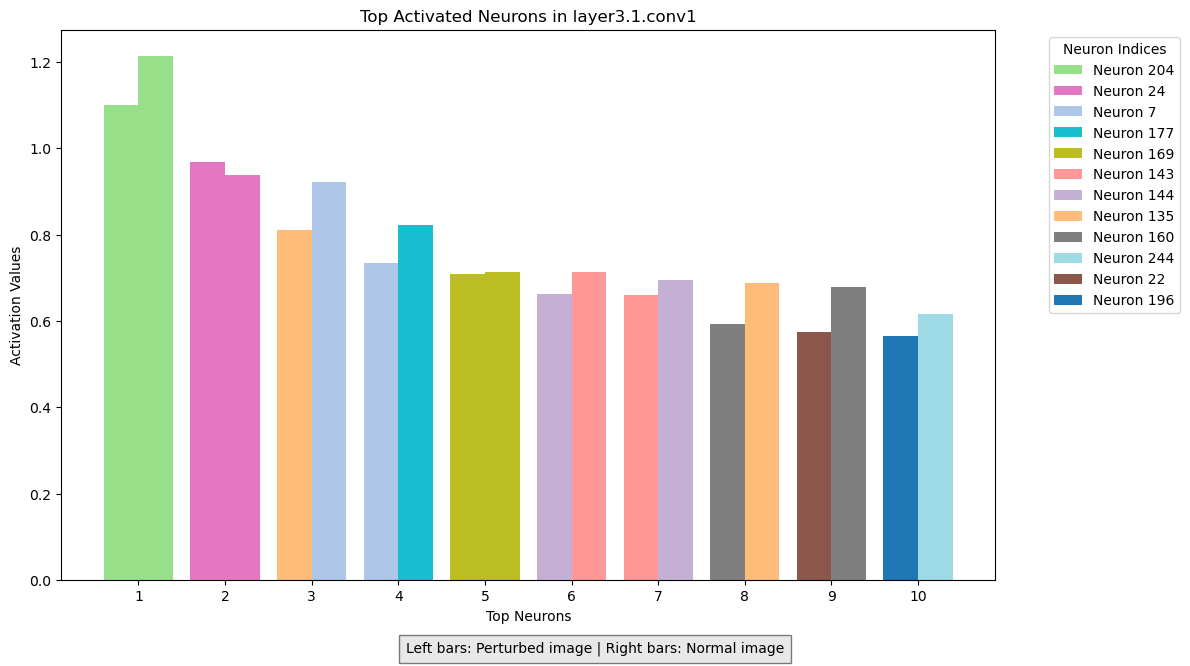

--------------------------------------------------
Layer: layer3.1.conv2 (Neurons: 256)
 - Top 0 n neuron 116: Normal=0.9212, Perturbed=0.8985
 - Top 0 p neuron 116: Normal=0.9212, Perturbed=0.8985
 - Top 1 n neuron 28: Normal=0.8848, Perturbed=0.8521
 - Top 1 p neuron 28: Normal=0.8848, Perturbed=0.8521
 - Top 2 n neuron 7: Normal=0.7527, Perturbed=0.7252
 - Top 2 p neuron 7: Normal=0.7527, Perturbed=0.7252
 - Top 3 n neuron 141: Normal=0.6470, Perturbed=0.6737
 - Top 3 p neuron 141: Normal=0.6470, Perturbed=0.6737
 - Top 4 n neuron 11: Normal=0.6389, Perturbed=0.6704
 - Top 4 p neuron 11: Normal=0.6389, Perturbed=0.6704
 - Top 5 n neuron 55: Normal=0.6356, Perturbed=0.5500
 - Top 5 p neuron 86: Normal=0.6094, Perturbed=0.5997
 - Top 6 n neuron 86: Normal=0.6094, Perturbed=0.5997
 - Top 6 p neuron 77: Normal=0.5591, Perturbed=0.5905
 - Top 7 n neuron 79: Normal=0.6067, Perturbed=0.5567
 - Top 7 p neuron 154: Normal=0.5105, Perturbed=0.5771
 - Top 8 n neuron 30: Normal=0.5818, Perturbe

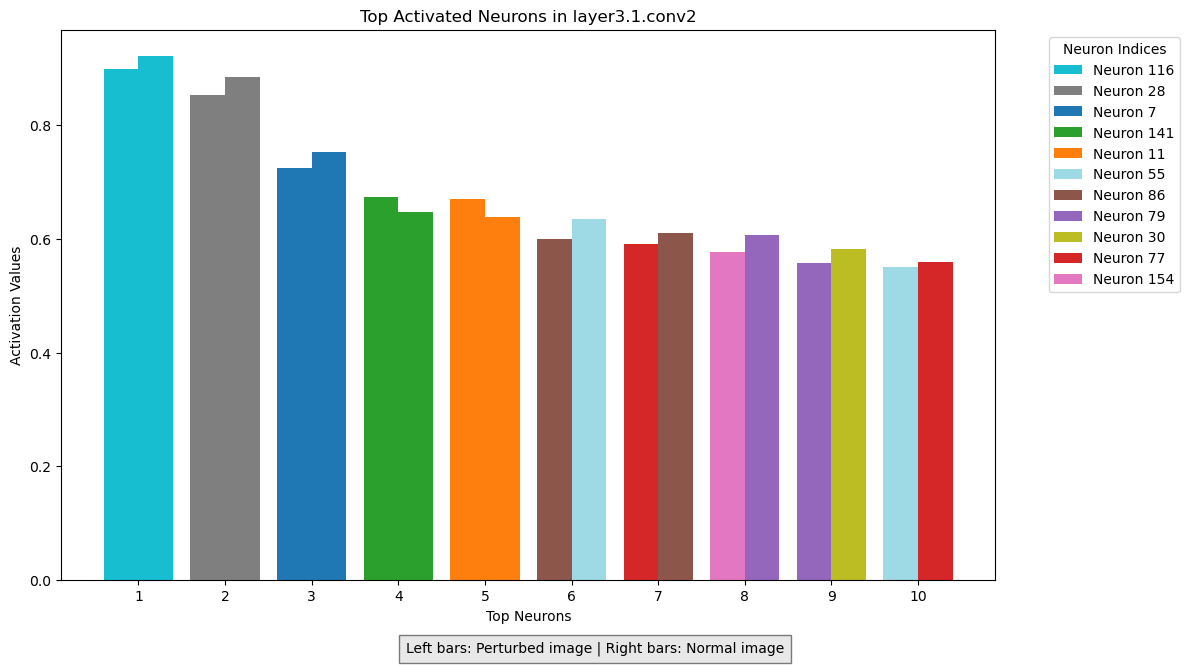

--------------------------------------------------
Layer: layer3.1.conv3 (Neurons: 1024)
 - Top 0 n neuron 74: Normal=0.4749, Perturbed=0.4780
 - Top 0 p neuron 74: Normal=0.4749, Perturbed=0.4780
 - Top 1 n neuron 157: Normal=0.3209, Perturbed=0.3397
 - Top 1 p neuron 157: Normal=0.3209, Perturbed=0.3397
 - Top 2 n neuron 437: Normal=0.3203, Perturbed=0.2867
 - Top 2 p neuron 854: Normal=0.2717, Perturbed=0.3287
 - Top 3 n neuron 854: Normal=0.2717, Perturbed=0.3287
 - Top 3 p neuron 437: Normal=0.3203, Perturbed=0.2867
 - Top 4 n neuron 761: Normal=0.2605, Perturbed=0.2749
 - Top 4 p neuron 761: Normal=0.2605, Perturbed=0.2749
 - Top 5 n neuron 976: Normal=0.2408, Perturbed=0.2533
 - Top 5 p neuron 976: Normal=0.2408, Perturbed=0.2533
 - Top 6 n neuron 571: Normal=0.2325, Perturbed=0.2082
 - Top 6 p neuron 225: Normal=0.2230, Perturbed=0.2231
 - Top 7 n neuron 185: Normal=0.2322, Perturbed=0.2167
 - Top 7 p neuron 185: Normal=0.2322, Perturbed=0.2167
 - Top 8 n neuron 225: Normal=0.2

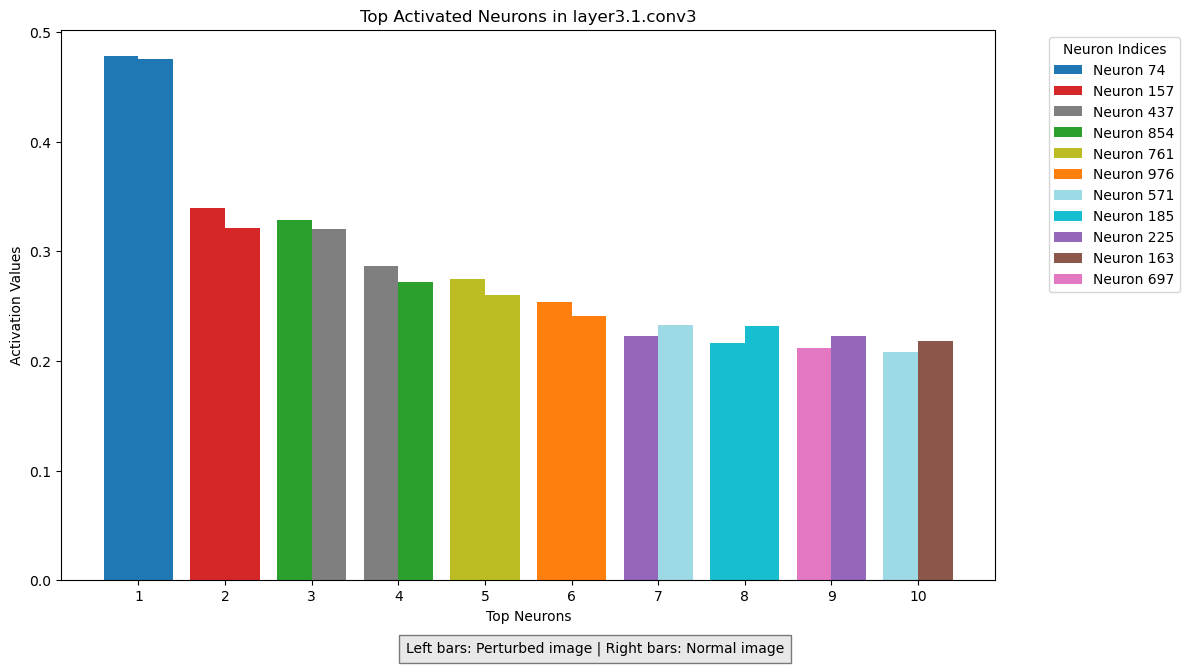

--------------------------------------------------
Layer: layer3.2.conv1 (Neurons: 256)
 - Top 0 n neuron 82: Normal=0.8014, Perturbed=0.8932
 - Top 0 p neuron 82: Normal=0.8014, Perturbed=0.8932
 - Top 1 n neuron 198: Normal=0.6475, Perturbed=0.6536
 - Top 1 p neuron 198: Normal=0.6475, Perturbed=0.6536
 - Top 2 n neuron 89: Normal=0.6016, Perturbed=0.5318
 - Top 2 p neuron 164: Normal=0.5542, Perturbed=0.5749
 - Top 3 n neuron 38: Normal=0.5712, Perturbed=0.4994
 - Top 3 p neuron 234: Normal=0.4809, Perturbed=0.5572
 - Top 4 n neuron 164: Normal=0.5542, Perturbed=0.5749
 - Top 4 p neuron 89: Normal=0.6016, Perturbed=0.5318
 - Top 5 n neuron 210: Normal=0.5317, Perturbed=0.5111
 - Top 5 p neuron 41: Normal=0.5068, Perturbed=0.5175
 - Top 6 n neuron 131: Normal=0.5313, Perturbed=0.4948
 - Top 6 p neuron 210: Normal=0.5317, Perturbed=0.5111
 - Top 7 n neuron 104: Normal=0.5110, Perturbed=0.4794
 - Top 7 p neuron 81: Normal=0.4592, Perturbed=0.5056
 - Top 8 n neuron 41: Normal=0.5068, Pe

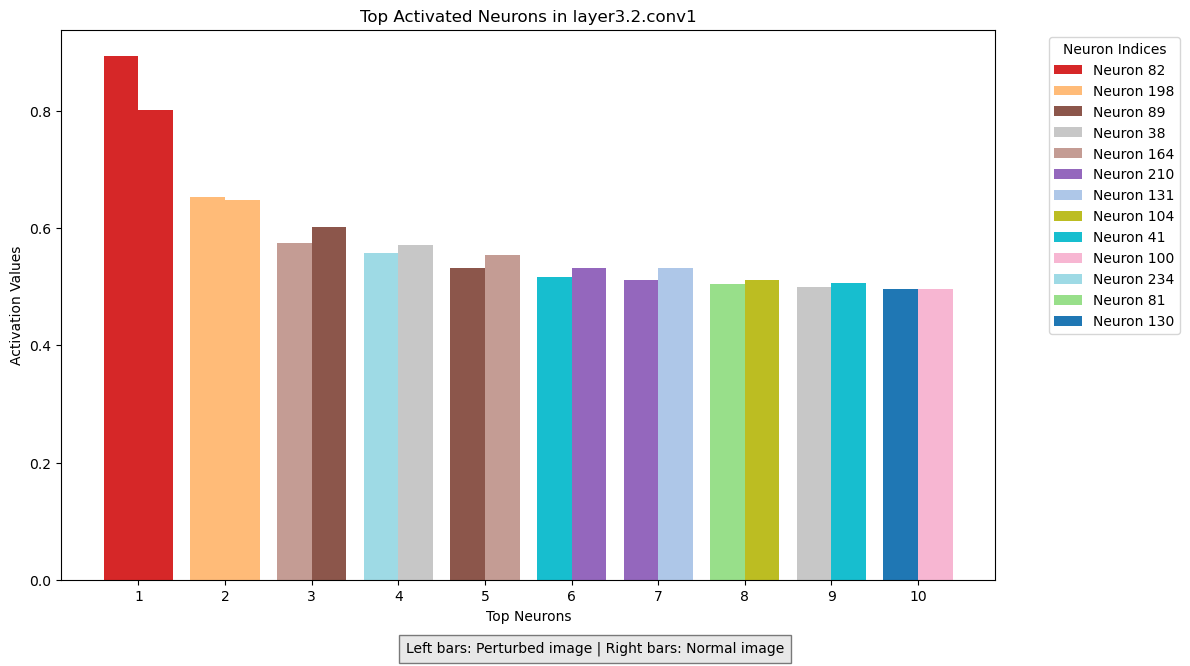

--------------------------------------------------
Layer: layer3.2.conv2 (Neurons: 256)
 - Top 0 n neuron 94: Normal=0.6621, Perturbed=0.5106
 - Top 0 p neuron 210: Normal=0.5988, Perturbed=0.5822
 - Top 1 n neuron 210: Normal=0.5988, Perturbed=0.5822
 - Top 1 p neuron 79: Normal=0.5310, Perturbed=0.5381
 - Top 2 n neuron 79: Normal=0.5310, Perturbed=0.5381
 - Top 2 p neuron 94: Normal=0.6621, Perturbed=0.5106
 - Top 3 n neuron 35: Normal=0.4825, Perturbed=0.4791
 - Top 3 p neuron 35: Normal=0.4825, Perturbed=0.4791
 - Top 4 n neuron 80: Normal=0.4599, Perturbed=0.4067
 - Top 4 p neuron 17: Normal=0.3798, Perturbed=0.4409
 - Top 5 n neuron 115: Normal=0.4269, Perturbed=0.3835
 - Top 5 p neuron 32: Normal=0.3779, Perturbed=0.4296
 - Top 6 n neuron 139: Normal=0.4203, Perturbed=0.4189
 - Top 6 p neuron 139: Normal=0.4203, Perturbed=0.4189
 - Top 7 n neuron 10: Normal=0.4019, Perturbed=0.4175
 - Top 7 p neuron 10: Normal=0.4019, Perturbed=0.4175
 - Top 8 n neuron 188: Normal=0.3995, Pertu

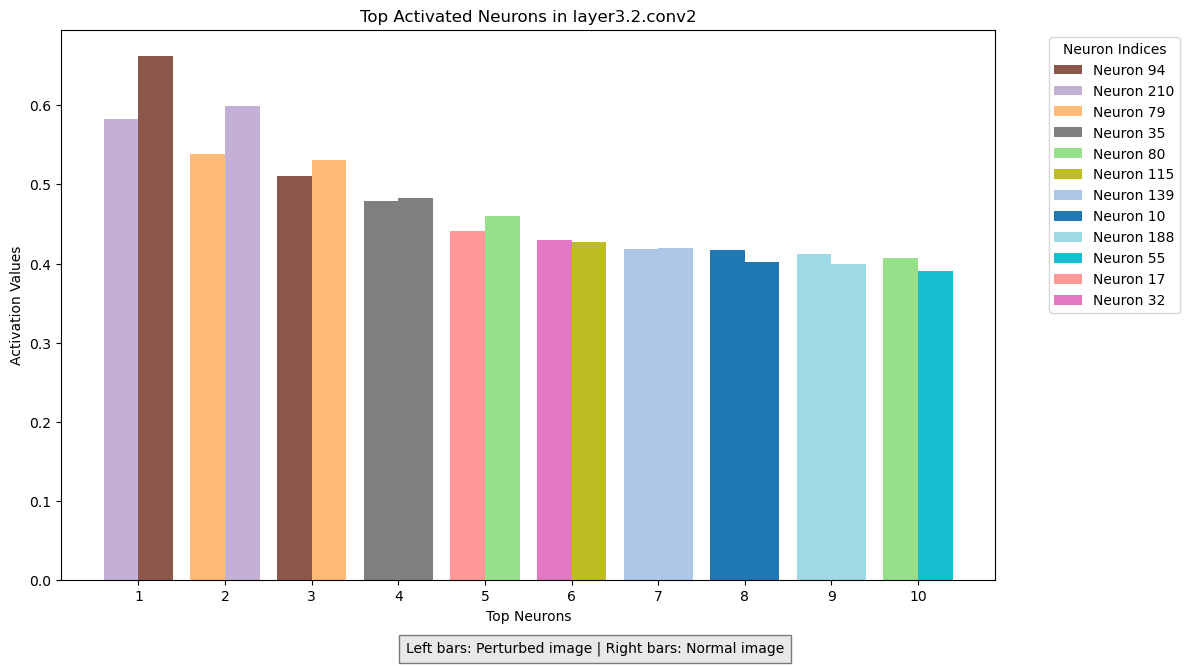

--------------------------------------------------
Layer: layer3.2.conv3 (Neurons: 1024)
 - Top 0 n neuron 437: Normal=0.2514, Perturbed=0.2917
 - Top 0 p neuron 437: Normal=0.2514, Perturbed=0.2917
 - Top 1 n neuron 658: Normal=0.2094, Perturbed=0.2272
 - Top 1 p neuron 658: Normal=0.2094, Perturbed=0.2272
 - Top 2 n neuron 7: Normal=0.2078, Perturbed=0.1672
 - Top 2 p neuron 613: Normal=0.1676, Perturbed=0.2105
 - Top 3 n neuron 122: Normal=0.1884, Perturbed=0.1854
 - Top 3 p neuron 367: Normal=0.1552, Perturbed=0.1992
 - Top 4 n neuron 34: Normal=0.1822, Perturbed=0.1702
 - Top 4 p neuron 157: Normal=0.1610, Perturbed=0.1920
 - Top 5 n neuron 191: Normal=0.1796, Perturbed=0.1505
 - Top 5 p neuron 969: Normal=0.1651, Perturbed=0.1908
 - Top 6 n neuron 982: Normal=0.1775, Perturbed=0.1754
 - Top 6 p neuron 31: Normal=0.1707, Perturbed=0.1864
 - Top 7 n neuron 410: Normal=0.1760, Perturbed=0.1755
 - Top 7 p neuron 122: Normal=0.1884, Perturbed=0.1854
 - Top 8 n neuron 31: Normal=0.1707

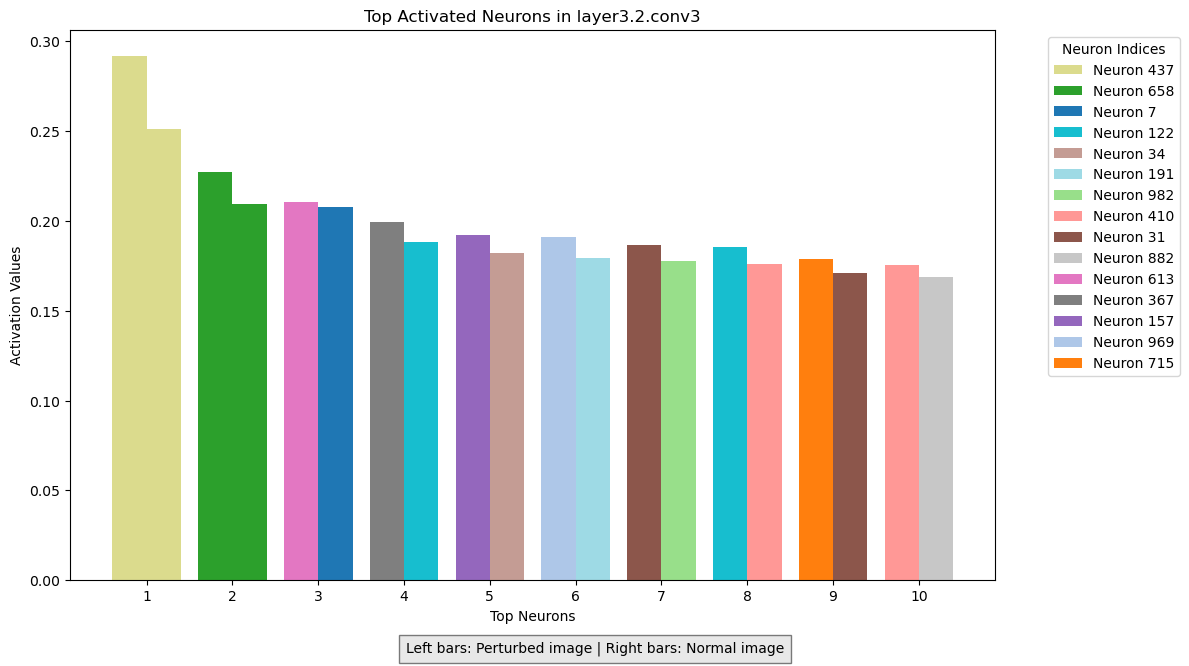

--------------------------------------------------
Layer: layer4.0.conv1 (Neurons: 512)
 - Top 0 n neuron 233: Normal=1.2222, Perturbed=1.2983
 - Top 0 p neuron 233: Normal=1.2222, Perturbed=1.2983
 - Top 1 n neuron 114: Normal=0.5986, Perturbed=0.6616
 - Top 1 p neuron 376: Normal=0.2955, Perturbed=0.7055
 - Top 2 n neuron 361: Normal=0.5806, Perturbed=0.4544
 - Top 2 p neuron 114: Normal=0.5986, Perturbed=0.6616
 - Top 3 n neuron 115: Normal=0.5006, Perturbed=0.4795
 - Top 3 p neuron 501: Normal=0.5000, Perturbed=0.5618
 - Top 4 n neuron 501: Normal=0.5000, Perturbed=0.5618
 - Top 4 p neuron 350: Normal=0.3872, Perturbed=0.5416
 - Top 5 n neuron 441: Normal=0.4941, Perturbed=0.4636
 - Top 5 p neuron 358: Normal=0.4354, Perturbed=0.5399
 - Top 6 n neuron 478: Normal=0.4822, Perturbed=0.3242
 - Top 6 p neuron 324: Normal=0.4572, Perturbed=0.5281
 - Top 7 n neuron 49: Normal=0.4798, Perturbed=0.4916
 - Top 7 p neuron 98: Normal=0.4404, Perturbed=0.5198
 - Top 8 n neuron 504: Normal=0.47

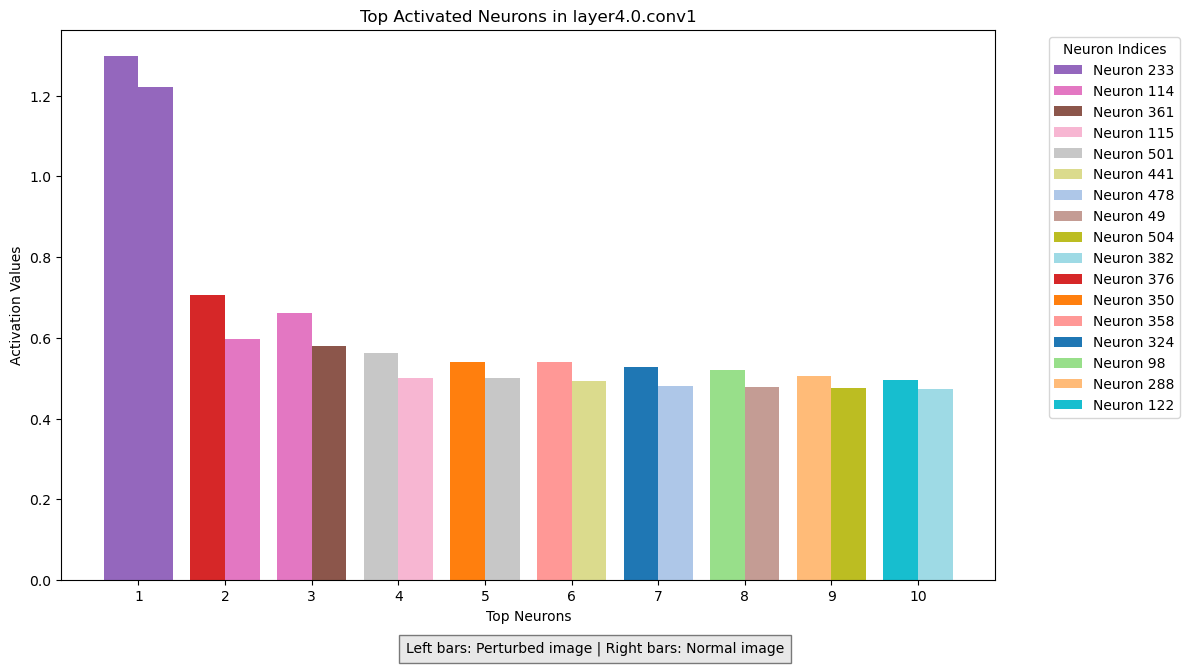

--------------------------------------------------
Layer: layer4.0.conv2 (Neurons: 512)
 - Top 0 n neuron 94: Normal=2.4566, Perturbed=2.8704
 - Top 0 p neuron 94: Normal=2.4566, Perturbed=2.8704
 - Top 1 n neuron 205: Normal=0.5790, Perturbed=0.4175
 - Top 1 p neuron 261: Normal=0.4678, Perturbed=0.5997
 - Top 2 n neuron 401: Normal=0.4958, Perturbed=0.3873
 - Top 2 p neuron 289: Normal=0.3929, Perturbed=0.5146
 - Top 3 n neuron 141: Normal=0.4743, Perturbed=0.4409
 - Top 3 p neuron 379: Normal=0.3092, Perturbed=0.5072
 - Top 4 n neuron 261: Normal=0.4678, Perturbed=0.5997
 - Top 4 p neuron 333: Normal=0.3133, Perturbed=0.4869
 - Top 5 n neuron 63: Normal=0.4630, Perturbed=0.2967
 - Top 5 p neuron 5: Normal=0.3957, Perturbed=0.4783
 - Top 6 n neuron 130: Normal=0.4537, Perturbed=0.3142
 - Top 6 p neuron 318: Normal=0.3585, Perturbed=0.4667
 - Top 7 n neuron 441: Normal=0.4447, Perturbed=0.4329
 - Top 7 p neuron 479: Normal=0.1863, Perturbed=0.4640
 - Top 8 n neuron 173: Normal=0.4395,

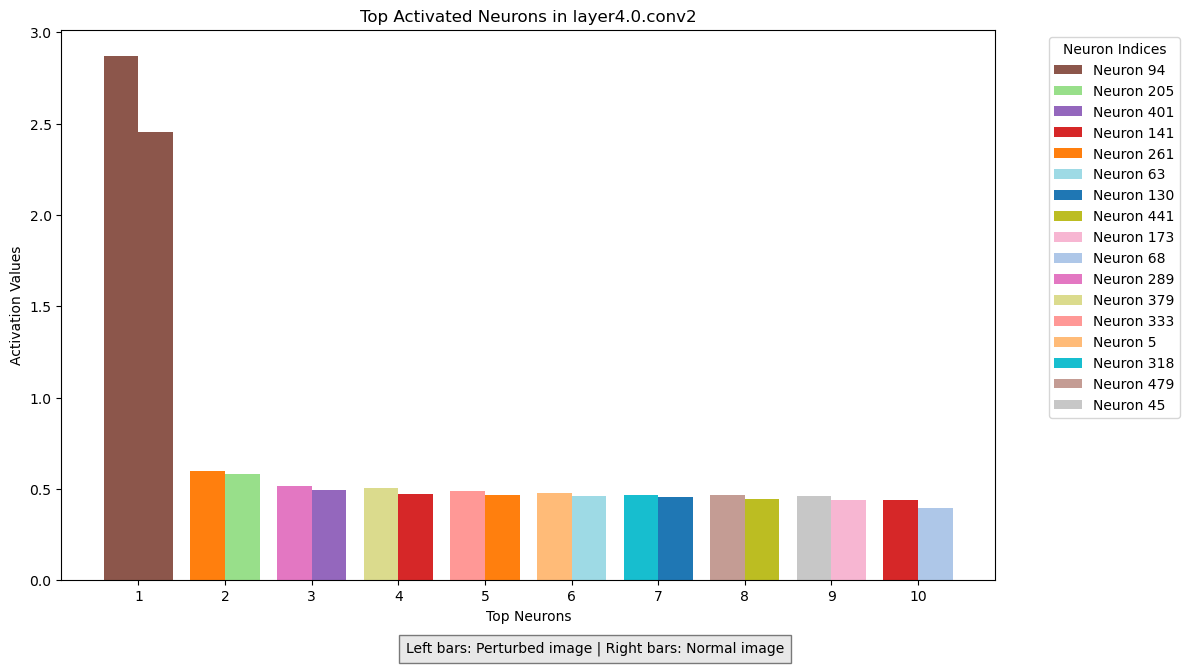

--------------------------------------------------
Layer: layer4.0.conv3 (Neurons: 2048)
 - Top 0 n neuron 476: Normal=0.8031, Perturbed=0.8992
 - Top 0 p neuron 476: Normal=0.8031, Perturbed=0.8992
 - Top 1 n neuron 729: Normal=0.4321, Perturbed=0.5169
 - Top 1 p neuron 729: Normal=0.4321, Perturbed=0.5169
 - Top 2 n neuron 1261: Normal=0.3042, Perturbed=0.2983
 - Top 2 p neuron 1064: Normal=0.1924, Perturbed=0.3228
 - Top 3 n neuron 459: Normal=0.2908, Perturbed=0.3122
 - Top 3 p neuron 459: Normal=0.2908, Perturbed=0.3122
 - Top 4 n neuron 465: Normal=0.2854, Perturbed=0.2442
 - Top 4 p neuron 1359: Normal=0.2746, Perturbed=0.3085
 - Top 5 n neuron 1359: Normal=0.2746, Perturbed=0.3085
 - Top 5 p neuron 1783: Normal=0.1298, Perturbed=0.2990
 - Top 6 n neuron 617: Normal=0.2562, Perturbed=0.2981
 - Top 6 p neuron 1261: Normal=0.3042, Perturbed=0.2983
 - Top 7 n neuron 1957: Normal=0.2449, Perturbed=0.2502
 - Top 7 p neuron 617: Normal=0.2562, Perturbed=0.2981
 - Top 8 n neuron 407: N

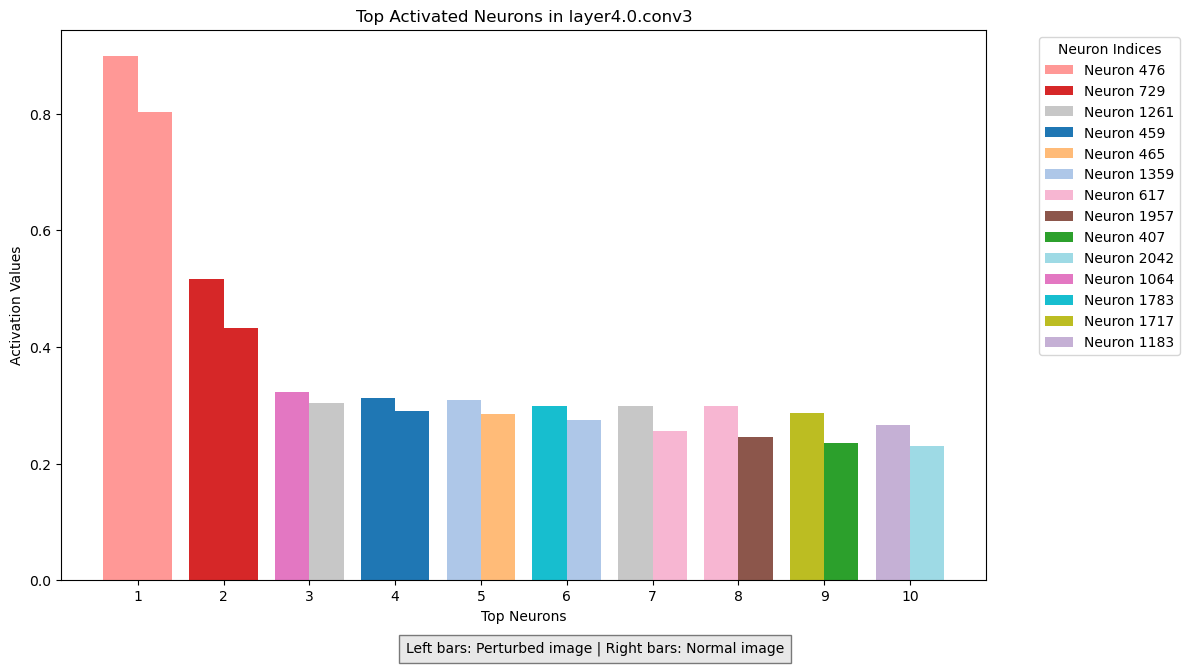

--------------------------------------------------
Layer: layer4.1.conv1 (Neurons: 512)
 - Top 0 n neuron 295: Normal=2.8519, Perturbed=2.0943
 - Top 0 p neuron 387: Normal=2.5516, Perturbed=2.3472
 - Top 1 n neuron 387: Normal=2.5516, Perturbed=2.3472
 - Top 1 p neuron 77: Normal=1.0293, Perturbed=2.1596
 - Top 2 n neuron 458: Normal=1.9833, Perturbed=1.0902
 - Top 2 p neuron 295: Normal=2.8519, Perturbed=2.0943
 - Top 3 n neuron 448: Normal=1.8386, Perturbed=1.5551
 - Top 3 p neuron 393: Normal=0.9416, Perturbed=1.9655
 - Top 4 n neuron 122: Normal=1.7247, Perturbed=1.6741
 - Top 4 p neuron 442: Normal=1.3519, Perturbed=1.8705
 - Top 5 n neuron 21: Normal=1.6106, Perturbed=1.2000
 - Top 5 p neuron 498: Normal=0.5234, Perturbed=1.7909
 - Top 6 n neuron 473: Normal=1.6106, Perturbed=1.0583
 - Top 6 p neuron 145: Normal=0.6222, Perturbed=1.7562
 - Top 7 n neuron 28: Normal=1.5402, Perturbed=1.3739
 - Top 7 p neuron 64: Normal=0.5565, Perturbed=1.6986
 - Top 8 n neuron 357: Normal=1.5116

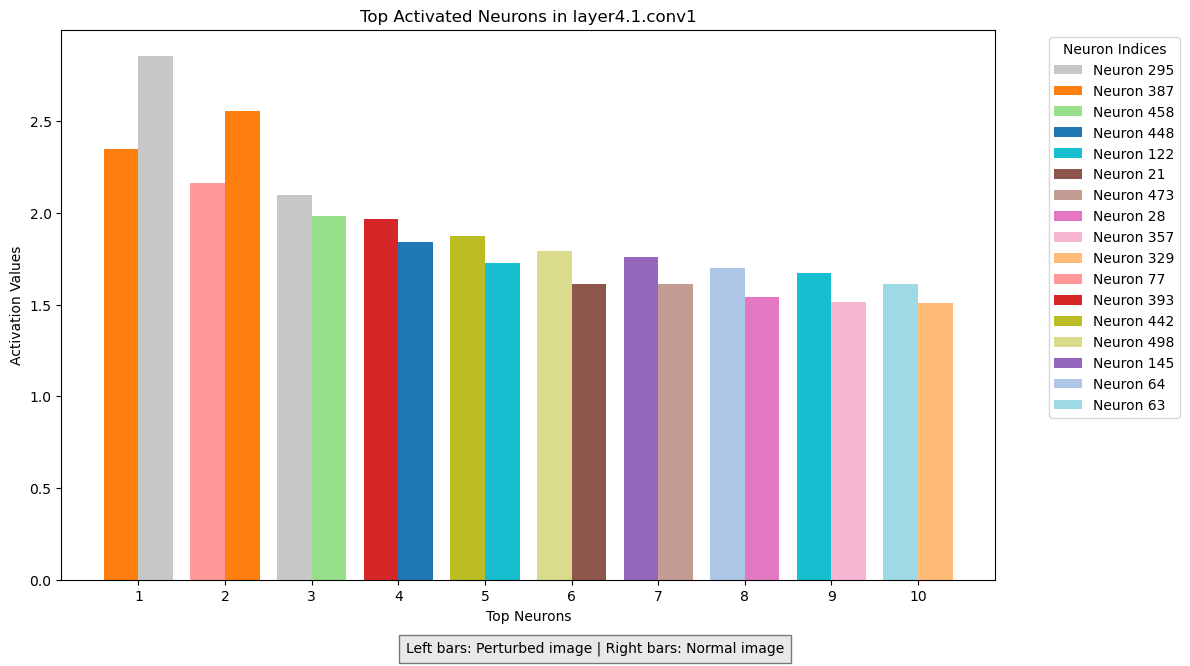

--------------------------------------------------
Layer: layer4.1.conv2 (Neurons: 512)
 - Top 0 n neuron 469: Normal=0.9444, Perturbed=0.9563
 - Top 0 p neuron 469: Normal=0.9444, Perturbed=0.9563
 - Top 1 n neuron 52: Normal=0.6739, Perturbed=0.6664
 - Top 1 p neuron 18: Normal=0.2231, Perturbed=0.8190
 - Top 2 n neuron 63: Normal=0.4795, Perturbed=0.4010
 - Top 2 p neuron 52: Normal=0.6739, Perturbed=0.6664
 - Top 3 n neuron 500: Normal=0.3541, Perturbed=0.2499
 - Top 3 p neuron 86: Normal=0.1592, Perturbed=0.5597
 - Top 4 n neuron 214: Normal=0.3339, Perturbed=0.0652
 - Top 4 p neuron 419: Normal=0.2714, Perturbed=0.4264
 - Top 5 n neuron 381: Normal=0.3230, Perturbed=0.2481
 - Top 5 p neuron 63: Normal=0.4795, Perturbed=0.4010
 - Top 6 n neuron 405: Normal=0.3148, Perturbed=0.2272
 - Top 6 p neuron 15: Normal=0.2196, Perturbed=0.3893
 - Top 7 n neuron 315: Normal=0.3101, Perturbed=0.3750
 - Top 7 p neuron 510: Normal=0.2449, Perturbed=0.3892
 - Top 8 n neuron 298: Normal=0.3018, P

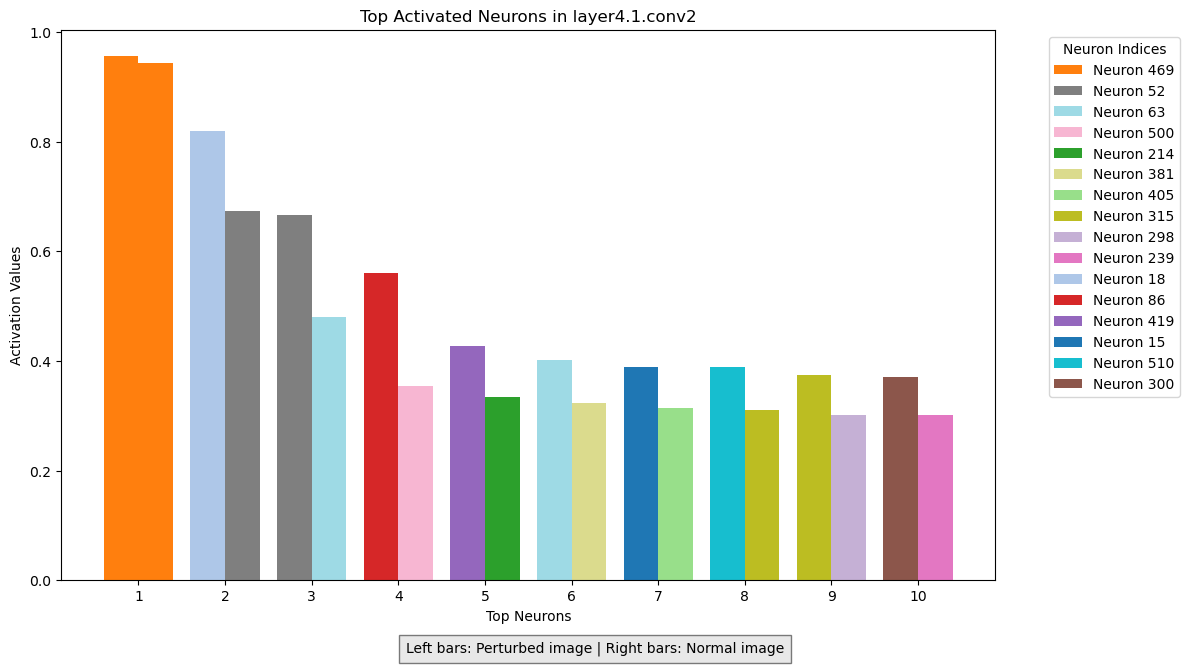

--------------------------------------------------
Layer: layer4.1.conv3 (Neurons: 2048)
 - Top 0 n neuron 1261: Normal=0.2627, Perturbed=0.2410
 - Top 0 p neuron 1690: Normal=0.1841, Perturbed=0.2963
 - Top 1 n neuron 1957: Normal=0.2420, Perturbed=0.2897
 - Top 1 p neuron 1957: Normal=0.2420, Perturbed=0.2897
 - Top 2 n neuron 707: Normal=0.2329, Perturbed=0.1438
 - Top 2 p neuron 1000: Normal=0.1365, Perturbed=0.2826
 - Top 3 n neuron 1924: Normal=0.2318, Perturbed=0.2268
 - Top 3 p neuron 1783: Normal=0.0850, Perturbed=0.2518
 - Top 4 n neuron 442: Normal=0.1884, Perturbed=0.1918
 - Top 4 p neuron 697: Normal=0.1009, Perturbed=0.2434
 - Top 5 n neuron 1690: Normal=0.1841, Perturbed=0.2963
 - Top 5 p neuron 1381: Normal=0.0457, Perturbed=0.2433
 - Top 6 n neuron 700: Normal=0.1786, Perturbed=0.1761
 - Top 6 p neuron 1261: Normal=0.2627, Perturbed=0.2410
 - Top 7 n neuron 310: Normal=0.1739, Perturbed=0.1659
 - Top 7 p neuron 1924: Normal=0.2318, Perturbed=0.2268
 - Top 8 n neuron 19

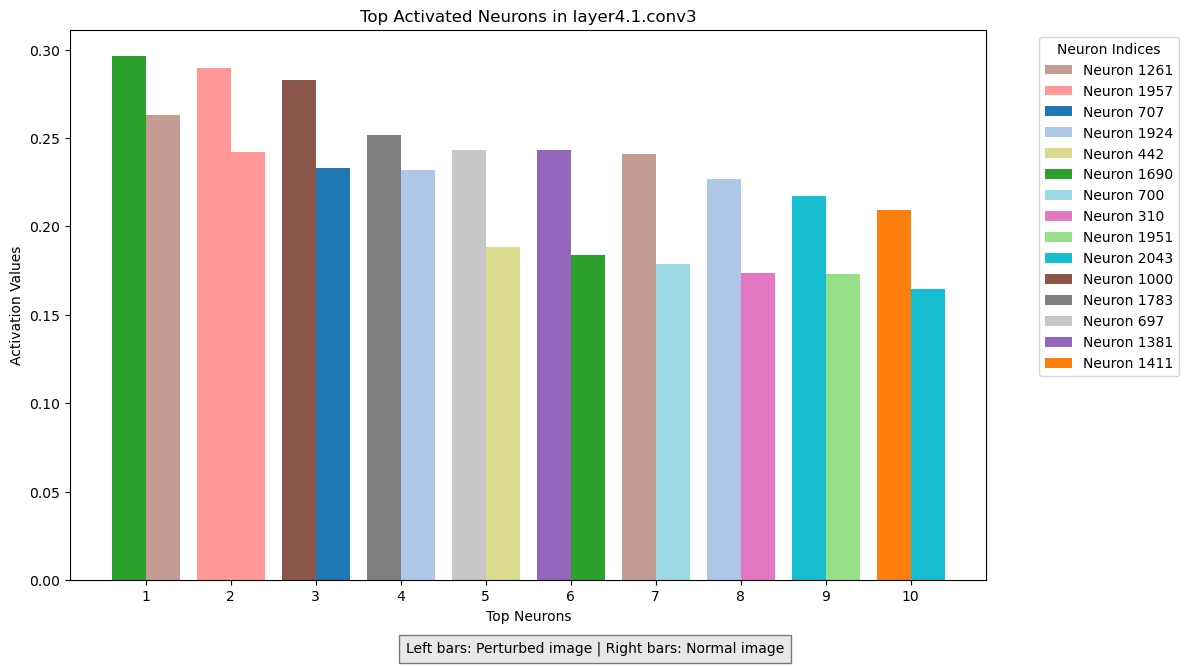

--------------------------------------------------
Layer: layer4.2.conv1 (Neurons: 512)
 - Top 0 n neuron 370: Normal=4.8218, Perturbed=5.8005
 - Top 0 p neuron 370: Normal=4.8218, Perturbed=5.8005
 - Top 1 n neuron 339: Normal=2.2055, Perturbed=2.4998
 - Top 1 p neuron 276: Normal=1.9606, Perturbed=3.3838
 - Top 2 n neuron 325: Normal=2.1512, Perturbed=1.6688
 - Top 2 p neuron 437: Normal=1.0268, Perturbed=3.1385
 - Top 3 n neuron 265: Normal=2.0635, Perturbed=0.9014
 - Top 3 p neuron 337: Normal=1.0900, Perturbed=2.9698
 - Top 4 n neuron 464: Normal=2.0347, Perturbed=1.5054
 - Top 4 p neuron 16: Normal=2.0180, Perturbed=2.7050
 - Top 5 n neuron 16: Normal=2.0180, Perturbed=2.7050
 - Top 5 p neuron 354: Normal=0.8314, Perturbed=2.5572
 - Top 6 n neuron 192: Normal=1.9894, Perturbed=2.0305
 - Top 6 p neuron 339: Normal=2.2055, Perturbed=2.4998
 - Top 7 n neuron 276: Normal=1.9606, Perturbed=3.3838
 - Top 7 p neuron 197: Normal=1.1855, Perturbed=2.4766
 - Top 8 n neuron 250: Normal=1.93

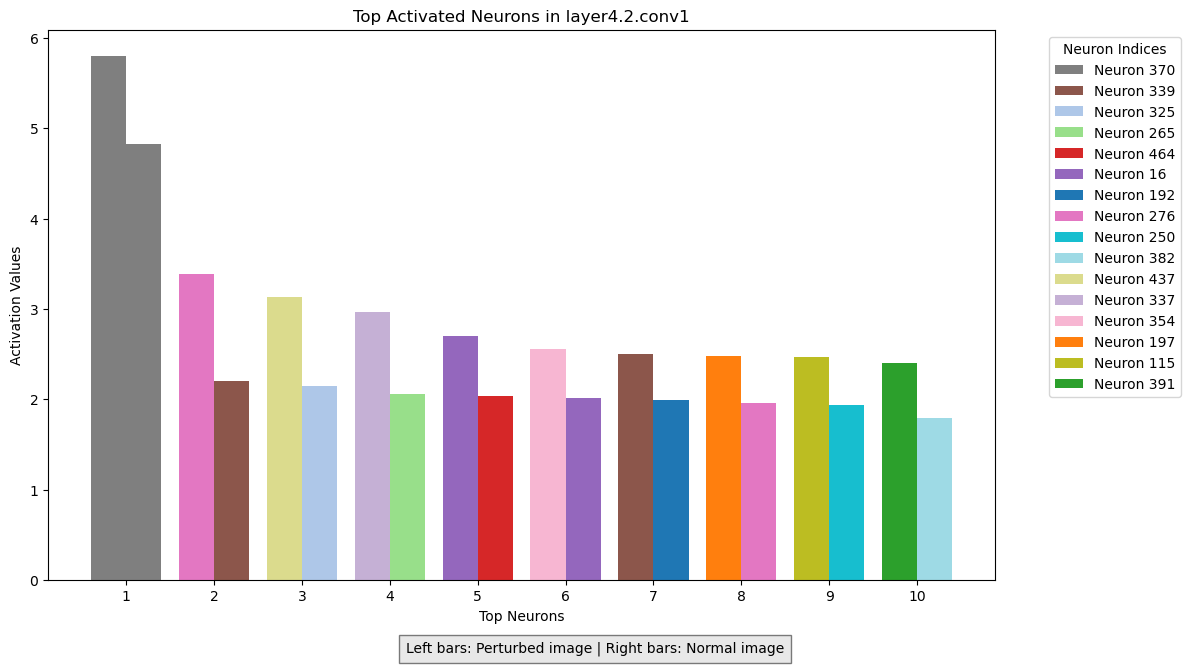

--------------------------------------------------
Layer: layer4.2.conv2 (Neurons: 512)
 - Top 0 n neuron 262: Normal=0.3324, Perturbed=0.2117
 - Top 0 p neuron 18: Normal=0.0672, Perturbed=0.7741
 - Top 1 n neuron 297: Normal=0.3257, Perturbed=0.1048
 - Top 1 p neuron 73: Normal=0.2772, Perturbed=0.6658
 - Top 2 n neuron 194: Normal=0.3132, Perturbed=0.1286
 - Top 2 p neuron 11: Normal=0.1473, Perturbed=0.6515
 - Top 3 n neuron 264: Normal=0.3072, Perturbed=0.2496
 - Top 3 p neuron 3: Normal=0.2777, Perturbed=0.6110
 - Top 4 n neuron 93: Normal=0.2900, Perturbed=0.3215
 - Top 4 p neuron 328: Normal=0.0431, Perturbed=0.5043
 - Top 5 n neuron 3: Normal=0.2777, Perturbed=0.6110
 - Top 5 p neuron 330: Normal=-0.0051, Perturbed=0.4980
 - Top 6 n neuron 73: Normal=0.2772, Perturbed=0.6658
 - Top 6 p neuron 314: Normal=0.1005, Perturbed=0.4925
 - Top 7 n neuron 2: Normal=0.2731, Perturbed=0.2723
 - Top 7 p neuron 248: Normal=0.1346, Perturbed=0.4801
 - Top 8 n neuron 499: Normal=0.2594, Pert

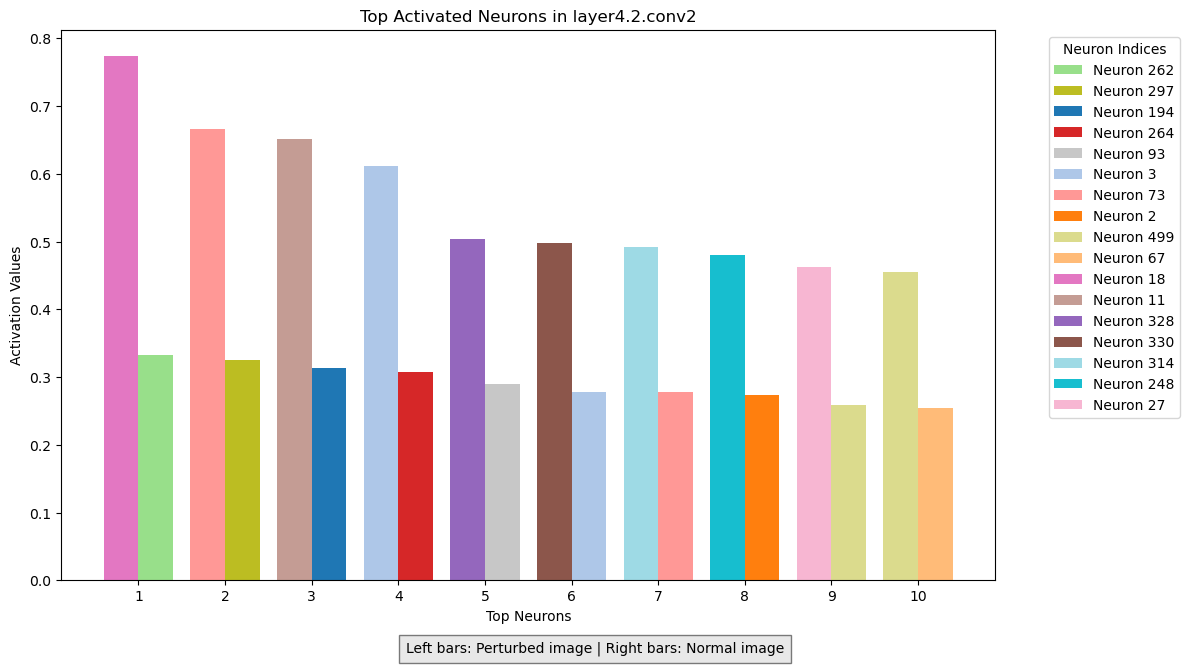

--------------------------------------------------
Layer: layer4.2.conv3 (Neurons: 2048)
 - Top 0 n neuron 383: Normal=0.2149, Perturbed=0.0635
 - Top 0 p neuron 259: Normal=0.0837, Perturbed=0.5311
 - Top 1 n neuron 197: Normal=0.2131, Perturbed=0.0876
 - Top 1 p neuron 1717: Normal=0.0504, Perturbed=0.4833
 - Top 2 n neuron 120: Normal=0.2130, Perturbed=0.0180
 - Top 2 p neuron 228: Normal=0.0458, Perturbed=0.4630
 - Top 3 n neuron 179: Normal=0.2059, Perturbed=0.1197
 - Top 3 p neuron 663: Normal=0.1146, Perturbed=0.4421
 - Top 4 n neuron 564: Normal=0.2046, Perturbed=0.2388
 - Top 4 p neuron 412: Normal=0.1434, Perturbed=0.4308
 - Top 5 n neuron 599: Normal=0.2010, Perturbed=0.1514
 - Top 5 p neuron 934: Normal=0.1169, Perturbed=0.4136
 - Top 6 n neuron 237: Normal=0.1989, Perturbed=0.2521
 - Top 6 p neuron 1380: Normal=0.0936, Perturbed=0.4042
 - Top 7 n neuron 1401: Normal=0.1973, Perturbed=0.1275
 - Top 7 p neuron 1783: Normal=0.0701, Perturbed=0.3575
 - Top 8 n neuron 174: Norm

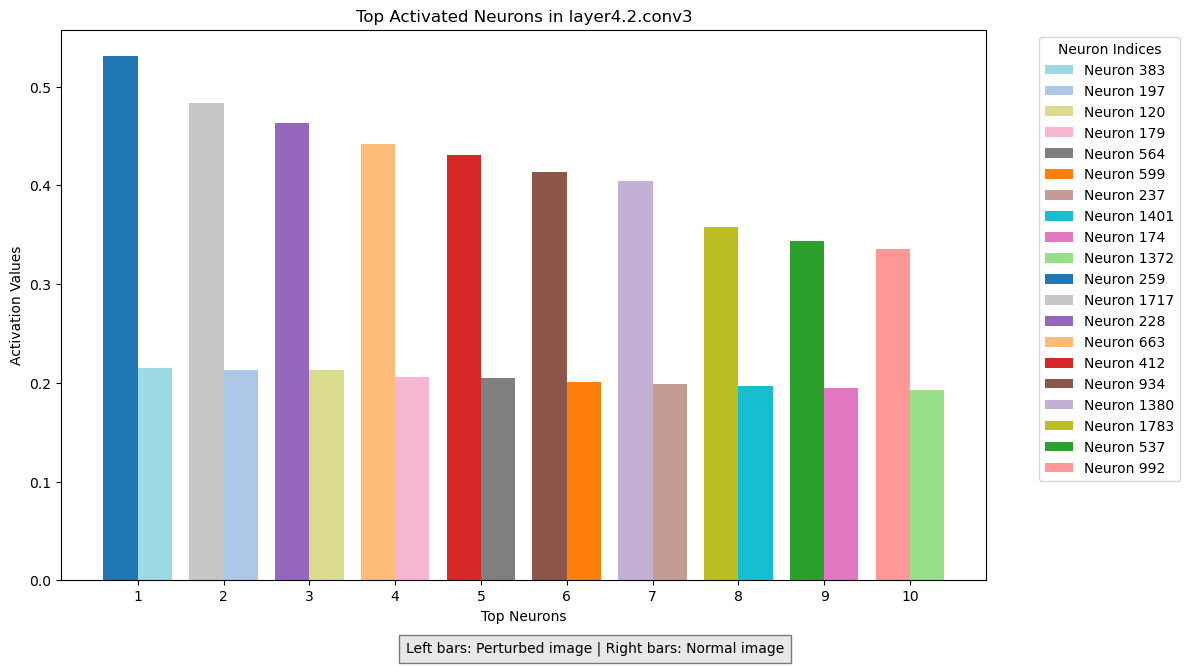

--------------------------------------------------


In [ ]:
# Get activations
normal_activations = get_layer_activations(model, images[0].unsqueeze(0), target_layers)
perturbed_activations = get_layer_activations(model, images[1].unsqueeze(0), target_layers)

# Compare activations
print("\nComparing Top Activated Neurons for Normal vs Perturbed Image\n")
for layer in target_layers:
    num_neurons = normal_activations[layer].shape[1]
    print(f"Layer: {layer} (Neurons: {num_neurons})")

    normal_vals, normal_idx = get_top_neurons(normal_activations[layer])
    perturbed_vals, perturbed_idx = get_top_neurons(perturbed_activations[layer])

    normal_in_perturbed = get_neuron(normal_activations[layer], perturbed_idx)
    perturbed_in_normal = get_neuron(perturbed_activations[layer], normal_idx)

    for i in range(len(normal_idx)):
        print(f" - Top {i} n neuron {normal_idx[i]}: Normal={normal_vals[i]:.4f}, Perturbed={perturbed_in_normal[i]:.4f}")
        print(f" - Top {i} p neuron {perturbed_idx[i]}: Normal={normal_in_perturbed[i]:.4f}, Perturbed={perturbed_vals[i]:.4f}")

    plot_top_neurons(layer, normal_vals, normal_idx, perturbed_vals, perturbed_idx)
    print("-" * 50)


In [5]:
def analyze_neurons_across_all_layers(group_a_dict, group_b_dict, normalize=True, 
                                     group_a_name="Group A", group_b_name="Group B",
                                     group_a_color='#1f77b4', group_b_color='#ff7f0e',
                                     top_n=10):
    """
    Analyze neuron activations across ResNet layers, comparing two customizable groups.
    
    Parameters:
    -----------
    group_a_dict : dict
        Dictionary mapping image names to file paths for Group A
    group_b_dict : dict
        Dictionary mapping image names to file paths for Group B
    normalize : bool, default=True
        Whether to apply z-score normalization by layer
    group_a_name : str, default="Group A" 
        Display name for Group A in visualization
    group_b_name : str, default="Group B"
        Display name for Group B in visualization
    group_a_color : str, default='#1f77b4'
        Hex color code for Group A bars
    group_b_color : str, default='#ff7f0e'
        Hex color code for Group B bars
    top_n : int, default=10
        Number of top neurons to return and visualize
        
    Returns:
    --------
    list
        List of dictionaries containing information about top neurons
    """
    # Combine image paths
    image_paths = {**group_a_dict, **group_b_dict}
    
    # Create sets of image names for each group for faster lookup
    group_a_images = set(group_a_dict.keys())
    group_b_images = set(group_b_dict.keys())
    
    # Preprocess images
    image_tensors = {}
    for name, path in tqdm(image_paths.items(), desc="Preprocessing images"):
        image_tensors[name] = preprocess_images([path])[0].unsqueeze(0)
    
    # Get activations for all images
    activations = {}
    for name, img in tqdm(image_tensors.items(), desc="Getting activations"):
        activations[name] = get_layer_activations(model, img, target_layers)
    
    # Store neuron activations across all layers
    all_neurons = []
    
    for layer in tqdm(target_layers, desc="Processing layers"):
        # Skip if layer doesn't exist in activations
        if layer not in activations[list(activations.keys())[0]]:
            continue
            
        # Get layer dimensions
        num_neurons = activations[list(activations.keys())[0]][layer].shape[1]
        
        # Process each neuron in this layer
        for idx in tqdm(range(num_neurons), desc=f"Processing neurons in {layer}", leave=False):
            # Get activations across all image types
            neuron_data = {
                'layer': layer,
                'neuron': idx,
            }
            
            # Store activation values for each image type
            for img_type in activations:
                if layer in activations[img_type]:
                    neuron_data[img_type] = activations[img_type][layer][0, idx].item()
            
            # Calculate group activations
            group_a_acts = []
            group_b_acts = []
            
            for img_type, value in neuron_data.items():
                # Skip metadata fields
                if img_type in ['layer', 'neuron', 'group_a_avg', 'group_b_avg', 'raw_diff', 'diff']:
                    continue
                    
                # Assign to appropriate group
                if img_type in group_a_images:
                    group_a_acts.append(value)
                elif img_type in group_b_images:
                    group_b_acts.append(value)

            # Compute means and difference
            neuron_data['group_a_avg'] = np.mean(group_a_acts) if group_a_acts else 0
            neuron_data['group_b_avg'] = np.mean(group_b_acts) if group_b_acts else 0
            neuron_data['raw_diff'] = neuron_data['group_a_avg'] - neuron_data['group_b_avg']
            
            all_neurons.append(neuron_data)

    # Normalize if requested
    if normalize:
        layer_diffs = defaultdict(list)
        for n in all_neurons:
            layer_diffs[n['layer']].append(n['raw_diff'])

        layer_stats = {}
        for layer, diffs in layer_diffs.items():
            layer_stats[layer] = {
                'mean': np.mean(diffs),
                'std': np.std(diffs) if np.std(diffs) > 0 else 1.0
            }

        # Add normalized differences
        for n in all_neurons:
            stats = layer_stats[n['layer']]
            n['diff'] = (n['raw_diff'] - stats['mean']) / stats['std']
    else:
        # Use raw differences directly
        for n in all_neurons:
            n['diff'] = n['raw_diff']

    # Sort and select top neurons using 'diff' field
    top_neurons = sorted(
        [n for n in all_neurons if n['diff'] > 0],
        key=lambda x: x['diff'],
        reverse=True
    )[:top_n]

    # Visualization (updated labels)
    fig, ax = plt.subplots(figsize=(12, 8))

    labels = [f"{n['layer']}:{n['neuron']}" for n in top_neurons]
    group_a = [n['group_a_avg'] for n in top_neurons]
    group_b = [n['group_b_avg'] for n in top_neurons]
    
    x = np.arange(len(labels))
    width = 0.35
    
    # Create bar chart with custom group names and colors
    rects1 = ax.bar(x - width/2, group_a, width, 
                   label=group_a_name, color=group_a_color)
    rects2 = ax.bar(x + width/2, group_b, width, 
                   label=group_b_name, color=group_b_color)
    
    ax.set_ylabel('Activation Value')
    title_suffix = "(Normalized Differences)" if normalize else "(Raw Differences)"
    ax.set_title(f'Top {group_a_name}-Specific Neurons {title_suffix}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend()

    # Add value labels
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width()/2, height),
                        xytext=(0, 3), 
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)
    
    autolabel(rects1)
    autolabel(rects2)

    # Add difference labels
    for i, n in enumerate(top_neurons):
        label = f"Z-score: {n['diff']:.2f}" if normalize else f"Diff: {n['diff']:.2f}"
        ax.annotate(label, 
                   xy=(i, max(n['group_a_avg'], n['group_b_avg']) + 0.1),
                   ha='center', fontsize=8, color='red')
    
    plt.tight_layout()
    plt.show()
    
    return top_neurons


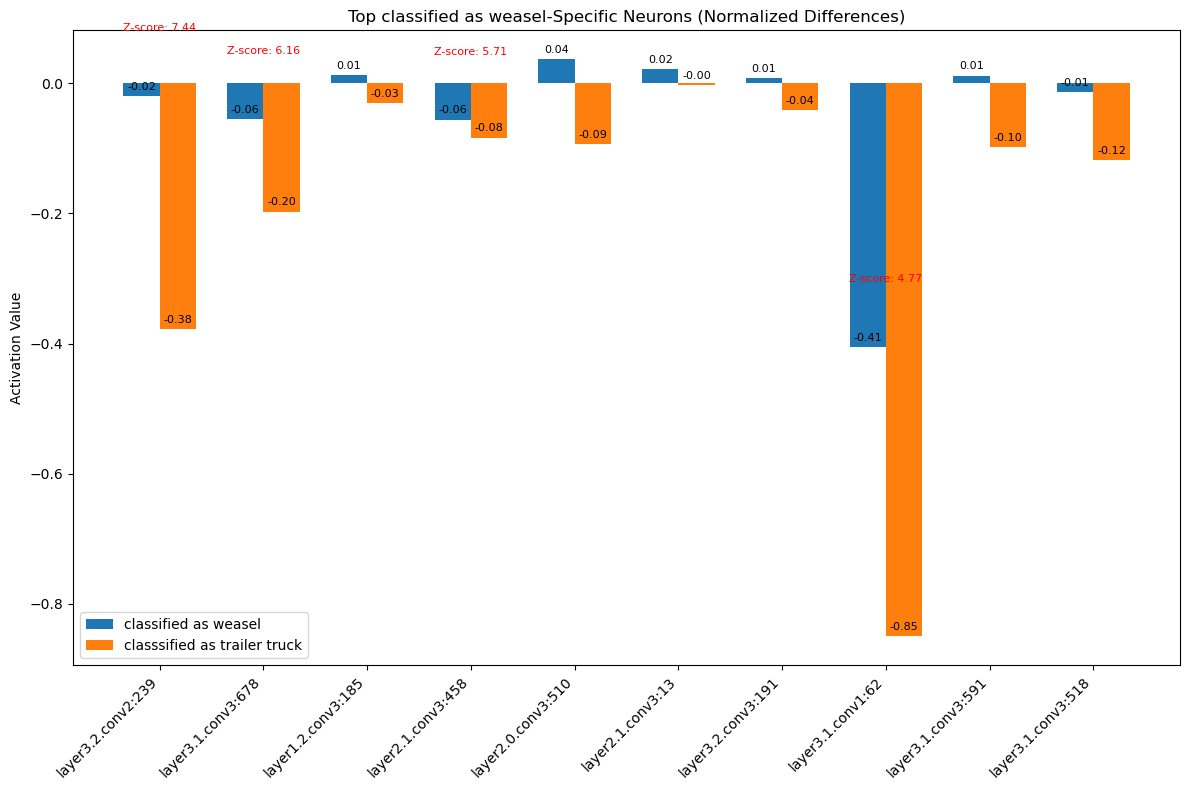

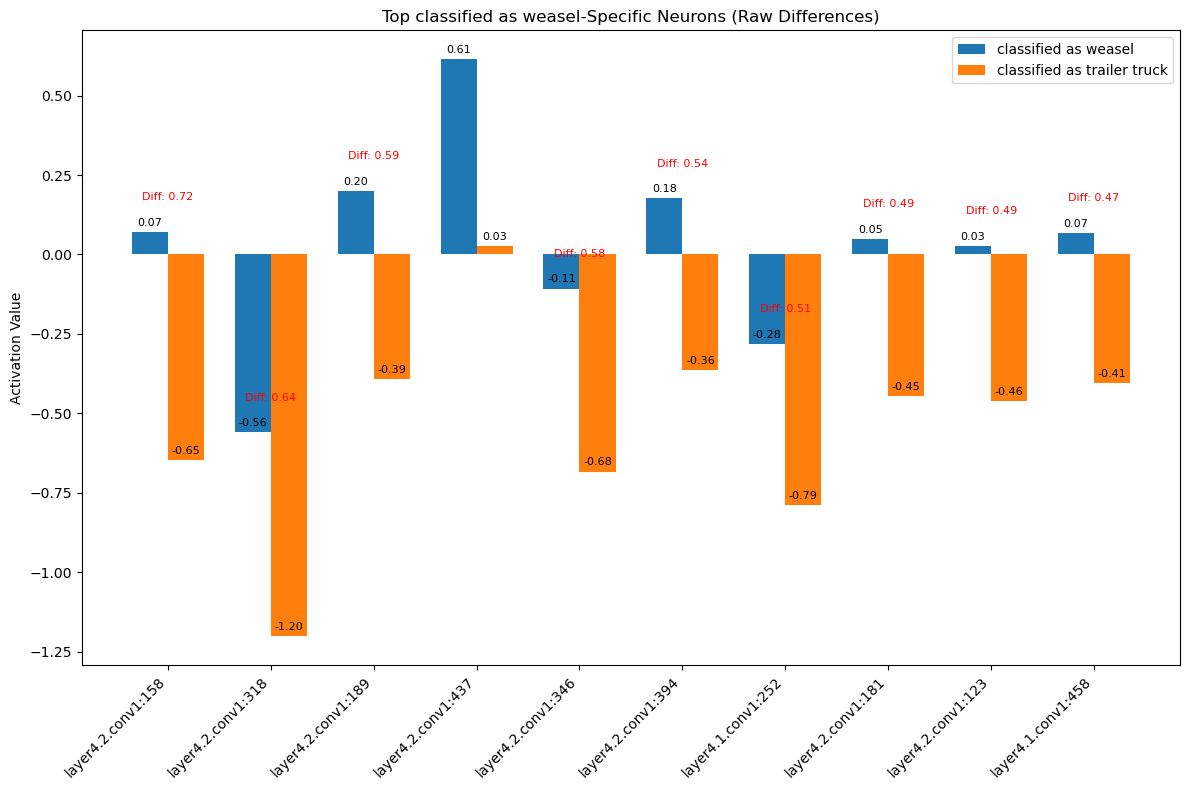

In [5]:
# Define your group dictionaries
weasel_group = {
    "weasel": "Ressources/weasel.jpg",
    "panda_as_weasel": "output/panda_perturbed.jpg"
}

panda_group = {
    "panda": "Ressources/panda.jpg",
    "weasel_as_panda": "output/weasel_as_panda.jpg"
}

truck_group = {
    "truck": "Ressources/trailer_truck.jpg"
    #"weasel_as_truck": "output/weasel_as_truck.jpg"
}

weasel_group = {
    "weasel": "Ressources/weasel.jpg"
    #"panda_as_weasel": "output/truck_as_weasel.jpg"
}

# Run analysis with normalized differences
top_neurons = analyze_neurons_across_all_layers(
    weasel_group,
    truck_group,
     
    group_a_name="classified as weasel", 
    group_b_name="classsified as trailer truck"
)

# Run analysis with raw differences
top_neurons_raw = analyze_neurons_across_all_layers(
    weasel_group,
    truck_group,
    
    normalize=False,
    group_a_name="classified as weasel", 
    group_b_name="classified as trailer truck"
)


In [10]:
# run this cell to download the dataset

url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
output_path = "tiny-imagenet-200.zip"

print("Downloading Tiny ImageNet...")
urllib.request.urlretrieve(url, output_path)
print("Download complete.")

Download complete.


In [ ]:
# run this cell to extract the dataset

val_dir = "tiny-imagenet-200/tiny-imagenet-200/val"
val_images_dir = os.path.join(val_dir, "images")
val_annotations_file = os.path.join(val_dir, "val_annotations.txt")

# Create class folders and move images
with open(val_annotations_file, "r") as f:
    for line in f:
        img, class_id = line.strip().split("\t")[:2]
        class_dir = os.path.join(val_dir, class_id, "images")
        os.makedirs(class_dir, exist_ok=True)
        shutil.move(os.path.join(val_images_dir, img), os.path.join(class_dir, img))

shutil.rmtree(val_images_dir)

In [59]:
# run this cell to download the ImageNet dataset

import requests
import tarfile

def download_and_extract_synsets(synsets, max_images=20):
    """Download and extract ImageNet synsets with error handling"""
    for synset in synsets:
        tar_file = f"{synset}.tar"
        # extract_dir = f"./extracted/{synset}/images"
        extract_dir = f"./tiny-imagenet-200/images-val/{synset}"
        
        # 1. Download with retries and progress
        if not os.path.exists(tar_file):
            print(f"Downloading {synset}...")
            url = f"https://image-net.org/data/winter21_whole/{synset}.tar"
            try:
                with requests.get(url, stream=True, timeout=30) as response:
                    response.raise_for_status()
                    total_size = int(response.headers.get('content-length', 0))
                    
                    with open(tar_file, 'wb') as f, tqdm(
                        desc=tar_file,
                        total=total_size,
                        unit='iB',
                        unit_scale=True,
                        unit_divisor=1024,
                    ) as bar:
                        for chunk in response.iter_content(chunk_size=8192):
                            size = f.write(chunk)
                            bar.update(size)
                print(f"Downloaded {tar_file}")
            except Exception as e:
                print(f"Failed to download {synset}: {str(e)}")
                continue
        
        # 2. Extract with validation
        if os.path.exists(tar_file):
            print(f"Extracting {tar_file}...")
            try:
                # Extract all
                with tarfile.open(tar_file) as tar:
                    tar.extractall(path=extract_dir)
                print(f"Extracted to {extract_dir}")

                # 
                # Keep only max_images
                image_files = [f for f in os.listdir(extract_dir) 
                              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                
                if len(image_files) > max_images:
                    # Delete excess images (keep first max_images)
                    for f in image_files[max_images:]:
                        os.remove(os.path.join(extract_dir, f))
                    print(f"Kept {max_images} images, removed {len(image_files)-max_images}")
                # 

            except (tarfile.TarError, OSError) as e:
                print(f"Extraction failed: {str(e)}")
                os.remove(tar_file)  # Remove corrupt file
        else:
            print(f"Skipping extraction - {tar_file} not found")

# Verified synsets that exist in Winter 2021 release
synsets = [
    'n02111889',  # Samoyed dog
    'n02441942',  # Weasel
    'n02443484',
    'n04467665',  # Trailer truck
    'n03930630'   # Pickup truck
]

download_and_extract_synsets(synsets)


Extracting n02111889.tar...
Extracted to ./tiny-imagenet-200/images-val/n02111889
Kept 20 images, removed 1628
Extracting n02441942.tar...
Extracted to ./tiny-imagenet-200/images-val/n02441942
Kept 20 images, removed 983
Extracting n02443484.tar...
Extracted to ./tiny-imagenet-200/images-val/n02443484
Kept 20 images, removed 979
Extracting n04467665.tar...
Extracted to ./tiny-imagenet-200/images-val/n04467665
Kept 20 images, removed 1280
Extracting n03930630.tar...
Extracted to ./tiny-imagenet-200/images-val/n03930630
Kept 20 images, removed 1423


In [44]:
# Function to extract activations from specified layers in ResNet
def get_layer_activations2(model, images, target_layers):
    activations = {}

    def hook_fn(module, input, output, layer_name):
        # activation.shape -> [batch_size, num_channels, height, width]
        activations[layer_name] = output.detach().mean(dim=[2, 3])
        # activations[layer_name] = output.detach().amax(dim=[2, 3])

    hooks = []
    for name, layer in model.named_modules():
        if name in target_layers:
            hooks.append(layer.register_forward_hook(lambda m, i, o, n=name: hook_fn(m, i, o, n)))

    # Forward pass to store activations
    with torch.no_grad():
        model(images)

    # Remove hooks after use
    for hook in hooks:
        hook.remove()

    return activations

In [53]:
def show_top_neuron_images(model, target_layer, neuron_index, val_dir='./tiny-imagenet-200/val/images/'):
    # Preprocessing steps
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4802, 0.4481, 0.3975], std=[0.2302, 0.2265, 0.2262])
    ])
    
    # Load and preprocess images
    image_paths = [os.path.join(val_dir, f) for f in os.listdir(val_dir) 
                  if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
    images = [transform(Image.open(p).convert('RGB')) for p in image_paths]
    
    # Get activations with progress bar
    activations = []
    for img in tqdm(images, desc="Computing activations"):
        layer_acts = get_layer_activations2(model, img.unsqueeze(0), [target_layer])
        neuron_act = layer_acts[target_layer].flatten()[neuron_index].item()
        activations.append(neuron_act)
    
    # Display original images
    top_indices = np.argsort(activations)[-50:][::-1]
    plt.figure(figsize=(20, 10))
    
    # Denormalization parameters
    mean = torch.tensor([0.4802, 0.4481, 0.3975]).view(3, 1, 1)
    std = torch.tensor([0.2302, 0.2265, 0.2262]).view(3, 1, 1)
    
    for i, idx in enumerate(top_indices):
        plt.subplot(5, 10, i+1)
        # Reverse normalization
        denorm_img = torch.clamp(images[idx] * std + mean, 0, 1)
        plt.imshow(denorm_img.permute(1, 2, 0).numpy())
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Computing activations: 100%|██████████| 10100/10100 [10:55<00:00, 15.40it/s]


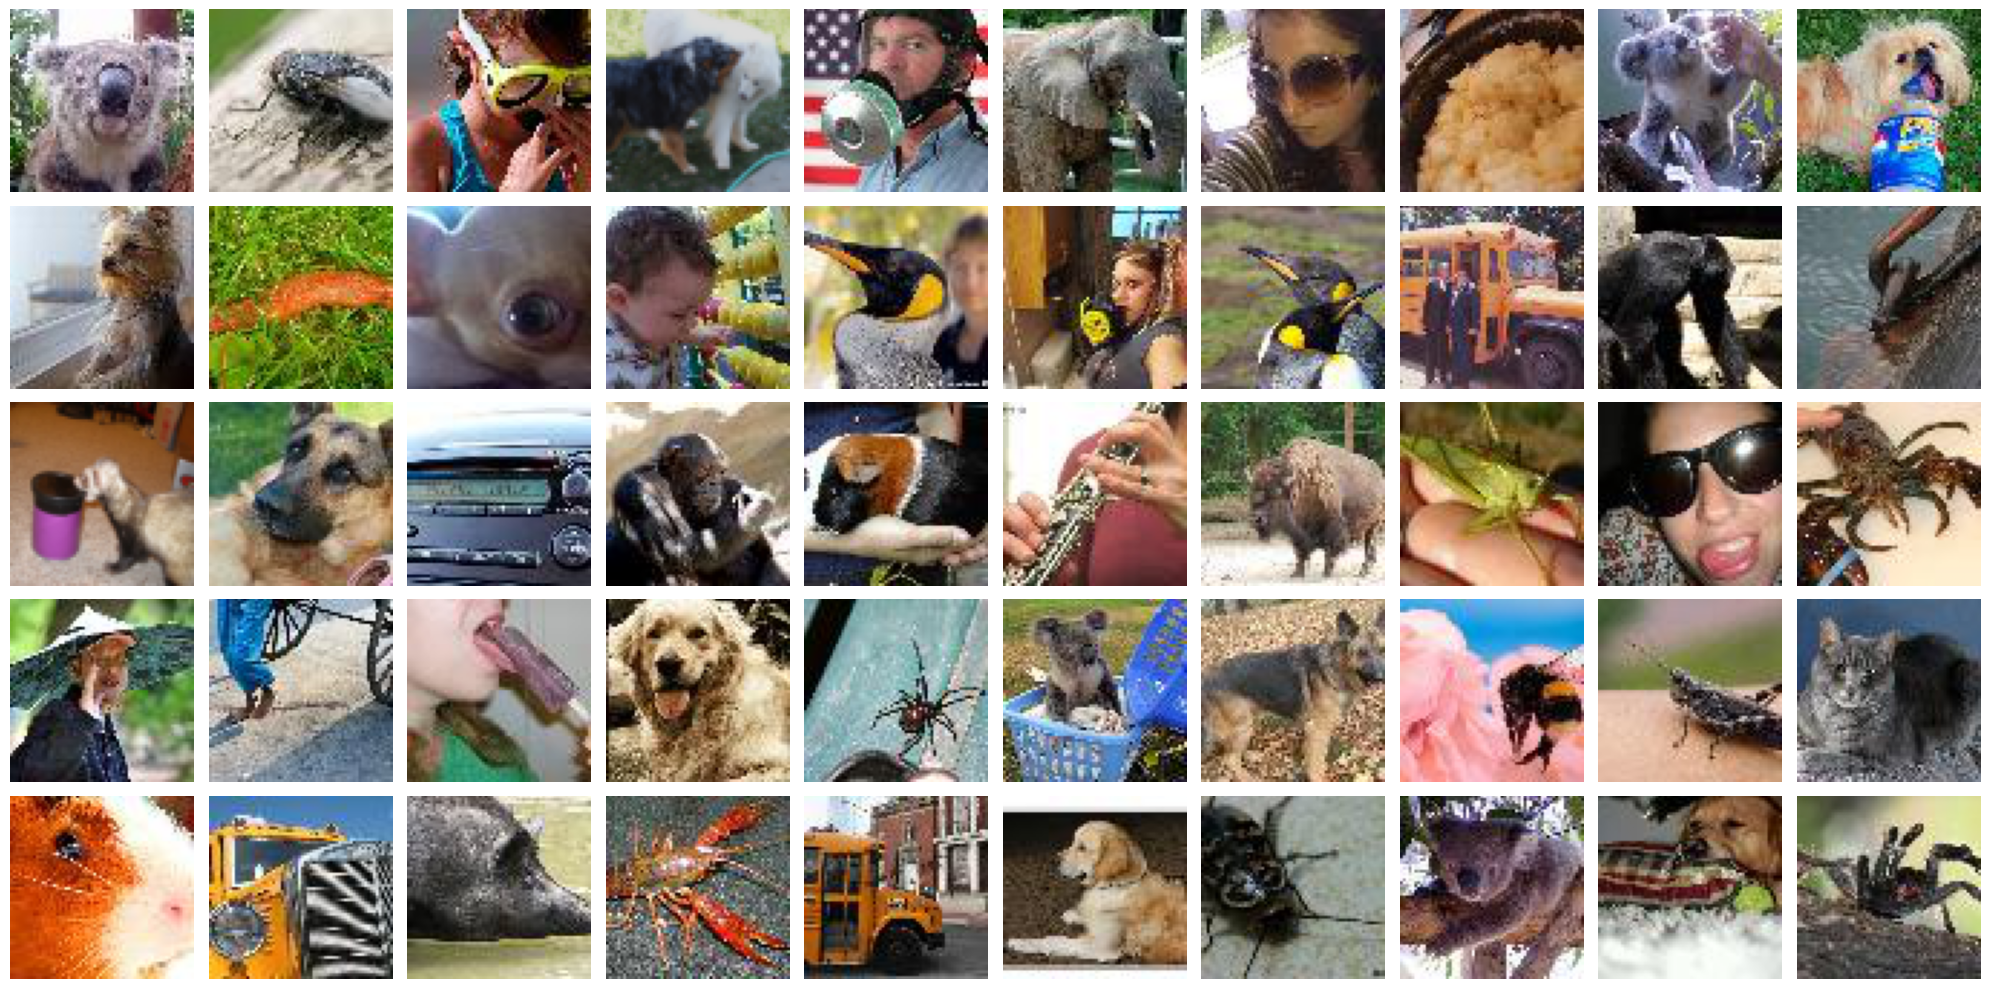

In [54]:
show_top_neuron_images(model, 'layer4.2.conv1', 495, val_dir='tiny-imagenet-200/images/images')

In [ ]:
# run this cell to split the validation images into 3x3 grids

def split_val_images(split, input_dir='./tiny-imagenet-200/val/images/', output_dir='./val_split/'):
    """Split validation images into [split x split] grids"""
    os.makedirs(output_dir, exist_ok=True)
    
    for img_name in tqdm(os.listdir(input_dir), desc="Splitting images"):
        if img_name.lower().endswith(('.jpeg', '.jpg', '.png')):
            img_path = os.path.join(input_dir, img_name)
            with Image.open(img_path) as img:
                w, h = img.size
                tile_size = (w//split, h//split)
                
                for i in range(split):
                    for j in range(split):
                        left = j * tile_size[0]
                        upper = i * tile_size[1]
                        right = left + tile_size[0]
                        lower = upper + tile_size[1]
                        
                        tile = img.crop((left, upper, right, lower))
                        base = os.path.splitext(img_name)[0]
                        ext = os.path.splitext(img_name)[1]
                        tile.save(os.path.join(output_dir, f"{base}_{i}_{j}{ext}"))

split_val_images(3)

Splitting images: 100%|██████████| 10000/10000 [05:10<00:00, 32.20it/s]


In [ ]:
show_top_neuron_images(model, 'layer3.2.conv3', 471, val_dir='./tiny-imagenet-200/val_split/')

Computing activations:  24%|██▍       | 21697/90000 [19:02<2:22:49,  7.97it/s]

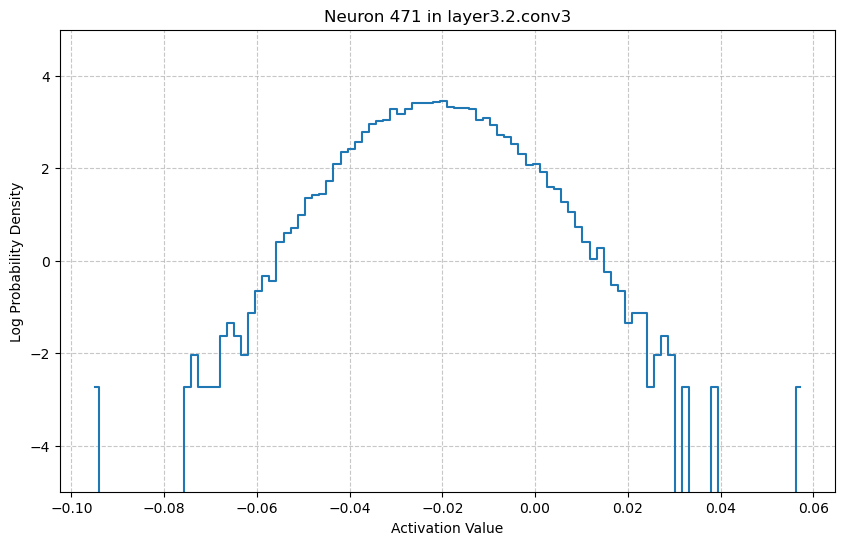

In [ ]:
def plot_neuron_distribution(model, target_layer, neuron_index, num_bins=100):
    """Plot log probability density of neuron activations"""
    # Collect activations
    activations = []
    transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
    ])

    
    for img_file in os.listdir('./tiny-imagenet-200/val/images/'):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img = transform(Image.open(f'./tiny-imagenet-200/images/images/{img_file}')).unsqueeze(0)
            acts = get_layer_activations(model, img, [target_layer])[target_layer].flatten()
            activations.append(acts[neuron_index].item())

    # Compute histogram with density normalization
    counts, bin_edges = np.histogram(activations, bins=num_bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    
    # Calculate log probability density (handle zero counts)
    log_density = np.log(counts + 1e-10)  # Add epsilon to avoid log(0)
    
    # Plot using step chart
    plt.figure(figsize=(10, 6))
    plt.step(bin_centers, log_density, where='mid')
    plt.xlabel('Activation Value')
    plt.ylabel('Log Probability Density')
    plt.title(f'Neuron {neuron_index} in {target_layer}')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.ylim(-5, 5)
    plt.show()

plot_neuron_distribution(model, 'layer3.2.conv3', 471, num_bins=100)

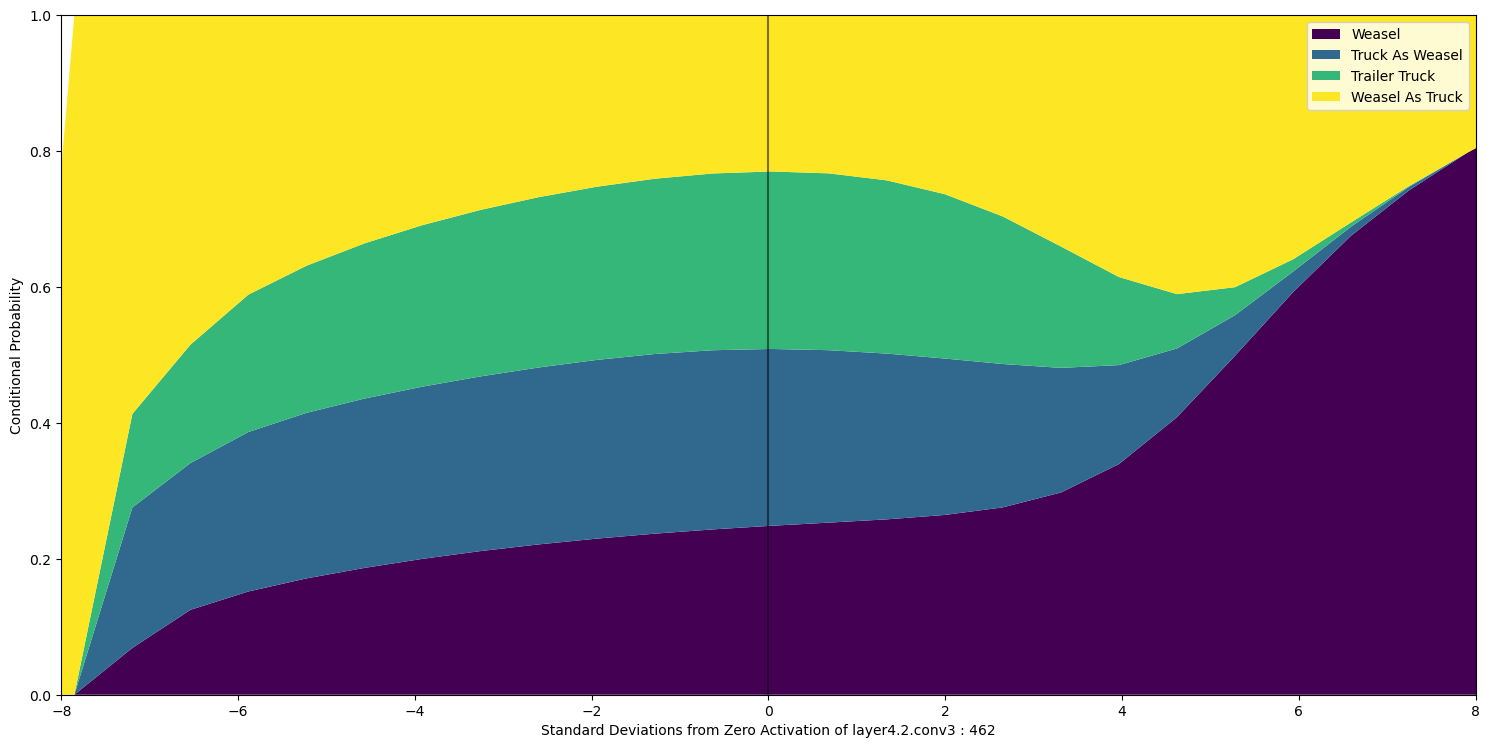

In [100]:
import matplotlib.gridspec as gridspec
from scipy.ndimage import gaussian_filter1d
from functools import reduce

def plot_neuron_conditional_probability(model, layer_name, neuron_index, image_dirs,
                                      num_bins=100, smoothing_sigma=2, batch_size=64):
    
    # 1. Setup categories and preprocessing
    categories = list(image_dirs.keys())
    activations = {cat: [] for cat in categories}
    device = next(model.parameters()).device
    
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4802, 0.4481, 0.3975], 
                            std=[0.2302, 0.2265, 0.2262])
    ])

    # 2. Process images in batches
    for category, img_dir in image_dirs.items():
        image_paths = [os.path.join(img_dir, f) for f in os.listdir(img_dir) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        # Process in batches
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            try:
                # Load and preprocess batch
                batch = [transform(Image.open(p).convert('RGB')) for p in batch_paths]
                batch_tensor = torch.stack(batch).to(device)
                
                # Get activations
                layer_acts = get_layer_activations(model, batch_tensor, [layer_name])
                acts = layer_acts[layer_name][:, neuron_index].cpu().numpy()
                
                activations[category].extend(acts.tolist())
                
            except Exception as e:
                print(f"Error processing batch {i//batch_size}: {str(e)}")

    # 3. Normalize activations
    all_acts = [act for cat_acts in activations.values() for act in cat_acts]
    mean_act = np.mean(all_acts)
    std_act = np.std(all_acts)
    normalized_acts = {cat: [(a - mean_act)/std_act for a in acts] 
                      for cat, acts in activations.items()}
    
    # 5. Create visualization
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3])
    
    
    # Create conditional probability plot
    ax_chart = plt.subplot(gs[1])
    
    # Compute histograms
    bins = np.linspace(-20, 45, num_bins)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    histograms = {}
    
    for category, acts in normalized_acts.items():
        hist, _ = np.histogram(acts, bins=bins, density=True)
        histograms[category] = gaussian_filter1d(hist, sigma=smoothing_sigma)
    
    # Create stacked conditional probabilities
    stacked_data = np.zeros((len(bin_centers), len(histograms)))
    for i, category in enumerate(categories):
        stacked_data[:, i] = histograms[category]
    
    # Normalize rows for conditional probability
    row_sums = np.maximum(stacked_data.sum(axis=1), 1e-10)
    stacked_data = stacked_data / row_sums[:, np.newaxis]
    
    # Plot stacked area chart
    colors = plt.cm.viridis(np.linspace(0, 1, len(categories)))
    ax_chart.stackplot(bin_centers, 
                     [stacked_data[:, i] for i in range(len(categories))],
                     labels=[cat.replace('_', ' ').title() for cat in categories],
                     colors=colors)
    
    # Add vertical line at x=0
    ax_chart.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    
    # Set labels
    ax_chart.set_xlabel(f'Standard Deviations from Zero Activation of {layer_name} : {neuron_index}')
    ax_chart.set_ylabel('Conditional Probability')
    ax_chart.set_xlim(-8, 8)
    ax_chart.set_ylim(0, 1.0)
    ax_chart.legend(loc='upper right')
    
    plt.tight_layout()
    return fig


# Define image directories
image_dirs = {
    'weasel': './adv_examples/weasel/others',
    'truck_as_weasel': './adv_examples/trailer_truck/adv_ex',
    'trailer_truck': './adv_examples/trailer_truck/others',
    'weasel_as_truck': './adv_examples/weasel/adv_ex'
}

# Create visualization
fig = plot_neuron_conditional_probability(
    model=model,
    layer_name='layer4.2.conv3',
    neuron_index=462,
    image_dirs=image_dirs
)

plt.savefig('weasel_truck_neuron_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

Vehicle images: 99
Animal images: 99


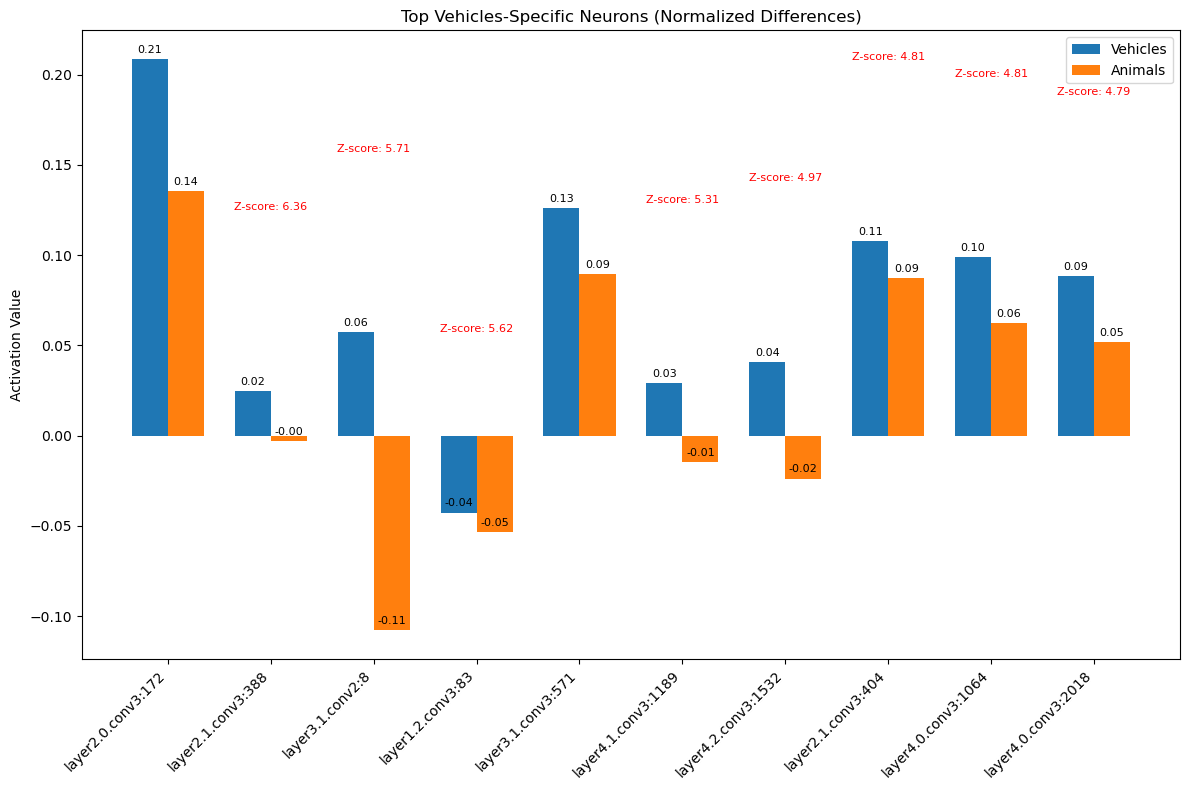

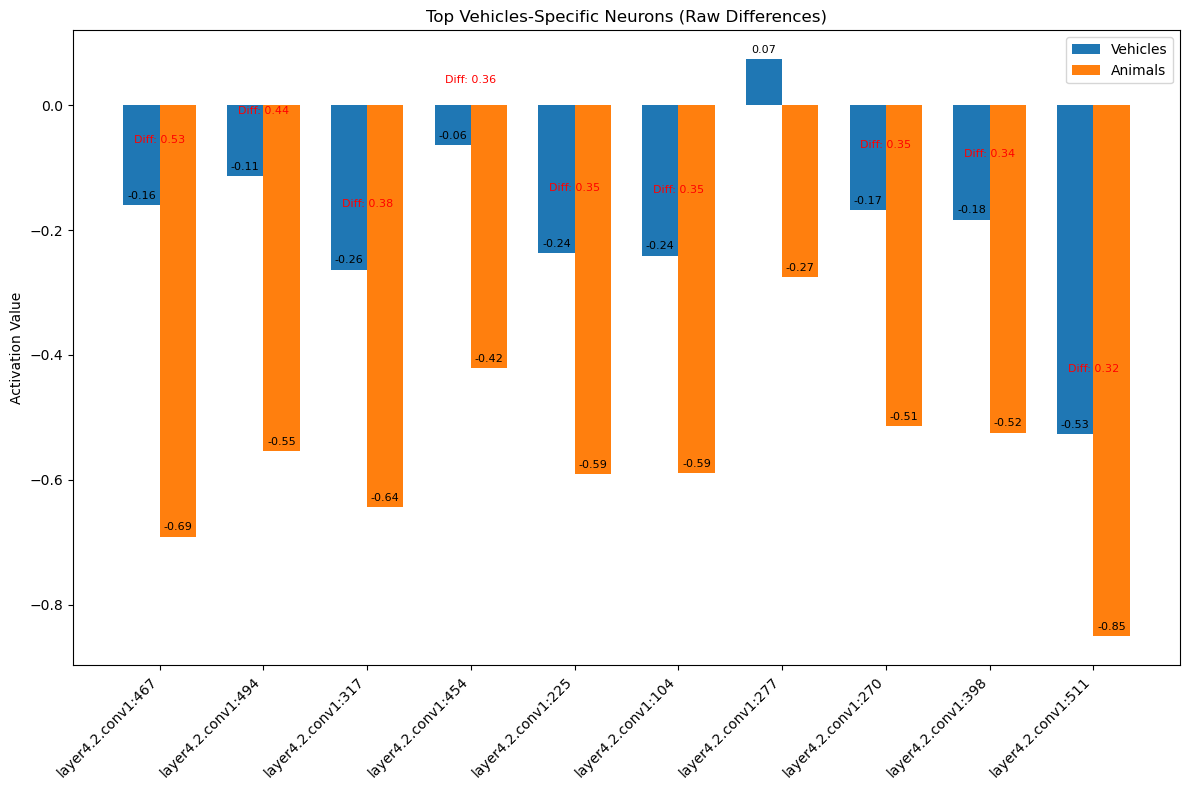

In [25]:
def prepare_vehicle_animal_groups(tiny_imagenet_dir='./tiny-imagenet-200'):
    """Prepare vehicle and animal image groups from Tiny ImageNet"""
    # Manually verified WordNet IDs for common vehicle/animal classes
    vehicle_wnids = ['n03930630', 'n04467665', 'n03796401']  # pickup, trailer truck, moving van
    animal_wnids = ['n02111889', 'n02441942', 'n02443484']   # dog, weasel, badger
    
    # Create dictionaries {image_name: image_path}
    vehicle_dict = {}
    animal_dict = {}
    
    # Load vehicle images
    for wnid in vehicle_wnids:
        img_dir = os.path.join(tiny_imagenet_dir, 'train', wnid, 'images')
        if os.path.exists(img_dir):
            for f in os.listdir(img_dir)[:33]:  # Get 33 from each class
                if f.lower().endswith(('.jpeg', '.jpg', '.png')):
                    vehicle_dict[f"vehicle_{wnid}_{f}"] = os.path.join(img_dir, f)
    
    # Load animal images                
    for wnid in animal_wnids:
        img_dir = os.path.join(tiny_imagenet_dir, 'train', wnid, 'images')
        if os.path.exists(img_dir):
            for f in os.listdir(img_dir)[:33]:  # Get 33 from each class
                if f.lower().endswith(('.jpeg', '.jpg', '.png')):
                    animal_dict[f"animal_{wnid}_{f}"] = os.path.join(img_dir, f)
    
    return vehicle_dict, animal_dict

# Create sample groups
vehicle_group, animal_group = prepare_vehicle_animal_groups()

print(f"Vehicle images: {len(vehicle_group)}")
print(f"Animal images: {len(animal_group)}")

# Run analysis with normalized differences
top_neurons = analyze_neurons_across_all_layers(
    
    vehicle_group,
    animal_group,
    group_b_name="Animals", 
    group_a_name="Vehicles"
)

# Run analysis with raw differences
top_neurons_raw = analyze_neurons_across_all_layers(
    
    vehicle_group,
    animal_group,
    normalize=False,
    group_b_name="Animals", 
    group_a_name="Vehicles"
)

In [9]:
def prepare_weasel_vs_nonweasel_groups(tiny_imagenet_dir='./tiny-imagenet-200'):
    """Prepare weasel and non-weasel image groups from Tiny ImageNet"""
    # Weasel WordNet ID
    weasel_wnid = 'n02441942'
    
    # Get all wnids in train directory
    train_dir = os.path.join(tiny_imagenet_dir, 'train')
    all_wnids = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
    
    # Non-weasel wnids are all except the weasel wnid
    non_weasel_wnids = [wnid for wnid in all_wnids if wnid != weasel_wnid]
    
    # Create dictionaries {image_name: image_path}
    weasel_dict = {}
    non_weasel_dict = {}
    
    # Load weasel images
    img_dir = os.path.join(train_dir, weasel_wnid, 'images')
    assert os.path.exists(img_dir), f"Weasel image directory not found: {img_dir}"
    if os.path.exists(img_dir):
        for f in os.listdir(img_dir)[:33]:  # Get 33 images
            if f.lower().endswith(('.jpeg', '.jpg', '.png')):
                weasel_dict[f"weasel_{weasel_wnid}_{f}"] = os.path.join(img_dir, f)
    
    # Load non-weasel images with a progress bar
    for wnid in tqdm(non_weasel_wnids, desc="Loading non-weasel images"):
    #for wnid in non_weasel_wnids:
        img_dir = os.path.join(train_dir, wnid, 'images')
        if os.path.exists(img_dir):
            for f in os.listdir(img_dir)[:33]:  # Get 33 images from each class
                if f.lower().endswith(('.jpeg', '.jpg', '.png')):
                    non_weasel_dict[f"nonweasel_{wnid}_{f}"] = os.path.join(img_dir, f)
    
    return weasel_dict, non_weasel_dict

Loading non-weasel images: 100%|██████████| 204/204 [00:05<00:00, 38.59it/s]


Weasel images: 33
Non-weasel images: 6732


Processing layers: 100%|██████████| 37/37 [23:12<00:00, 37.63s/it] 


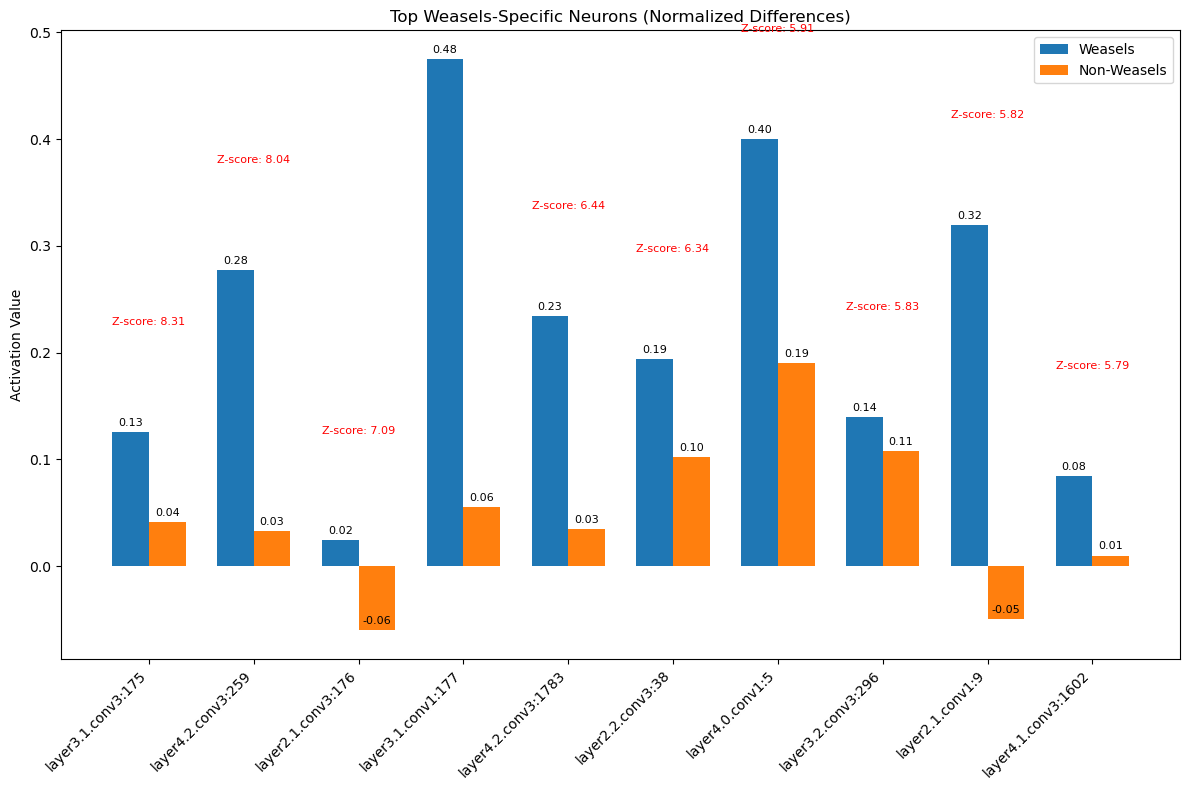

In [ ]:
# Create sample groups
weasel_group, non_weasel_group = prepare_weasel_vs_nonweasel_groups()

print(f"Weasel images: {len(weasel_group)}")
print(f"Non-weasel images: {len(non_weasel_group)}")

# Run analysis with normalized differences
top_neurons = analyze_neurons_across_all_layers(
    weasel_group,
    non_weasel_group,
    group_b_name="Non-Weasels", 
    group_a_name="Weasels"
)

In [107]:
def analyze_neurons_across_all_layers(
    group_a_dict=None,
    group_b_dict=None,
    normalize=True,
    group_a_name="Group A",
    group_b_name="Group B",
    group_a_color='#1f77b4',
    group_b_color='#ff7f0e',
    top_n=10,
    precomputed_group_a_activations=None,
    precomputed_group_b_activations=None,
    return_activations=False
):
    """
    Analyze neuron activations across ResNet layers, comparing two customizable groups,
    with support for reusing precomputed activations.

    Parameters
    ----------
    group_a_dict : dict, optional
        {image_name: image_path} for group A. Required if no precomputed_group_a_activations.
    group_b_dict : dict, optional
        {image_name: image_path} for group B. Required if no precomputed_group_b_activations.
    normalize : bool, default=True
        Whether to apply z-score normalization by layer.
    group_a_name : str, default="Group A"
        Display name for Group A in visualization.
    group_b_name : str, default="Group B"
        Display name for Group B in visualization.
    group_a_color : str, default='#1f77b4'
        Bar color for Group A.
    group_b_color : str, default='#ff7f0e'
        Bar color for Group B.
    top_n : int, default=10
        Number of top neurons to return and visualize.
    precomputed_group_a_activations : dict, optional
        Precomputed activations for group A ({image_name: {layer: tensor}}).
    precomputed_group_b_activations : dict, optional
        Precomputed activations for group B ({image_name: {layer: tensor}}).
    return_activations : bool, default=False
        If True, also return activations for both groups for reuse.

    Returns
    -------
    top_neurons : list of dict
        Information about top neurons.
    activations_dicts : dict (optional)
        { 'group_a_activations': ..., 'group_b_activations': ... }
        Only if return_activations=True.
    """

    # --- Compute or reuse activations for Group A ---
    if precomputed_group_a_activations is not None:
        activations_a = precomputed_group_a_activations
        group_a_images = set(activations_a.keys())
    else:
        if group_a_dict is None:
            raise ValueError("Either group_a_dict or precomputed_group_a_activations must be provided.")
        image_tensors_a = {}
        for name, path in tqdm(group_a_dict.items(), desc=f"Preprocessing {group_a_name}"):
            image_tensors_a[name] = preprocess_images([path])[0].unsqueeze(0)
        activations_a = {}
        for name, img in tqdm(image_tensors_a.items(), desc=f"Getting activations for {group_a_name}"):
            activations_a[name] = get_layer_activations(model, img, target_layers)
        group_a_images = set(group_a_dict.keys())

    # --- Compute or reuse activations for Group B ---
    if precomputed_group_b_activations is not None:
        activations_b = precomputed_group_b_activations
        group_b_images = set(activations_b.keys())
    else:
        if group_b_dict is None:
            raise ValueError("Either group_b_dict or precomputed_group_b_activations must be provided.")
        image_tensors_b = {}
        for name, path in tqdm(group_b_dict.items(), desc=f"Preprocessing {group_b_name}"):
            image_tensors_b[name] = preprocess_images([path])[0].unsqueeze(0)
        activations_b = {}
        for name, img in tqdm(image_tensors_b.items(), desc=f"Getting activations for {group_b_name}"):
            activations_b[name] = get_layer_activations(model, img, target_layers)
        group_b_images = set(group_b_dict.keys())

    # --- Merge activations ---
    activations = {**activations_a, **activations_b}

    # --- Analyze neuron activations ---
    all_neurons = []
    for layer in tqdm(target_layers, desc="Processing layers"):
        # Skip if layer doesn't exist in activations
        if layer not in next(iter(activations.values())):
            continue
        num_neurons = next(iter(activations.values()))[layer].shape[1]
        for idx in tqdm(range(num_neurons), desc=f"Processing neurons in {layer}", leave=False):
            neuron_data = {'layer': layer, 'neuron': idx}
            for img_name in activations:
                if layer in activations[img_name]:
                    neuron_data[img_name] = activations[img_name][layer][0, idx].item()
            # Calculate group activations
            group_a_acts = [neuron_data[name] for name in group_a_images if name in neuron_data]
            group_b_acts = [neuron_data[name] for name in group_b_images if name in neuron_data]
            neuron_data['group_a_avg'] = np.mean(group_a_acts) if group_a_acts else 0
            neuron_data['group_b_avg'] = np.mean(group_b_acts) if group_b_acts else 0
            neuron_data['raw_diff'] = neuron_data['group_a_avg'] - neuron_data['group_b_avg']
            all_neurons.append(neuron_data)

    # --- Normalize if requested ---
    if normalize:
        layer_diffs = defaultdict(list)
        for n in all_neurons:
            layer_diffs[n['layer']].append(n['raw_diff'])
        layer_stats = {}
        for layer, diffs in layer_diffs.items():
            layer_stats[layer] = {
                'mean': np.mean(diffs),
                'std': np.std(diffs) if np.std(diffs) > 0 else 1.0
            }
        for n in all_neurons:
            stats = layer_stats[n['layer']]
            n['diff'] = (n['raw_diff'] - stats['mean']) / stats['std']
    else:
        for n in all_neurons:
            n['diff'] = n['raw_diff']

    # --- Sort and select top neurons ---
    top_neurons = sorted(
        [n for n in all_neurons if n['diff'] > 0],
        key=lambda x: x['diff'],
        reverse=True
    )[:top_n]

    # --- Visualization ---
    fig, ax = plt.subplots(figsize=(12, 8))
    labels = [f"{n['layer']}:{n['neuron']}" for n in top_neurons]
    group_a = [n['group_a_avg'] for n in top_neurons]
    group_b = [n['group_b_avg'] for n in top_neurons]
    x = np.arange(len(labels))
    width = 0.35
    rects1 = ax.bar(x - width/2, group_a, width, label=group_a_name, color=group_a_color)
    rects2 = ax.bar(x + width/2, group_b, width, label=group_b_name, color=group_b_color)
    ax.set_ylabel('Activation Value')
    title_suffix = "(Normalized Differences)" if normalize else "(Raw Differences)"
    ax.set_title(f'Top {group_a_name}-Specific Neurons {title_suffix}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend()
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width()/2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)
    autolabel(rects1)
    autolabel(rects2)
    for i, n in enumerate(top_neurons):
        label = f"Z-score: {n['diff']:.2f}" if normalize else f"Diff: {n['diff']:.2f}"
        ax.annotate(label,
                   xy=(i, max(n['group_a_avg'], n['group_b_avg']) + 0.1),
                   ha='center', fontsize=8, color='red')
    plt.tight_layout()
    plt.show()

    if return_activations:
        return top_neurons, {
            'group_a_activations': activations_a,
            'group_b_activations': activations_b
        }
    return top_neurons


Processing layers: 100%|██████████| 37/37 [31:18<00:00, 50.78s/it] 


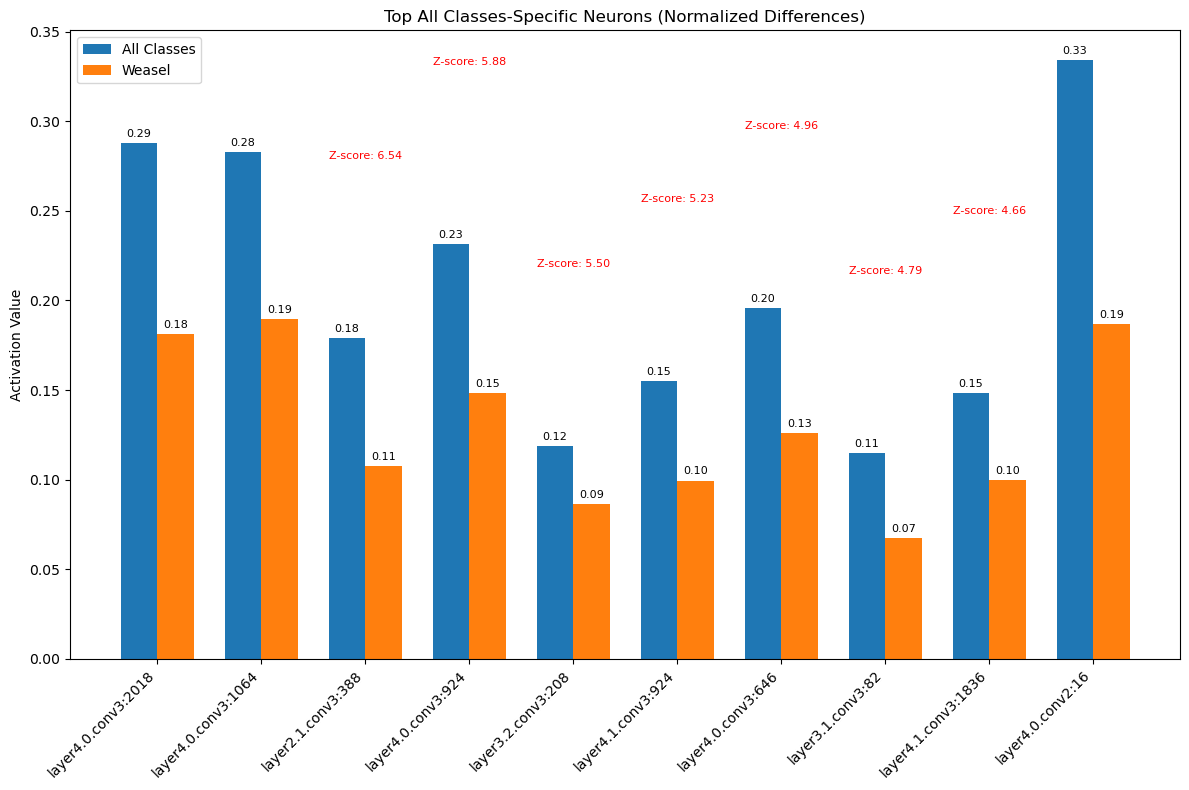

Processing layers: 100%|██████████| 37/37 [29:59<00:00, 48.63s/it] 


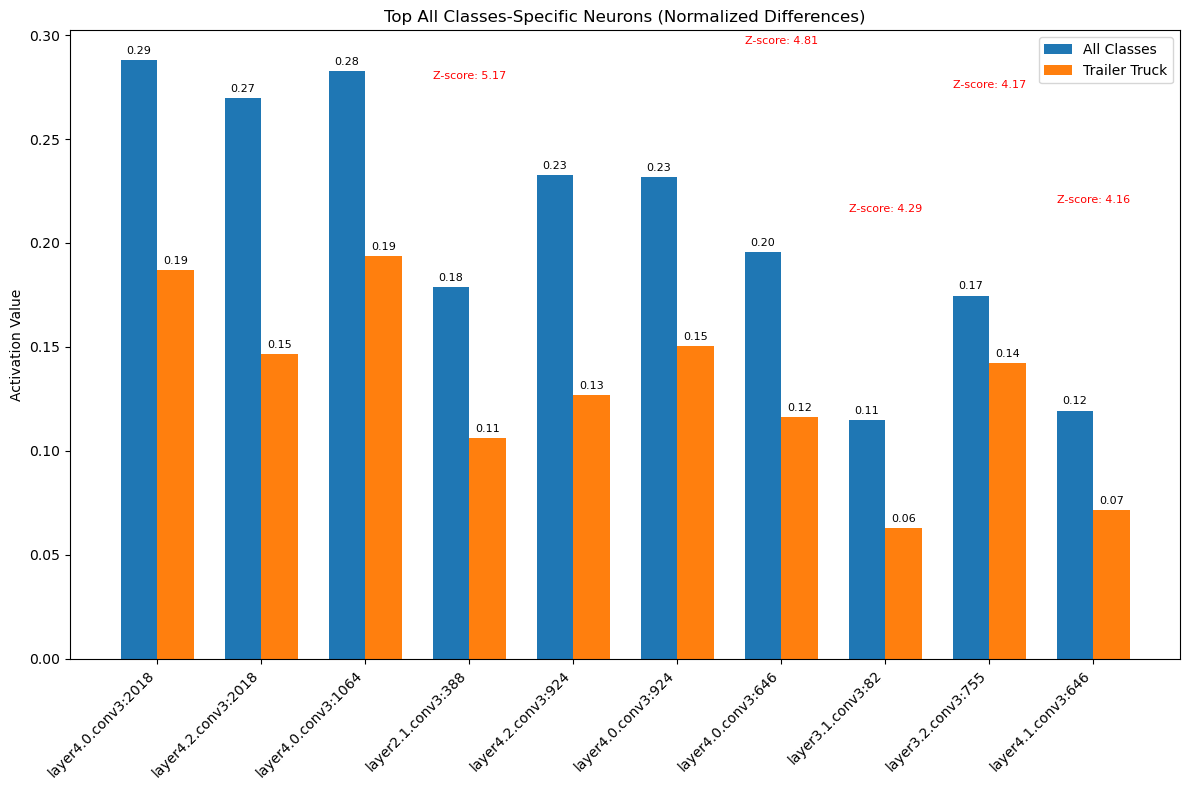

In [ ]:
TINY_IMAGENET_DIR = './tiny-imagenet-200'

def prepare_specific_class_group(wnid, tiny_imagenet_dir=TINY_IMAGENET_DIR):
    """Prepare images for a specific class"""
    class_dict = {}
    img_dir = os.path.join(tiny_imagenet_dir, 'train', wnid, 'images')
    if os.path.exists(img_dir):
        for f in os.listdir(img_dir)[:50]:
            if f.lower().endswith(('.jpeg', '.jpg', '.png')):
                class_dict[f"{wnid}_{f}"] = os.path.join(img_dir, f)
    return class_dict

def prepare_all_classes_group(tiny_imagenet_dir=TINY_IMAGENET_DIR, 
                             exclude_wnid=None, samples_per_class=50):
    """Prepare images for all classes in Tiny ImageNet"""
    all_classes_dict = {}
    train_dir = os.path.join(tiny_imagenet_dir, 'train')
    
    # Get all class directories
    wnids = [d for d in os.listdir(train_dir) 
            if os.path.isdir(os.path.join(train_dir, d))]
    
    # Optionally exclude specified WNID
    if exclude_wnid:
        wnids = [wnid for wnid in wnids if wnid != exclude_wnid]
    
    # Collect images with progress bar
    for wnid in tqdm(wnids, desc="Processing classes"):
        img_dir = os.path.join(train_dir, wnid, 'images')
        if not os.path.exists(img_dir):
            continue
            
        # Get first N images that match extensions
        valid_images = [f for f in os.listdir(img_dir) 
                       if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
        
        # Add sampled images to dict
        for f in valid_images[:samples_per_class]:
            unique_key = f"all_{wnid}_{f}"
            all_classes_dict[unique_key] = os.path.join(img_dir, f)
    
    return all_classes_dict


# Prepare groups
all_classes_dict = prepare_all_classes_group(tiny_imagenet_dir=TINY_IMAGENET_DIR)
weasel_dict = prepare_specific_class_group('n02441942')  # Weasel WNID
truck_dict = prepare_specific_class_group('n04467665')   # Trailer truck WNID

# # First analysis: All Classes vs Weasel
# top_weasel, activations = analyze_neurons_across_all_layers(
#     group_a_dict=all_classes_dict,
#     group_b_dict=weasel_dict,
#     group_a_name="All Classes",
#     group_b_name="Weasel",
#     return_activations=True
# )

# # Second analysis reusing All Classes activations: All Classes vs Trailer Truck
# top_truck = analyze_neurons_across_all_layers(
#     precomputed_group_a_activations=activations['group_a_activations'],
#     group_b_dict=truck_dict,
#     group_a_name="All Classes",
#     group_b_name="Trailer Truck"
# )


In [ ]:
print(activations)

Processing layers: 100%|██████████| 37/37 [33:51<00:00, 54.89s/it] 


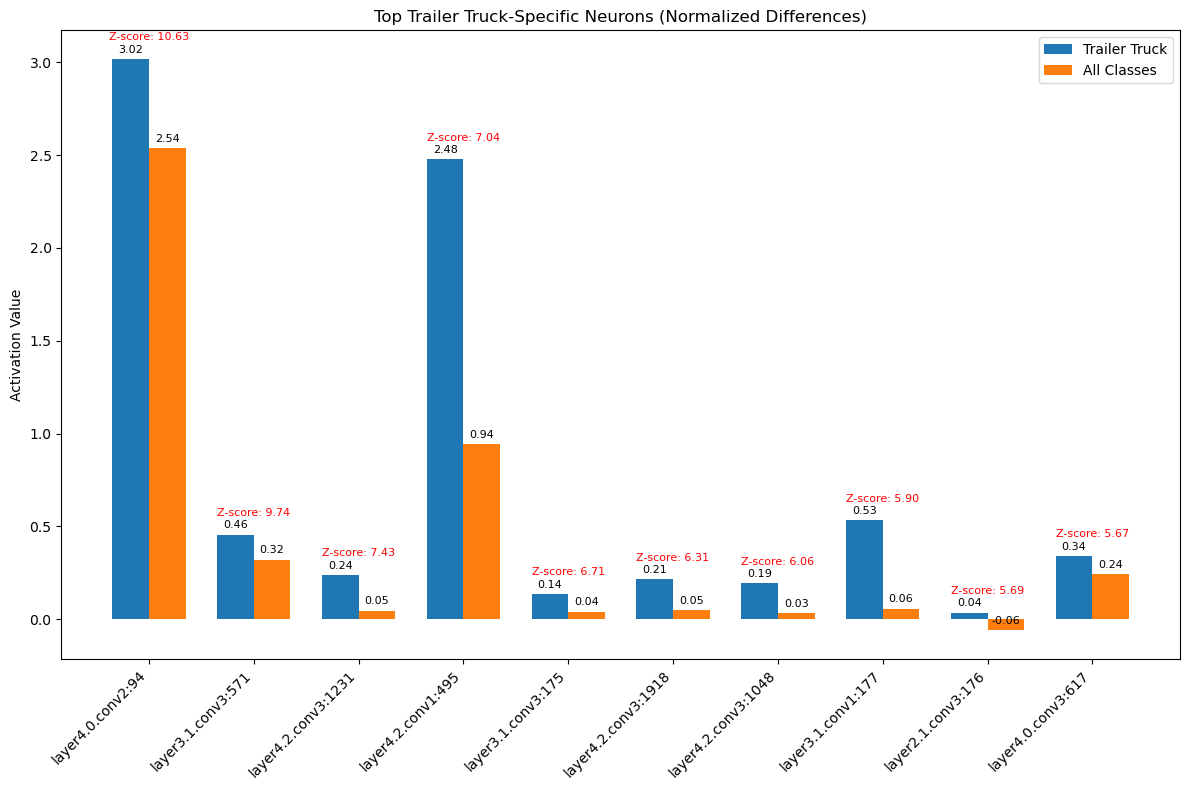

In [ ]:
# top_weasel = analyze_neurons_across_all_layers(
#     precomputed_group_b_activations=activations['group_a_activations'],
#     group_a_dict=truck_dict,
#     group_b_name="All Classes",
#     group_a_name="Trailer Truck"
# )

top_weasel = analyze_neurons_across_all_layers(
    group_b_dict=all_classes_dict,
    group_a_dict=weasel_dict,
    group_b_name="All Classes",
    group_a_name="Weasel"
)

top_weasel = analyze_neurons_across_all_layers(
    group_b_dict=all_classes_dict,
    group_a_dict=truck_dict,
    group_b_name="All Classes",
    group_a_name="Trailer Truck",
)

In [110]:
import pickle

def compute_layer_normalization_stats(model, tiny_imagenet_dir, target_layers,
                                     samples_per_class=33, batch_size=32):
    """
    Compute channel-wise mean/std statistics for model activations using Tiny ImageNet train set.
    """
    # Set model to evaluation mode and get device
    model.eval()
    device = next(model.parameters()).device
    
    # Collect all image paths
    train_dir = os.path.join(tiny_imagenet_dir, 'train')
    wnids = [d for d in os.listdir(train_dir) 
            if os.path.isdir(os.path.join(train_dir, d))]
    
    image_paths = []
    for wnid in tqdm(wnids, desc="Collecting images"):
        img_dir = os.path.join(train_dir, wnid, 'images')
        if not os.path.exists(img_dir):
            continue
            
        # Get first N images that match extensions
        valid_images = [f for f in os.listdir(img_dir) 
                       if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
        
        # Add sampled images
        image_paths.extend(
            [os.path.join(img_dir, f) for f in valid_images[:samples_per_class]]
        )

    # Initialize statistics storage
    stats = {
        layer: {
            'sum': None,
            'sum_sq': None, 
            'count': 0
        } for layer in target_layers
    }

    # Process in batches with progress bar
    num_batches = (len(image_paths) + batch_size - 1) // batch_size
    with tqdm(total=num_batches, desc="Computing stats") as pbar:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            
            # Preprocess and move to device
            batch_images = preprocess_images(batch_paths).to(device)
            
            # Get activations
            with torch.no_grad():
                activations = get_layer_activations(model, batch_images, target_layers)
            
            # Update statistics for each layer
            for layer in target_layers:
                if layer not in activations:
                    continue
                    
                layer_activations = activations[layer]  # (batch_size, num_channels)
                batch_count = layer_activations.shape[0]
                
                # Initialize storage if first batch
                if stats[layer]['sum'] is None:
                    stats[layer]['sum'] = torch.zeros_like(layer_activations.sum(dim=0))
                    stats[layer]['sum_sq'] = torch.zeros_like(layer_activations.pow(2).sum(dim=0))
                
                # Accumulate statistics
                stats[layer]['sum'] += layer_activations.sum(dim=0)
                stats[layer]['sum_sq'] += layer_activations.pow(2).sum(dim=0)
                stats[layer]['count'] += batch_count
            
            pbar.update(1)

    # Compute final mean and std
    layer_stats = {}
    for layer in target_layers:
        if stats[layer]['count'] == 0:
            raise ValueError(f"No activations collected for layer: {layer}")
            
        mean = stats[layer]['sum'] / stats[layer]['count']
        std = torch.sqrt(
            (stats[layer]['sum_sq'] / stats[layer]['count']) - mean.pow(2)
        )
        
        layer_stats[layer] = {
            'mean': mean.cpu(),
            'std': std.clamp_min(1e-8).cpu()  # Prevent division by zero
        }

    return layer_stats


def compute_and_save_normalization_stats(model, tiny_imagenet_dir, target_layers, 
                                        stats_path='normalization_stats_median.pkl', 
                                        samples_per_class=33):
    """
    Precompute and save layer normalization statistics using Tiny ImageNet train set.
    """
    # Use the compute_layer_normalization_stats function from search results[2]
    stats = compute_layer_normalization_stats(
        model=model,
        tiny_imagenet_dir=tiny_imagenet_dir,
        target_layers=target_layers,
        samples_per_class=samples_per_class
    )
    
    # Convert tensors to numpy for serialization
    stats_np = {}
    for layer, data in stats.items():
        stats_np[layer] = {
            'mean': data['mean'].numpy(),
            'std': data['std'].numpy()
        }
    
    with open(stats_path, 'wb') as f:
        pickle.dump(stats_np, f)
        
    return stats_path

def load_normalization_stats(stats_path='normalization_stats_median.pkl', device='cpu'):
    """
    Load precomputed normalization stats and convert to tensors.
    """
    with open(stats_path, 'rb') as f:
        stats_np = pickle.load(f)
    
    stats_torch = {}
    for layer, data in stats_np.items():
        stats_torch[layer] = {
            'mean': torch.from_numpy(data['mean']).to(device),
            'std': torch.from_numpy(data['std']).to(device)
        }
    return stats_torch

def get_layer_activations(model, images, target_layers, 
                         normalization_stats=None,
                         device='cpu'):
    """
    Modified version with optional normalization.
    """
    activations = {}
    
    def hook_fn(module, input, output, layer_name):
        # Extract and optionally normalize activations
        raw_activ = output.detach().mean(dim=[2, 3])  # [batch_size, channels]
        
        if normalization_stats and layer_name in normalization_stats:
            stats = normalization_stats[layer_name]
            normalized = (raw_activ - stats['mean']) / stats['std']
            activations[layer_name] = normalized
        else:
            activations[layer_name] = raw_activ

    hooks = []
    for name, layer in model.named_modules():
        if name in target_layers:
            hooks.append(layer.register_forward_hook(
                lambda m, i, o, n=name: hook_fn(m, i, o, n)))

    with torch.no_grad():
        model(images.to(device))

    for hook in hooks:
        hook.remove()

    return activations


In [ ]:
# First-time setup
stats_path = compute_and_save_normalization_stats(
    model=model,
    tiny_imagenet_dir='./tiny-imagenet-200',
    target_layers=target_layers,
    samples_per_class=50
)


Computing stats:  14%|█▍        | 45/321 [05:23<30:36,  6.65s/it]

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load precomputed stats
norm_stats = load_normalization_stats(stats_path, device=device)

In [20]:
def analyze_distribution_neurons(dict, normalization_stats, 
                          group_name="Weasel", 
                          top_n=20, device='cpu'):
    """
    Identify and print top responsive neurons with normalized/raw values.
    
    Parameters:
    -----------
    weasel_dict : dict
        {image_name: image_path} for weasel images
    normalization_stats : dict
        Precomputed stats from load_normalization_stats()
    group_name : str, default="Weasel"
        Display name for output
    top_n : int, default=20
        Number of top neurons to show
    device : str, default='cpu'
        Computation device
        
    Returns:
    --------
    list
        Top neurons with normalized and raw activation values
    """
    # Preprocess images
    image_tensors = {}
    for name, path in tqdm(dict.items(), desc="Preprocessing group images"):
        image_tensors[name] = preprocess_images([path])[0].unsqueeze(0).to(device)
    
    # Get normalized activations
    activations = {}
    for name, img in tqdm(image_tensors.items(), desc="Weasel activations"):
        activations[name] = get_layer_activations(
            model, img, target_layers,
            normalization_stats=normalization_stats,
            device=device
        )
    
    # Collect neuron data with normalized values
    all_neurons = []
    for layer in tqdm(target_layers, desc="Analyzing layers"):
        if layer not in next(iter(activations.values())):
            continue
            
        num_neurons = next(iter(activations.values()))[layer].shape[1]
        
        for idx in tqdm(range(num_neurons), desc=f"Layer {layer}", leave=False):
            neuron_acts = []
            for img_name in activations:
                if layer in activations[img_name]:
                    neuron_acts.append(activations[img_name][layer][0, idx].item())
            
            if neuron_acts:
                all_neurons.append({
                    'layer': layer,
                    'neuron': idx,
                    'norm_mean': np.mean(neuron_acts),
                    'norm_std': np.std(neuron_acts),
                    'num_samples': len(neuron_acts)
                })
    
    # Calculate raw values using normalization stats
    for neuron in all_neurons:
        layer = neuron['layer']
        idx = neuron['neuron']
        try:
            mean = normalization_stats[layer]['mean'][idx].item()
            std = normalization_stats[layer]['std'][idx].item()
            neuron['raw_mean'] = (neuron['norm_mean'] * std) + mean
        except (KeyError, IndexError):
            neuron['raw_mean'] = None  # Handle missing stats
    
    # Sort by normalized activation strength
    top_neurons = sorted(all_neurons, 
                        key=lambda x: x['norm_mean'], 
                        reverse=True)[:top_n]
    
    # Print results in table format
    print(f"\n' Rank for group {group_name}'{'':-^60}")
    print(f"| {'Neuron':<35} | {'Normalized (Z)':<15} | {'Raw Activation':<15} |")
    print(f"|{'-'*37}|{'-'*17}|{'-'*17}|")
    
    for i, neuron in enumerate(top_neurons, 1):
        if neuron['raw_mean'] is not None:
            raw_str = f"{neuron['raw_mean']:.4f}"
        else:
            raw_str = "N/A"
            
        print(f"| {i:2}. {neuron['layer']}:{neuron['neuron']:<15} " 
              f"| {neuron['norm_mean']:>+7.2f} (±{neuron['norm_std']:.2f}) "
              f"| {raw_str:^15} |")
    
    print(f"{'':-^60}\n")
    
    return top_neurons

In [22]:
# Prepare weasel images
weasel_dict = prepare_specific_class_group('n02441942')

# Run analysis
top_weasel_neurons = analyze_distribution_neurons(
    dict=weasel_dict,
    normalization_stats=norm_stats
)

Analyzing layers: 100%|██████████| 37/37 [00:13<00:00,  2.71it/s]



' Rank for group Weasel'------------------------------------------------------------
| Neuron                              | Normalized (Z)  | Raw Activation  |
|-------------------------------------|-----------------|-----------------|
|  1. layer2.1.conv3:189             |   +5.27 (±1.65) |     0.0680      |
|  2. layer2.1.conv3:163             |   +5.18 (±1.37) |     0.0225      |
|  3. layer2.1.conv3:347             |   +4.89 (±1.41) |     0.0087      |
|  4. layer2.2.conv2:69              |   +4.83 (±1.23) |     -0.0518     |
|  5. layer2.1.conv3:405             |   +4.79 (±1.34) |     -0.0070     |
|  6. layer2.1.conv3:176             |   +4.77 (±1.24) |     -0.0334     |
|  7. layer2.2.conv2:122             |   +4.73 (±0.83) |     -0.1014     |
|  8. layer4.2.conv3:259             |   +4.71 (±2.57) |     0.0657      |
|  9. layer2.1.conv3:491             |   +4.70 (±1.21) |     0.0119      |
| 10. layer2.1.conv3:339             |   +4.69 (±1.39) |     0.0152      |
| 11. layer2

In [24]:
trailer_truck_dict = prepare_specific_class_group('n04467665')

top_trailer_truck_neurons = analyze_distribution_neurons(
    dict=trailer_truck_dict,
    group_name="Trailer Truck",
    normalization_stats=norm_stats
)

Analyzing layers: 100%|██████████| 37/37 [00:13<00:00,  2.82it/s]



' Rank for group Trailer Truck'------------------------------------------------------------
| Neuron                              | Normalized (Z)  | Raw Activation  |
|-------------------------------------|-----------------|-----------------|
|  1. layer1.0.conv3:139             |   +6.47 (±1.66) |     0.0210      |
|  2. layer2.1.conv1:9               |   +5.85 (±1.52) |     0.0267      |
|  3. layer2.2.conv3:192             |   +5.84 (±1.05) |     -0.0257     |
|  4. layer1.1.conv2:63              |   +5.75 (±1.51) |     -0.1095     |
|  5. layer2.0.conv3:288             |   +5.73 (±1.49) |     0.1105      |
|  6. layer2.2.conv1:62              |   +5.62 (±1.29) |     -0.0960     |
|  7. layer2.0.conv3:388             |   +5.60 (±1.56) |     -0.0025     |
|  8. layer1.1.conv1:10              |   +5.60 (±2.02) |     -0.2819     |
|  9. layer1.1.conv2:18              |   +5.60 (±1.46) |     -0.3694     |
| 10. layer3.1.conv1:177             |   +5.48 (±0.96) |     0.1905      |
| 11.

In [36]:
def analyze_layer4_neurons(image_dict, group_name="Weasel", 
                          top_n=20, device='cpu'):
    """
    Analyze raw activation values for specific layer4 convolutional sublayers
    
    Parameters:
    -----------
    image_dict : dict
        {image_name: image_path} for target class images
    group_name : str, default="Weasel"
        Display name for output
    top_n : int, default=20
        Number of top neurons to show
    device : str, default='cpu'
        Computation device
        
    Returns:
    --------
    list
        Top neurons with raw activation values from layer4 sublayers
    """
    # Get all convolutional layers in layer4
    target_layers = []
    for name, module in model.named_modules():
        if name.startswith('layer4') and isinstance(module, torch.nn.Conv2d):
            target_layers.append(name)
    
    # Preprocess images
    image_tensors = {}
    for name, path in tqdm(image_dict.items(), desc=f"Preprocessing {group_name}"):
        image_tensors[name] = preprocess_images([path])[0].unsqueeze(0).to(device)
    
    # Get RAW activations (no normalization)
    activations = {}
    for name, img in tqdm(image_tensors.items(), desc="Getting layer4 activations"):
        activations[name] = get_layer_activations(
            model, img, 
            target_layers=target_layers,
            normalization_stats=norm_stats,
            device=device
        )
    
    # Collect neuron data
    all_neurons = []
    for layer in target_layers:
        if layer not in activations[list(activations.keys())[0]]:
            continue
            
        num_neurons = activations[list(activations.keys())[0]][layer].shape[1]
        
        for idx in tqdm(range(num_neurons), desc=f"Processing {layer}", leave=False):
            neuron_acts = []
            for img_name in activations:
                if layer in activations[img_name]:
                    neuron_acts.append(activations[img_name][layer][0, idx].item())
            
            if neuron_acts:
                all_neurons.append({
                    'layer': layer,
                    'neuron': idx,
                    'z_mean': np.mean(neuron_acts),
                    'z_std': np.std(neuron_acts),
                    'sample_count': len(neuron_acts)
                })
    
    # Sort by normalized activation strength
    top_neurons = sorted(all_neurons, 
                        key=lambda x: x['z_mean'], 
                        reverse=True)[:top_n]
    
    # Print results
    print(f"\n{' Top Normalized Layer4 Neurons for ' + group_name + ' ':-^70}")
    print(f"| {'Neuron':<45} | {'Z-score (μ±σ)':<20}")
    print(f"|{'-'*47}|{'-'*22}|")
    
    for i, neuron in enumerate(top_neurons, 1):
        neuron_id = f"{neuron['layer']}:{neuron['neuron']}"
        print(f"| {i:2}. {neuron_id:<40} " 
              f"| {neuron['z_mean']:>+6.2f} ± {neuron['z_std']:.2f} ")
    
    print(f"{'':-^70}\n")
    
    return top_neurons


In [35]:
weasel_neurons = analyze_layer4_neurons(
    image_dict=weasel_dict,
    group_name="Weasels"
)

Getting layer4 activations: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]
                                                                                       


------------- Top Normalized Layer4 Neurons for Weasels --------------
| Neuron                                        | Z-score (μ±σ)       
|-----------------------------------------------|----------------------|------------|
|  1. layer4.2.conv3:259                       |  +4.71 ± 2.57 
|  2. layer4.0.conv1:5                         |  +4.21 ± 0.93 
|  3. layer4.2.conv1:495                       |  +4.02 ± 1.10 
|  4. layer4.2.conv3:1783                      |  +3.88 ± 1.91 
|  5. layer4.2.conv3:914                       |  +3.81 ± 2.16 
|  6. layer4.2.conv3:299                       |  +3.50 ± 2.04 
|  7. layer4.2.conv3:1473                      |  +3.38 ± 2.19 
|  8. layer4.2.conv3:697                       |  +3.33 ± 2.18 
|  9. layer4.2.conv3:257                       |  +3.27 ± 1.71 
| 10. layer4.2.conv3:635                       |  +3.26 ± 1.98 
| 11. layer4.2.conv3:2022                      |  +3.25 ± 2.07 
| 12. layer4.2.conv3:529                       |  +3.22 ± 2.20 
| 1

In [37]:
truck_neurons = analyze_layer4_neurons(
    image_dict=trailer_truck_dict,
    group_name="Trailer Trucks"
)

Getting layer4 activations: 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]
                                                                                       


---------- Top Normalized Layer4 Neurons for Trailer Trucks ----------
| Neuron                                        | Z-score (μ±σ)       
|-----------------------------------------------|----------------------|
|  1. layer4.2.conv1:495                       |  +4.09 ± 0.78 
|  2. layer4.2.conv3:271                       |  +4.08 ± 2.01 
|  3. layer4.2.conv3:1280                      |  +3.81 ± 1.66 
|  4. layer4.2.conv3:1231                      |  +3.74 ± 1.80 
|  5. layer4.0.conv1:5                         |  +3.58 ± 0.75 
|  6. layer4.2.conv3:1484                      |  +3.39 ± 1.89 
|  7. layer4.2.conv3:510                       |  +3.36 ± 1.41 
|  8. layer4.2.conv3:1071                      |  +3.32 ± 1.54 
|  9. layer4.2.conv3:1918                      |  +3.21 ± 2.01 
| 10. layer4.2.conv3:1048                      |  +3.11 ± 1.40 
| 11. layer4.2.conv3:535                       |  +3.10 ± 1.03 
| 12. layer4.2.conv3:712                       |  +3.01 ± 1.30 
| 13. layer4.2.c

In [67]:
def compute_sublayer_stats(normalization_stats):
    """
    Compute mean/std for each sublayer's neuron means
    """
    sublayer_stats = {}
    
    # For each convolutional sublayer in layer4
    for layer in normalization_stats:
        if "layer4" in layer and "downsample" not in layer:
            # Get mean of all neuron means in this sublayer
            sublayer_means = normalization_stats[layer]['mean'].cpu().numpy()
            sublayer_stats[layer] = {
                'mean': np.mean(sublayer_means),
                'std': np.std(sublayer_means)
            }
    
    return sublayer_stats


In [101]:
def analyze_layer4_neurons(image_dict, normalization_stats, sublayer_stats,
                          group_name="Weasel", top_n=20, device='cpu'):
    """
    Analyze layer4 neurons with dual normalization, ignoring non-conv layers
    """
    # Get only convolutional layers present in both model and sublayer_stats
    target_layers = []
    for name, module in model.named_modules():
        if (name.startswith('layer3') 
            and isinstance(module, torch.nn.Conv2d) 
            and name in sublayer_stats):
            target_layers.append(name)
    
    # Preprocess images
    image_tensors = {}
    for name, path in tqdm(image_dict.items(), desc=f"Preprocessing {group_name}"):
        image_tensors[name] = preprocess_images([path])[0].unsqueeze(0).to(device)
    
    # Get normalized activations
    activations = {}
    for name, img in tqdm(image_tensors.items(), desc="Getting activations"):
        activations[name] = get_layer_activations(
            model, img, 
            target_layers=target_layers,
            normalization_stats=normalization_stats,
            device=device
        )
    
    # Collect neuron data with double normalization
    all_neurons = []
    for layer in target_layers:
        # Skip layers without activation data
        if layer not in activations[list(activations.keys())[0]]:
            continue
            
        num_neurons = activations[list(activations.keys())[0]][layer].shape[1]
        
        # Get sublayer normalization parameters
        layer_stats = sublayer_stats[layer]
        sublayer_mean = layer_stats['mean']
        sublayer_std = layer_stats['std']
        
        for idx in tqdm(range(num_neurons), desc=f"Processing {layer}", leave=False):
            neuron_acts = []
            for img_name in activations:
                if layer in activations[img_name]:
                    neuron_acts.append(activations[img_name][layer][0, idx].item())
            
            if neuron_acts:
                # Dataset-normalized mean
                z_mean = np.mean(neuron_acts)
                
                # Sublayer-normalized score
                sublayer_z = (z_mean - sublayer_mean) / (sublayer_std + 1e-8)
                
                all_neurons.append({
                    'layer': layer,
                    'neuron': idx,
                    'dataset_z': z_mean,
                    'sublayer_z': sublayer_z,
                    'sample_count': len(neuron_acts)
                })
    
    # Sort by sublayer-normalized scores
    top_neurons = sorted(all_neurons, 
                        key=lambda x: x['sublayer_z'], 
                        reverse=True)[:top_n]
    
    # Print results
    print(f"\n{' Top Layer4 Neurons for ' + group_name + ' ':-^90}")
    print(f"| {'Neuron':<45} | {'Dataset Z':<10} | {'Sublayer Z':<10} | {'Samples':<8} |")
    print(f"|{'-'*47}|{'-'*12}|{'-'*12}|{'-'*10}|")
    
    for i, neuron in enumerate(top_neurons, 1):
        neuron_id = f"{neuron['layer']}:{neuron['neuron']}"
        print(f"| {i:2}. {neuron_id:<40} | {neuron['dataset_z']:>+8.2f}  | {neuron['sublayer_z']:>+8.2f}  | {neuron['sample_count']:^8} |")
    
    print(f"{'':-^90}\n")
    
    return top_neurons


In [102]:
sublayer_stats = compute_sublayer_stats(norm_stats)

top_neurons = analyze_layer4_neurons(
    image_dict=weasel_dict,
    normalization_stats=norm_stats,
    sublayer_stats=sublayer_stats,
    group_name="Weasels"
)

Getting activations: 100%|██████████| 50/50 [00:53<00:00,  1.06s/it]


----------------------------- Top Layer4 Neurons for Weasels -----------------------------
| Neuron                                        | Dataset Z  | Sublayer Z | Samples  |
|-----------------------------------------------|------------|------------|----------|
------------------------------------------------------------------------------------------



In [71]:
top_neurons = analyze_layer4_neurons(
    image_dict=trailer_truck_dict,
    normalization_stats=norm_stats,
    sublayer_stats=sublayer_stats,
    group_name="Trailer Trucks"
)

Getting activations: 100%|██████████| 50/50 [00:11<00:00,  4.50it/s]
                                                                                


-------------------- Top Layer4 Neurons (Filtered) for Trailer Trucks --------------------
| Neuron                                        | Dataset Z  | Sublayer Z | Samples  |
|-----------------------------------------------|------------|------------|----------|
|  1. layer4.2.conv3:271                       |    +4.08  |  +362.50  |    50    |
|  2. layer4.2.conv3:1280                      |    +3.81  |  +338.58  |    50    |
|  3. layer4.2.conv3:1231                      |    +3.74  |  +332.78  |    50    |
|  4. layer4.2.conv3:1484                      |    +3.39  |  +301.68  |    50    |
|  5. layer4.2.conv3:510                       |    +3.36  |  +299.12  |    50    |
|  6. layer4.2.conv3:1071                      |    +3.32  |  +295.48  |    50    |
|  7. layer4.2.conv3:1918                      |    +3.21  |  +285.18  |    50    |
|  8. layer4.2.conv3:1048                      |    +3.11  |  +276.55  |    50    |
|  9. layer4.2.conv3:535                       |    +3.10  |  

In [88]:
def prepare_adv_example_group(group_name, adv_dir, max_images=50):
    """
    Prepare a group dictionary from an adversarial example directory.
    
    Parameters:
    -----------
    group_name : str
        Prefix for dictionary keys (e.g., 'truck_as_weasel')
    adv_dir : str
        Path to the directory containing adversarial images
    max_images : int, default=50
        Maximum number of images to include
    
    Returns:
    --------
    dict
        {unique_name: image_path} for the group
    """
    group_dict = {}
    if os.path.exists(adv_dir):
        for f in os.listdir(adv_dir)[:max_images]:
            if f.lower().endswith(('.jpeg', '.jpg', '.png')):
                group_dict[f"{group_name}_{f}"] = os.path.join(adv_dir, f)
    return group_dict


truck_as_weasel_dict = prepare_adv_example_group(
    group_name='truck_as_weasel',
    adv_dir='./adv_examples/trailer_truck/adv_ex'
)

In [89]:
top_neurons = analyze_layer4_neurons(
    image_dict=truck_as_weasel_dict,
    normalization_stats=norm_stats,
    sublayer_stats=sublayer_stats,
    group_name="Trailer Trucks as weasels"
)

Getting activations: 100%|██████████| 50/50 [00:14<00:00,  3.47it/s]
                                                                                


-------------- Top Layer4 Neurons (Filtered) for Trailer Trucks as weasels ---------------
| Neuron                                        | Dataset Z  | Sublayer Z | Samples  |
|-----------------------------------------------|------------|------------|----------|
|  1. layer4.2.conv3:148                       |    +3.95  |  +351.59  |    50    |
|  2. layer4.2.conv3:929                       |    +3.81  |  +339.18  |    50    |
|  3. layer4.2.conv3:712                       |    +3.71  |  +330.05  |    50    |
|  4. layer4.2.conv3:462                       |    +3.60  |  +320.48  |    50    |
|  5. layer4.2.conv3:228                       |    +3.54  |  +314.84  |    50    |
|  6. layer4.2.conv3:1443                      |    +3.50  |  +311.23  |    50    |
|  7. layer4.2.conv3:537                       |    +3.50  |  +310.95  |    50    |
|  8. layer4.2.conv3:1468                      |    +3.49  |  +310.00  |    50    |
|  9. layer4.2.conv3:1974                      |    +3.47  |  

In [90]:
weasel_as_truck_dict = prepare_adv_example_group(
    group_name='weasel_as_truck',
    adv_dir='./adv_examples/trailer_truck/adv_ex'
)

top_neurons = analyze_layer4_neurons(
    image_dict=weasel_as_truck_dict,
    normalization_stats=norm_stats,
    sublayer_stats=sublayer_stats,
    group_name="Weasels as trailer trucks"
)

Getting activations: 100%|██████████| 50/50 [00:13<00:00,  3.69it/s]
                                                                                


-------------- Top Layer4 Neurons (Filtered) for Weasels as trailer trucks ---------------
| Neuron                                        | Dataset Z  | Sublayer Z | Samples  |
|-----------------------------------------------|------------|------------|----------|
|  1. layer4.2.conv3:148                       |    +3.95  |  +351.59  |    50    |
|  2. layer4.2.conv3:929                       |    +3.81  |  +339.18  |    50    |
|  3. layer4.2.conv3:712                       |    +3.71  |  +330.05  |    50    |
|  4. layer4.2.conv3:462                       |    +3.60  |  +320.48  |    50    |
|  5. layer4.2.conv3:228                       |    +3.54  |  +314.84  |    50    |
|  6. layer4.2.conv3:1443                      |    +3.50  |  +311.23  |    50    |
|  7. layer4.2.conv3:537                       |    +3.50  |  +310.95  |    50    |
|  8. layer4.2.conv3:1468                      |    +3.49  |  +310.00  |    50    |
|  9. layer4.2.conv3:1974                      |    +3.47  |  